In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime
import time
import os

import pygad

from sklearn.metrics import r2_score

import subprocess as sp
import os

In [2]:
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 12}

matplotlib.rc('font', **font)

### Function defs

In [3]:
def date_parser_func(x):
    x  = x[:6]+"20"+x[6:]

    return time.strftime("%m/%d/%Y %H:%M:%S",time.strptime(x,'%m/%d/%Y %I:%M:%S %p'))

def date_parser_func2(x):
    #x  = x[:6]+"20"+x[6:]

    return time.strftime("%m/%d/%Y %H:%M:%S",time.strptime(x,'%m/%d/%Y %H:%M'))

def read_result(fileName):
    with open(fileName) as fp:
        lines = fp.readlines()

    line_res = []
    for line in lines:
        #print(line)
        line_res.append(line)
    line_res = line_res[-5:]

    return float(line_res[0].strip()),float(line_res[1].strip()),float(line_res[2].strip()),float(line_res[3].strip()),float(line_res[4].strip())


def crop_sky_image(fileName):
 
    # Opens a image in RGB mode
    im = Image.open(fileName)
        #

    # Size of the image in pixels (size of original image)
    # (This is not mandatory)
    width, height = im.size


    # Setting the points for cropped image
    left = 100
    top = 0
    right = 612
    bottom = 512

    # Cropped image of above dimension
    # (It will not change original image)
    im1 = im.crop((left, top, right, bottom))

    # Shows the image in image viewer
    #im1.show()
    im1.save(fileName+"_crop.bmp")

def fitness_func(solution,solution_idx):
    Wall_ref,Floor_ref,Table_ref,Win_trn = solution[0],solution[1],solution[2],solution[3]

    edit_Mat_properties(Wall_ref,Floor_ref,Table_ref,Win_trn)

    ## generate a scene
    os.system(r'C:\Radiance\bin\oconv -f materials.rad room.rad > octrees/room3ph.oct')

    # generate v matrix
    os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -ab 4 -ad 60000 -lw 0.000002 -n 16 -y 5 - objects/Glazing.rad -i octrees/room3ph.oct < points.txt > matrices/v.mtx')

    # generate D matrix
    os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -ad 1000 -lw 0.001 -c 1000 -n 16 objects/Glazing.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/daylight.dmx')

    for i in range(23):
        ## calcualte View matrices

        # calculate illuminance and post-process
        os.system('dctimestep matrices/v.mtx matrices/clear.xml matrices/daylight.dmx skyVectors/CSta_Per_{}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0923_3/3ph_{}.ill'.format(i+1,i+1))
    
    #read flux data
    simu_result_0923_3 = []
    for i in range(13):
        simu_result_0923_3.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0923_3\3ph_{}.ill'.format(i+7)))

    simu_result_0923_3 = pd.DataFrame(simu_result_0923_3)
    print(r2_score(dat_17_resample.iloc[38:38+13,-1],simu_result_0923_3.iloc[:,0]),r2_score(dat_18_resample.iloc[38:38+13,-1],simu_result_0923_3.iloc[:,1]))
    r2_total = r2_score(dat_17_resample.iloc[38:38+13,-1],simu_result_0923_3.iloc[:,0]) + r2_score(dat_18_resample.iloc[38:38+13,-1],simu_result_0923_3.iloc[:,1])
    return r2_total

def edit_Mat_properties(Wall_ref,Floor_ref,Table_ref,Win_trn):
    ## check if file exists, if yes, delete them

    ## edit floor and wall materials
    if os.path.isfile('materials.rad') :
        os.remove('materials.rad')

    with open('materials_temp.rad') as fp:
        lines = fp.readlines()

    lines_new = []
    for line in lines:
        line = line.replace('%Wall%','{}'.format(Wall_ref))
        line = line.replace('%floor%','{}'.format(Floor_ref))

        lines_new.append(line)
    with open('materials.rad','w') as fp:
        fp.writelines(lines_new) 


    ## edit table materials
    if os.path.isfile(r'objects\table.rad') :
        os.remove(r'objects\table.rad')

    with open(r'objects\table_temp.rad') as fp:
        lines = fp.readlines()

    lines_new = []
    for line in lines:
        line = line.replace('%table%','{}'.format(Table_ref))
        lines_new.append(line)

    with open(r'objects\table.rad','w') as fp:
        fp.writelines(lines_new) 

    # edit glazing
    if os.path.isfile(r'objects\Glazing.rad') :
        os.remove(r'objects\Glazing.rad')

    with open(r'objects\Glazing_temp.rad') as fp:
        lines = fp.readlines()

    lines_new = []
    for line in lines:
        line = line.replace('%Glazing%','{}'.format(Win_trn))
        lines_new.append(line)

    with open(r'objects\Glazing.rad','w') as fp:
        fp.writelines(lines_new) 


def date_parser_func(x):
    x  = x[:6]+"20"+x[6:]

    return time.strftime("%m/%d/%Y %H:%M:%S",time.strptime(x,'%m/%d/%Y %I:%M:%S %p'))

def on_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    
def fitness_func_5M(solution,solution_idx):
    Wall_ref,Floor_ref,Table_ref,Win_trn = solution[0],solution[1],solution[2],solution[3]

    edit_Mat_properties(Wall_ref,Floor_ref,Table_ref,Win_trn)

    ## generate a scene
    os.system(r'C:\Radiance\bin\oconv -f materials.rad room.rad > octrees/room3ph.oct')

    # generate v matrix
    os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Glazing.rad -i octrees/room3ph.oct < points.txt > matrices/v.mtx')

    # generate D matrix
    os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Glazing.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/daylight.dmx')


    #read flux data
    simu_result_0922_5M = []
    for i in range(14):
        for j in range(12):
            simu_result_0922_5M.append(read_result('results/0922_5M/3ph_H{}_{}.ill'.format(i+6,j*5)))

    simu_result_0922_5M = pd.DataFrame(simu_result_0922_5M)
    
    #2_total = r2_score(dat_17_resample.iloc[38:38+13,-1],simu_result_0923_3.iloc[:,0]) + r2_score(dat_18_resample.iloc[38:38+13,-1],simu_result_0923_3.iloc[:,1])
    return simu_result_0922_5M

#### Metrics function

In [4]:
def nmbe(y_sim,y_mea):
    l = len(y_sim)
    nmbe = 0
    y_mea_avg = sum(y_mea)/l
    
    mbe = sum([(y_sim[i]-y_mea[i]) for i in range(l)])/l
    nmbe = mbe/y_mea_avg
    return nmbe

def cv_rmse(y_sim,y_mea):
    l = len(y_sim)
    cv_rmse = 0
    y_mea_avg = sum(y_mea)/l
    
    mse = sum([(y_sim[i]-y_mea[i])**2 for i in range(l)])/l
    cv_rmse = mse**(1/2)/y_mea_avg
    return cv_rmse

### Read data

In [10]:
path = 'TestDataset\\Set1_BlindFullyOpen\\'

dat_09 = pd.read_csv(path + 'Sensor_09.csv',header=1)
dat_17 = pd.read_csv(path +'Sensor_17.csv',header=1,parse_dates=[1],date_parser = date_parser_func)
dat_17=dat_17.iloc[:,:-3]
dat_17 = dat_17.set_index("Date Time, GMT-05:00")

dat_18 = pd.read_csv(path +'Sensor_18.csv',header=1,parse_dates=[1],date_parser = date_parser_func)
dat_18=dat_18.iloc[:,:-3]
dat_18 = dat_18.set_index("Date Time, GMT-05:00")

dat_19 = pd.read_csv(path +'Sensor_19.csv',header=1)
dat_20 = pd.read_csv(path +'Sensor_20.csv',header=1)
dat_22 = pd.read_csv(path +'Sensor_22.csv',header=1,parse_dates=[1],date_parser = date_parser_func)
dat_22=dat_22.iloc[:,:-3]
dat_22 = dat_22.set_index("Date Time, GMT-05:00")


dat_9 = pd.read_csv(path +'Sensor_09.csv',header=1,parse_dates=[1],date_parser = date_parser_func)
dat_9=dat_9.iloc[:,:-3]
dat_9 = dat_9.set_index("Date Time, GMT-05:00")


dat_23 = pd.read_csv(path +'Sensor_23.csv',header=1,parse_dates=[1],date_parser = date_parser_func)
dat_23=dat_23.iloc[:,:-3]
dat_23 = dat_23.set_index("Date Time, GMT-05:00")


dat_17_resample = dat_17.resample('1H').mean()
dat_18_resample = dat_18.resample('1H').mean()
dat_23_resample = dat_23.resample('1H').mean()
dat_22_resample = dat_22.resample('1H').mean()

# resample to 5Minute
dat_9_5M_Case1 = dat_9.resample('5T').mean()
dat_17_5M_Case1 = dat_17.resample('5T').mean()
dat_18_5M_Case1 = dat_18.resample('5T').mean()
dat_22_5M_Case1 = dat_22.resample('5T').mean()
dat_23_5M_Case1 = dat_23.resample('5T').mean()

In [11]:
path = r'TestDataset\Set2_Blind50_VerticalAndHorizon'
dat_09 = pd.read_csv(path+'\\'+'Sensor_09.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_09=dat_09.iloc[:,:-2]
dat_09 = dat_09.set_index("Date Time, GMT-05:00")

dat_17 = pd.read_csv(path+'\\'+'Sensor_17.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_17=dat_17.iloc[:,:-2]
dat_17 = dat_17.set_index("Date Time, GMT-05:00")

dat_18 = pd.read_csv(path+'\\'+'Sensor_18.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_18=dat_18.iloc[:,:-3]
dat_18 = dat_18.set_index("Date Time, GMT-05:00")

dat_19 = pd.read_csv(path+'\\'+'Sensor_19.csv',header=1)
dat_20 = pd.read_csv(path+'\\'+'Sensor_20.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_20=dat_20.iloc[:-3,:-3]
dat_20 = dat_20.set_index("Date Time, GMT-05:00")

dat_22 = pd.read_csv(path+'\\'+'Sensor_22.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_22=dat_22.iloc[:,:-3]
dat_22 = dat_22.set_index("Date Time, GMT-05:00")

dat_23 = pd.read_csv(path+'\\'+'Sensor_23.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_23=dat_23.iloc[:,:-3]
dat_23 = dat_23.set_index("Date Time, GMT-05:00")


dat_17_resample = dat_17.resample('1H').mean()
dat_17_resample = dat_17.resample('1H').mean()
dat_18_resample = dat_18.resample('1H').mean()
dat_20_resample = dat_20.resample('1H').mean()
dat_23_resample = dat_23.resample('1H').mean()
dat_22_resample = dat_22.resample('1H').mean()

# resample to 5Minute
dat_17_5M_Case2 = dat_17.resample('5T').mean()
dat_09_5M_Case2 = dat_09.resample('5T').mean()
dat_18_5M_Case2 = dat_18.resample('5T').mean()
dat_20_5M_Case2 = dat_20.resample('5T').mean()
dat_22_5M_Case2 = dat_22.resample('5T').mean()
dat_23_5M_Case2 = dat_23.resample('5T').mean()

In [12]:
path = r'TestDataset\Set3_Blind75_VerticalAndHorizon'

dat_09 = pd.read_csv(path+'\\'+'Sensor_09.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_09=dat_09.iloc[:,:-2]
dat_09 = dat_09.set_index("Date Time, GMT-05:00")

dat_17 = pd.read_csv(path+'\\'+'Sensor_17.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_17=dat_17.iloc[:,:-2]
dat_17 = dat_17.set_index("Date Time, GMT-05:00")

dat_18 = pd.read_csv(path+'\\'+'Sensor_18.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_18=dat_18.iloc[:,:-3]
dat_18 = dat_18.set_index("Date Time, GMT-05:00")

dat_19 = pd.read_csv(path+'\\'+'Sensor_19.csv',header=1)
dat_20 = pd.read_csv(path+'\\'+'Sensor_20.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_20=dat_20.iloc[:-3,:-3]
dat_20 = dat_20.set_index("Date Time, GMT-05:00")


dat_22 = pd.read_csv(path+'\\'+'Sensor_22.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_22=dat_22.iloc[:,:-3]
dat_22 = dat_22.set_index("Date Time, GMT-05:00")

dat_23 = pd.read_csv(path+'\\'+'Sensor_23.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_23=dat_23.iloc[:,:-3]
dat_23 = dat_23.set_index("Date Time, GMT-05:00")


dat_17_resample = dat_17.resample('1H').mean()
dat_17_resample = dat_17.resample('1H').mean()
dat_18_resample = dat_18.resample('1H').mean()
dat_20_resample = dat_20.resample('1H').mean()
dat_23_resample = dat_23.resample('1H').mean()
dat_22_resample = dat_22.resample('1H').mean()

# resample to 5Minute
dat_17_5M_Case3 = dat_17.resample('5T').mean()
dat_09_5M_Case3 = dat_09.resample('5T').mean()
dat_18_5M_Case3 = dat_18.resample('5T').mean()
dat_20_5M_Case3 = dat_20.resample('5T').mean()
dat_22_5M_Case3 = dat_22.resample('5T').mean()
dat_23_5M_Case3 = dat_23.resample('5T').mean()

In [14]:
path = r'TestDataset\Set3_Blind75_VerticalAndHorizon\Case5'
dat_17 = pd.read_csv(path+'\\'+'Sensor_17.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_17=dat_17.iloc[:,:-2]
dat_17 = dat_17.set_index("Date Time, GMT-05:00")

dat_18 = pd.read_csv(path+'\\'+'Sensor_18.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_18=dat_18.iloc[:,:-3]
dat_18 = dat_18.set_index("Date Time, GMT-05:00")

dat_20 = pd.read_csv(path+'\\'+'Sensor_20.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_20=dat_20.iloc[:,:-2]
dat_20 = dat_20.set_index("Date Time, GMT-05:00")

## On the south-facing wall
dat_22 = pd.read_csv(path+'\\'+'Sensor_22.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_22=dat_22.iloc[:,:-2]
dat_22 = dat_22.set_index("Date Time, GMT-05:00")

## On the north-facing wall
dat_9 = pd.read_csv(path+'\\'+'Sensor_09.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_9=dat_9.iloc[:,:-2]
dat_9 = dat_9.set_index("Date Time, GMT-05:00")

dat_17_resample = dat_17.resample('1H').mean()
dat_18_resample = dat_18.resample('1H').mean()
dat_20_resample = dat_20.resample('1H').mean()
dat_22_resample = dat_22.resample('1H').mean()
dat_9_resample = dat_9.resample('1H').mean()

# resample to 5Minute
dat_17_5M_Case5 = dat_17.resample('5T').mean()
dat_18_5M_Case5 = dat_18.resample('5T').mean()
dat_20_5M_Case5 = dat_20.resample('5T').mean()
dat_22_5M_Case5 = dat_22.resample('5T').mean()
dat_9_5M_Case5 = dat_9.resample('5T').mean()

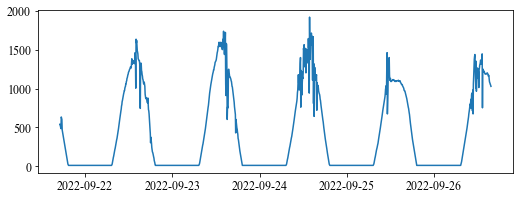

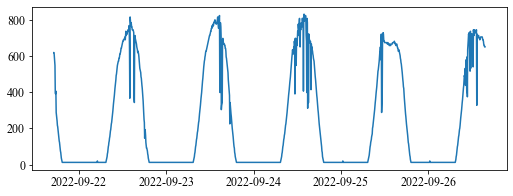

In [16]:
h = 3
plt.figure(figsize=[8.5,h])
plt.plot(dat_17_5M_Case1.iloc[:-2,3])

plt.figure(figsize=[8.5,h])
plt.plot(dat_18_5M_Case1.iloc[:-2,3])

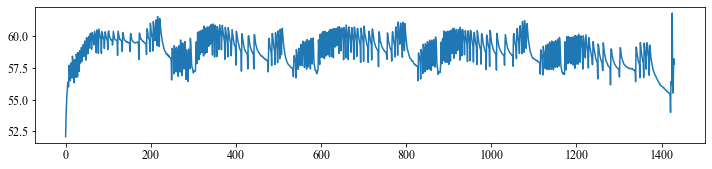

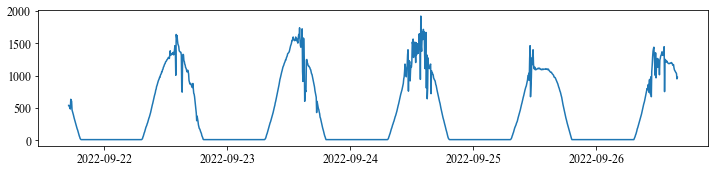

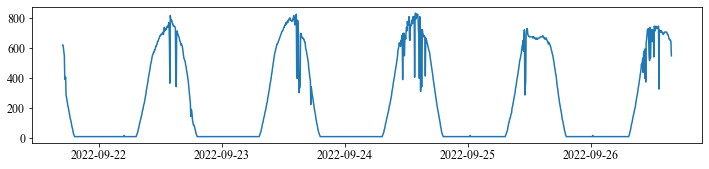

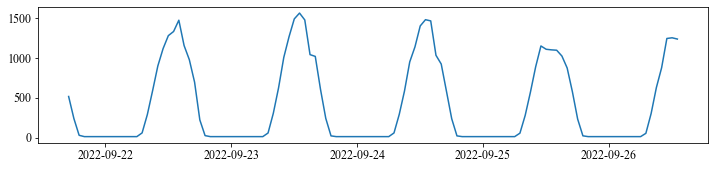

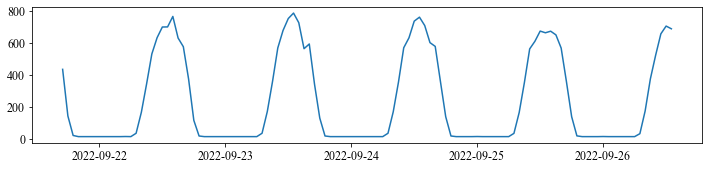

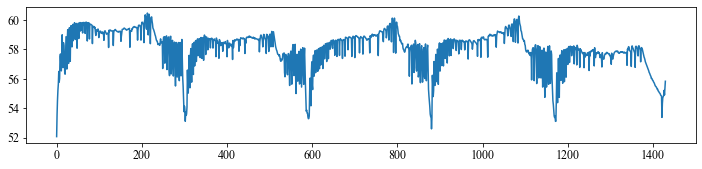

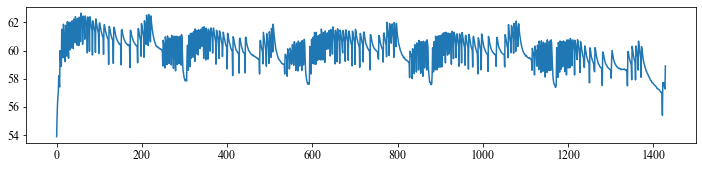

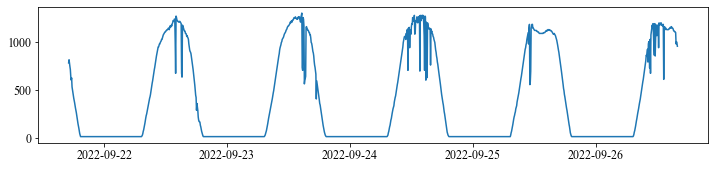

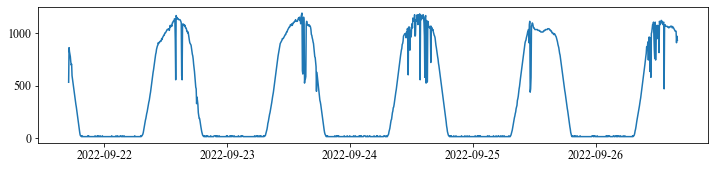

In [23]:
h = 2.5
plt.figure(figsize=[12,h])
plt.plot(dat_09.iloc[:-2,3])

plt.figure(figsize=[12,h])
plt.plot(dat_17.iloc[:-2,3])

plt.figure(figsize=[12,h])
plt.plot(dat_18.iloc[:-2,3])

plt.figure(figsize=[12,h])
plt.plot(dat_17_resample.iloc[:-2,3])


plt.figure(figsize=[12,h])
plt.plot(dat_18_resample.iloc[:-2,3])


plt.figure(figsize=[12,h])
plt.plot(dat_19.iloc[:-2,3])

plt.figure(figsize=[12,h])
plt.plot(dat_20.iloc[:-2,3])

plt.figure(figsize=[12,h])
plt.plot(dat_22.iloc[:-2,3])

plt.figure(figsize=[12,h])
plt.plot(dat_23.iloc[:-2,3])


In [23]:
simu_result = []
for i in range(13):
    simu_result.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0922\3ph_{}.ill'.format(i+7)))
    
simu_result = pd.DataFrame(simu_result)

IndexError: list index out of range

In [24]:
simu_result_0923 = []
for i in range(13):
    simu_result_0923.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0923\3ph_{}.ill'.format(i+7)))
    
simu_result_0923 = pd.DataFrame(simu_result_0923)

In [25]:
simu_result_0923_1 = []
for i in range(13):
    simu_result_0923_1.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0923_1\3ph_{}.ill'.format(i+7)))
    
simu_result_0923_1 = pd.DataFrame(simu_result_0923_1)

In [26]:
simu_result_0923_2 = []
for i in range(13):
    simu_result_0923_2.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0923_2\3ph_{}.ill'.format(i+7)))
    
simu_result_0923_2 = pd.DataFrame(simu_result_0923_2)

AttributeError: 'list' object has no attribute 'iloc'

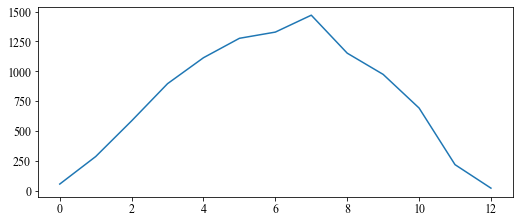

In [27]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(13),dat_17_resample.iloc[14:14+13,-1])
plt.plot(np.arange(13),simu_result.iloc[:,0])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux1')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0922_sensor1.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(13),dat_18_resample.iloc[14:14+13,-1])
plt.plot(np.arange(13),simu_result.iloc[:,1])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux2')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0922_sensor2.jpg',dpi=300)

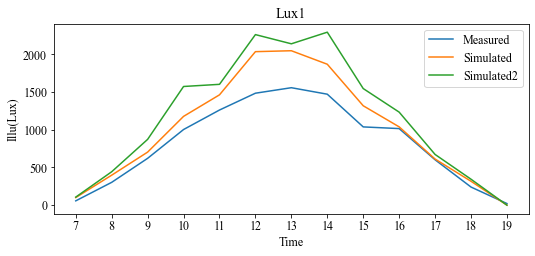

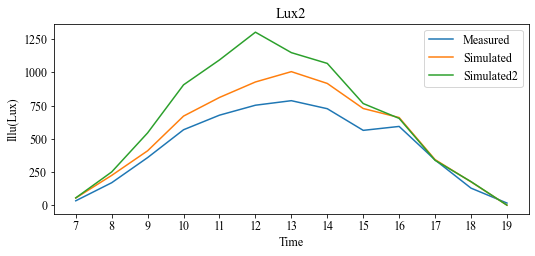

In [16]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(13),dat_17_resample.iloc[38:38+13,-1])
plt.plot(np.arange(13),simu_result_0923.iloc[:,0])
plt.plot(np.arange(13),simu_result_0923_1.iloc[:,0])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated','Simulated2'])
ax.set_title('Lux1')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0923_sensor1.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(13),dat_18_resample.iloc[38:38+13,-1])
plt.plot(np.arange(13),simu_result_0923.iloc[:,1])
plt.plot(np.arange(13),simu_result_0923_1.iloc[:,1])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated','Simulated2'])
ax.set_title('Lux2')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0923_sensor2.jpg',dpi=300)

### Pyranometer measurements

1) Voltage to radiance: $1mV = 1W\cdot m^2$

2) **date parser:** lambda x:time.strftime("%m/%d/%Y %H:%M:%S",time.strptime(x,'%m/%d/%Y %H:%M %p'))

In [12]:
py_DF = pd.read_csv('Pyranometer.csv',parse_dates=[0],date_parser = lambda x:time.strftime("%m/%d/%Y %H:%M:%S",time.strptime(x,'%m/%d/%Y %I:%M %p')))
py_DF = py_DF.set_index('datetime')

py_DF.to_csv('Pyranometer_af.csv')

## resample 
py_DF_resample = py_DF.resample('1H').mean()
py_DF_resample.to_csv('pyranometer_Hourly.csv')

# calc Total and diffuse
py_DF_resample['Total(W/m2)'] = py_DF_resample['CH1'].apply(lambda x:x*1000)
py_DF_resample['Diffuse(W/m2)'] = py_DF_resample['Ch2'].apply(lambda x:x*1000)


#### 5min ########

## resample 
py_DF_5M = py_DF.resample('5T').mean()
py_DF_5M.to_csv('pyranometer_5M.csv')

# calc Total and diffuse
py_DF_5M['Total(W/m2)'] = py_DF_5M['CH1'].apply(lambda x:x*1000)
py_DF_5M['Diffuse(W/m2)'] = py_DF_5M['Ch2'].apply(lambda x:x*1000)

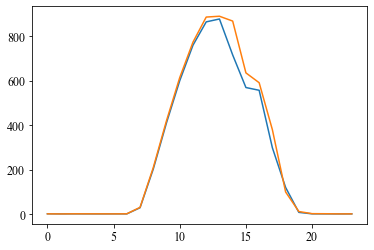

In [13]:
plt.plot(np.arange(24),py_DF_resample['2022-09-23 00:00:00':"2022-09-23 23:00:00	"].iloc[:,-2])
plt.plot(np.arange(24),py_DF_resample['2022-09-22 00:00:00':"2022-09-22 23:00:00	"].iloc[:,-2])

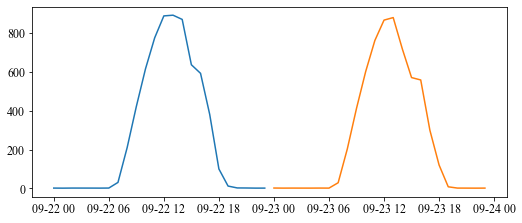

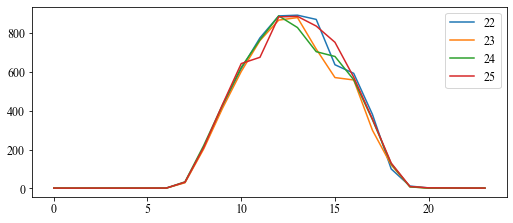

In [14]:
plt.figure(figsize=[8.5,3.5])
plt.plot(py_DF_resample['2022-09-22 00:00:00':"2022-09-22 23:00:00	"].iloc[:,-2])

#plt.figure(figsize=[8.5,3.5])
plt.plot(py_DF_resample['2022-09-23 00:00:00':"2022-09-23 23:00:00	"].iloc[:,-2])

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(24),py_DF_resample['2022-09-22 00:00:00':"2022-09-22 23:00:00	"].iloc[:,-2])

#plt.figure(figsize=[8.5,3.5])
plt.plot(np.arange(24),py_DF_resample['2022-09-23 00:00:00':"2022-09-23 23:00:00	"].iloc[:,-2])
plt.plot(np.arange(24),py_DF_resample['2022-09-24 00:00:00':"2022-09-24 23:00:00	"].iloc[:,-2])
plt.plot(np.arange(24),py_DF_resample['2022-09-25 00:00:00':"2022-09-25 23:00:00	"].iloc[:,-2])

ax.legend(['22','23','24','25'])
#plt.plot(np.arange(24),py_DF_resample['2022-09-26 00:00:00':"2022-09-26 23:00:00	"].iloc[:,-2])

In [8]:
for i in range(24):
    for j in range(12):
        os.system(r'C:\Radiance\bin\gensky 9 23 {0}:{1}CDT -a 30.6 -o 96.3 -m 90 > skies\gensky\0922_{0}_{1}.sky'.format(i,j*5))

In [11]:
os.system(r'C:\Radiance\bin\gendaylit 9 21 18 -a 30.6 -o 96.3 -m 90 -W 102.7 41.6 > C:\Radiance\bin\skies\9_21_18_2.sky')

0

#### Sep 22

In [29]:
for i in range(23):
    Dir_rad = py_DF_resample.iloc[7+i,-2]-py_DF_resample.iloc[7+i,-1]
    Dif_rad = py_DF_resample.iloc[7+i,-1]
    
    print(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting'.format(i,Dir_rad,Dif_rad,i+1))
    os.system(r'C:\Radiance\bin\gendaylit 9 22 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} > C:\Radiance\bin\skies\9_22_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))

D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting
D:\Users\fengf\Onedrive\Goog

#### Sep 23

In [30]:
for i in range(23):
    Dir_rad = py_DF_resample.iloc[31+i,-2]-py_DF_resample.iloc[31+i,-1]
    Dif_rad = py_DF_resample.iloc[31+i,-1]
    
    print(r'C:\Radiance\bin\gendaylit 9 23 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} > C:\Radiance\bin\skies\9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
    os.system(r'C:\Radiance\bin\gendaylit 9 23 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} > C:\Radiance\bin\skies\9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))

C:\Radiance\bin\gendaylit 9 23 +0.2 -a 30.6 -o 96.3 -m 90 -W 0.49373931916665637 1.1681461197222196 > C:\Radiance\bin\skies\9_23_1.sky
C:\Radiance\bin\gendaylit 9 23 +1.2 -a 30.6 -o 96.3 -m 90 -W 0.595661531814385 1.2272616885245906 > C:\Radiance\bin\skies\9_23_2.sky
C:\Radiance\bin\gendaylit 9 23 +2.2 -a 30.6 -o 96.3 -m 90 -W 0.5375638030008183 1.1765515618227234 > C:\Radiance\bin\skies\9_23_3.sky
C:\Radiance\bin\gendaylit 9 23 +3.2 -a 30.6 -o 96.3 -m 90 -W 0.5038602961110894 1.1645901013888897 > C:\Radiance\bin\skies\9_23_4.sky
C:\Radiance\bin\gendaylit 9 23 +4.2 -a 30.6 -o 96.3 -m 90 -W 0.6665280269519134 1.2294506135037477 > C:\Radiance\bin\skies\9_23_5.sky
C:\Radiance\bin\gendaylit 9 23 +5.2 -a 30.6 -o 96.3 -m 90 -W 0.5747982680555406 1.1142587852777766 > C:\Radiance\bin\skies\9_23_6.sky
C:\Radiance\bin\gendaylit 9 23 +6.2 -a 30.6 -o 96.3 -m 90 -W 14.045061326201859 15.298134612392227 > C:\Radiance\bin\skies\9_23_7.sky
C:\Radiance\bin\gendaylit 9 23 +7.2 -a 30.6 -o 96.3 -m 90 -W 1

In [ ]:
os.system(r'C:\Radiance\bin\gendaylit 9 21 18 -a 30.6 -o 96.3 -m 90 -W 102.7 41.6 > C:\Radiance\bin\skies\9_21_18_2.sky')

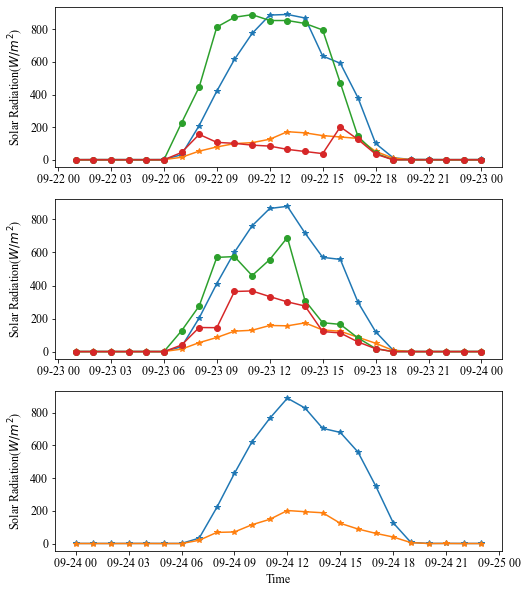

In [104]:
plt.figure(figsize=[8,10])
ax = plt.subplot(3,1,1)
plt.plot(py_DF_resample["2022-09-22 01:00:00":"2022-09-23 00:00:00"].iloc[:,-2],'-*')
plt.plot(py_DF_resample["2022-09-22 01:00:00":"2022-09-23 00:00:00"].iloc[:,-1],'-*')
plt.plot(py_DF_resample["2022-09-22 01:00:00":"2022-09-23 00:00:00"].iloc[:,-1].index,TMY_dat_23_1,'-o')
plt.plot(py_DF_resample["2022-09-22 01:00:00":"2022-09-23 00:00:00"].iloc[:,-1].index,TMY_dat_23_2,'-o')
#ax.set_xlabel('Time')
ax.set_ylabel('Solar Radiation($W/m^2$)')

ax = plt.subplot(3,1,2)
plt.plot(py_DF_resample["2022-09-23 01:00:00":"2022-09-24 00:00:00"].iloc[:,-2],'-*')
plt.plot(py_DF_resample["2022-09-23 01:00:00":"2022-09-24 00:00:00"].iloc[:,-1],'-*')
plt.plot(py_DF_resample["2022-09-23 01:00:00":"2022-09-24 00:00:00"].iloc[:,-2].index,TMY_dat_24_1,'-o')
plt.plot(py_DF_resample["2022-09-23 01:00:00":"2022-09-24 00:00:00"].iloc[:,-1].index,TMY_dat_24_2,'-o')
#ax.set_xlabel('Time')
ax.set_ylabel('Solar Radiation($W/m^2$)')

ax = plt.subplot(3,1,3)
plt.plot(py_DF_resample["2022-09-24 00:00:00":"2022-09-24 23:00:00"].iloc[:,-2],'-*')
plt.plot(py_DF_resample["2022-09-24 00:00:00":"2022-09-24 23:00:00"].iloc[:,-1],'-*')
ax.set_xlabel('Time')
ax.set_ylabel('Solar Radiation($W/m^2$)')

plt.savefig('Figure/SolarRad.jpg',dpi=300)

### process image

In [14]:
import PIL
# Importing Image class from PIL module
from PIL import Image

In [19]:
for i in range(15):
    crop_sky_image(r"D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Plot\FromGensky\sky_fc_{}.bmp".format(i+5))

In [20]:
for i in range(15):
    crop_sky_image(r"D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Plot\FromMea\0922\sky_fc_{}.bmp".format(i+5))

### Model calibration

In [119]:

function_inputs = [Wall_ref,Floor_ref,Table_ref,Win_trn] # Function inputs.
desired_output = 44 # Function output.

num_generations = 100 # Number of generations.
num_parents_mating = 10 # Number of solutions to be selected as parents in the mating pool.

sol_per_pop = 20 # Number of solutions in the population.
num_genes = len(function_inputs)

last_fitness = 0

def on_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       fitness_func=fitness_func,
                       on_generation=on_generation)

# Running the GA to optimize the parameters of the function.
ga_instance.run()

ga_instance.plot_fitness()

C:\ProgramData\Anaconda3\lib\site-packages\pygad\pygad.py:379: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


Generation = 1
Fitness    = 1.6829469382271944
Change     = 1.6829469382271944
Generation = 2
Fitness    = 1.8903781580707726
Change     = 0.20743121984357815


KeyboardInterrupt: 

In [149]:
for i in range(23):
    Dir_rad = py_DF_resample.iloc[31+i,-2]-py_DF_resample.iloc[31+i,-1]
    Dif_rad = py_DF_resample.iloc[31+i,-1]
    
    #print(r'C:\Radiance\bin\gendaylit 9 23 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
    os.system(r'C:\Radiance\bin\gendaylit 9 22 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} > skies/9_22_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
    
    # generate skyvec
    os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/9_22_{}.sky > skyVectors/0922/CSta_Per_{}.vec".format(i+1,i+1))

In [49]:
for i in range(23):
    Dir_rad = py_DF_resample.iloc[31+i,-2]-py_DF_resample.iloc[31+i,-1]
    Dif_rad = py_DF_resample.iloc[31+i,-1]
    
    #print(r'C:\Radiance\bin\gendaylit 9 23 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
    os.system(r'C:\Radiance\bin\gendaylit 9 23 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} > skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
    
    # generate skyvec
    os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/9_23_{}.sky > skyVectors/CSta_Per_{}.vec".format(i+1,i+1))

In [90]:
best_solution = [0.60466537, 0.25336843, 0.64529388, 0.87871997]
best_solution_fitness = [1.3659336635625732, 1.5512551151561178, 1.5353338798498486, 1.735665077580734, 1.801064440668883, 1.7680922901323264, 1.7898651209148206, 1.802446629200564, 1.8156183385088498, 1.8147985618738547, 1.8285977859724243, 1.7749744240471566, 1.8440346965509085, 1.8157968286348276, 1.8417937161670772, 1.8721455465100836, 1.8197713859086626, 1.8795197006781112, 1.803699444788948, 1.8608967815478754, 1.8670136566778912, 1.820581274897402, 1.8442068756436838, 1.8237372726479777, 1.845177502856663, 1.8549614526176312, 1.7496708348516403, 1.860357290121502, 1.8582312670314325, 1.8106816359729827, 1.8523807479012795]

In [91]:
## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room.rad > octrees/room3ph.oct')

# generate v matrix
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -ab 4 -ad 60000 -lw 0.000002 -n 16 -y 5 - objects/Glazing.rad -i octrees/room3ph.oct < points.txt > matrices/v.mtx')

# generate D matrix
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -ad 1000 -lw 0.001 -c 1000 -n 16 objects/Glazing.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/daylight.dmx')


0

In [ ]:

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

prediction = numpy.sum(numpy.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

# Saving the GA instance.
filename = 'genetic' # The filename to which the instance is saved. The name is without extension.
ga_instance.save(filename=filename)

# Loading the saved GA instance.
loaded_ga_instance = pygad.load(filename=filename)
loaded_ga_instance.plot_fitness()

In [ ]:
Wall_ref = 0.65
Floor_ref = 0.35
Table_ref = 0.65
Win_trn = 0.82

In [33]:
best_solution = [0.515219037429312, 0.2636680120916017, 0.5821363597832029, 0.8372866975259242]

In [157]:
best_solution = [0.60466537, 0.25336843, 0.64529388, 0.87871997]
best_solution_fitness = [1.3659336635625732, 1.5512551151561178, 1.5353338798498486, 1.735665077580734, 1.801064440668883, 1.7680922901323264, 1.7898651209148206, 1.802446629200564, 1.8156183385088498, 1.8147985618738547, 1.8285977859724243, 1.7749744240471566, 1.8440346965509085, 1.8157968286348276, 1.8417937161670772, 1.8721455465100836, 1.8197713859086626, 1.8795197006781112, 1.803699444788948, 1.8608967815478754, 1.8670136566778912, 1.820581274897402, 1.8442068756436838, 1.8237372726479777, 1.845177502856663, 1.8549614526176312, 1.7496708348516403, 1.860357290121502, 1.8582312670314325, 1.8106816359729827, 1.8523807479012795]

In [171]:
fitness_func(best_solution,0)

0.48587242368557326 0.6256301674871844


1.1115025911727576

In [15]:
simu_result_0923_3 = []
for i in range(13):
    simu_result_0923_3.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0923_3\3ph_{}.ill'.format(i+7)))
    
simu_result_0923_3 = pd.DataFrame(simu_result_0923_3)

In [20]:
130/simu_result_0923_3.iloc[:,1].mean()

0.2782492214477748

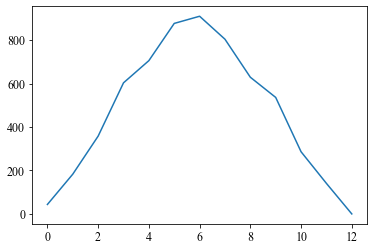

In [21]:
plt.plot(simu_result_0923_3.iloc[:,1])

In [19]:
simu_result_0923_3.iloc[:,1]

0      43.550298
1     182.928676
2     357.903565
3     603.107630
4     705.222186
5     876.442958
6     909.439002
7     803.718401
8     628.842931
9     535.989816
10    286.054992
11    140.491291
12      0.000000
Name: 1, dtype: float64

In [11]:
## w/o calibration
best_solution = [0.670466537, 0.305336843, 0.60529388, 0.87871997]
fitness_func(best_solution,0)

simu_result_0923_wo = []
for i in range(13):
    simu_result_0923_wo.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0923_3\3ph_{}.ill'.format(i+7)))
    
simu_result_0923_wo = pd.DataFrame(simu_result_0923_wo)

NameError: name 'dat_17_resample' is not defined

In [14]:
0.9446283031256374/2+0.937288068228073/2

0.9409581856768552

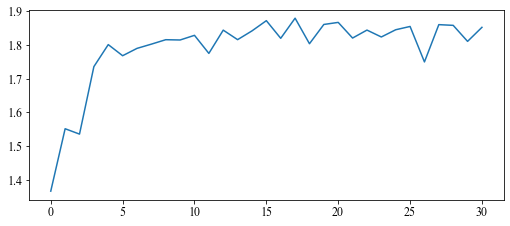

In [34]:
plt.figure(figsize =[8.5,3.5] )
plt.plot(best_solution_fitness)

[Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19')]

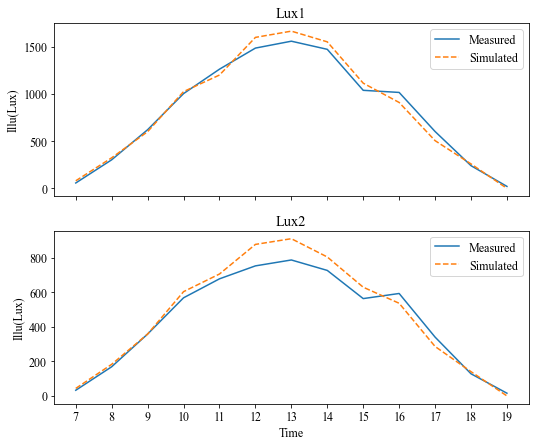

In [22]:
plt.figure(figsize=[8.5,3.5*2])
ax = plt.subplot(2,1,1)
plt.plot(np.arange(13),dat_17_resample.iloc[38:38+13,-1])
#plt.plot(np.arange(13),simu_result_0923.iloc[:,0])
plt.plot(np.arange(13),simu_result_0923_3.iloc[:,0],'--')

ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated','Simulated2'])
ax.set_title('Lux1')
ax.set_xticks(np.arange(13))
ax.set_xticklabels([])

ax = plt.subplot(2,1,2)
plt.plot(np.arange(13),dat_18_resample.iloc[38:38+13,-1])
#plt.plot(np.arange(13),simu_result_0923.iloc[:,0])
plt.plot(np.arange(13),simu_result_0923_3.iloc[:,1],'--')

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated','Simulated2'])
ax.set_title('Lux2')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
#plt.savefig(r'.\Figures\CaliResult\0923_sensor2.jpg',dpi=300)


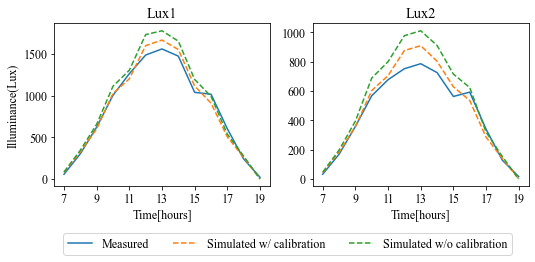

In [35]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(13),dat_17_resample.iloc[38:38+13,-1])
#plt.plot(np.arange(13),simu_result_0923.iloc[:,0])
plt.plot(np.arange(13),simu_result_0923_3.iloc[:,0],'--')
plt.plot(np.arange(13),simu_result_0923_wo.iloc[:,0],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
#ax.legend(['Measured','Simulated','Simulated2'])
ax.set_title('Lux1')
ax.set_xticks(np.arange(0,13,2))
ax.set_xticklabels(['{}'.format(i+7) for i in range(0,13,2)])

ax = plt.subplot(1,2,2)
plt.plot(np.arange(13),dat_18_resample.iloc[38:38+13,-1])
#plt.plot(np.arange(13),simu_result_0923.iloc[:,0])
plt.plot(np.arange(13),simu_result_0923_3.iloc[:,1],'--')
plt.plot(np.arange(13),simu_result_0923_wo.iloc[:,1],'--')

ax.set_xlabel('Time[hours]')
#ax.set_ylabel('Illuminance(Lux)')
ax.legend(['Measured','Simulated w/ calibration','Simulated w/o calibration'], ncol = 3,bbox_to_anchor=(0.95, -0.25))
ax.set_title('Lux2')
ax.set_xticks(np.arange(0,13,2))
ax.set_xticklabels(['{}'.format(i+7) for i in range(0,13,2)])
plt.savefig(r'.\Figures\CaliResult\0923_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')


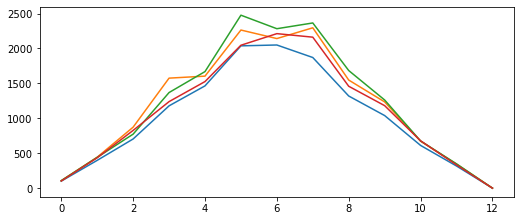

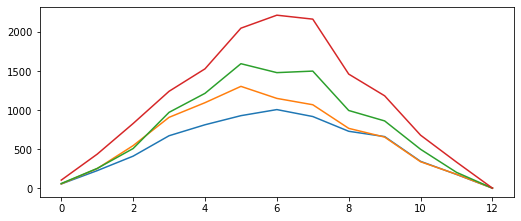

In [84]:
plt.figure(figsize=[8.5,3.5])
plt.plot(simu_result_0923.iloc[:,0])
plt.plot(simu_result_0923_1.iloc[:,0])
plt.plot(simu_result_0923_2.iloc[:,0])
plt.plot(simu_result_0923_3.iloc[:,0])

plt.figure(figsize=[8.5,3.5])
plt.plot(simu_result_0923.iloc[:,1])
plt.plot(simu_result_0923_1.iloc[:,1])
plt.plot(simu_result_0923_2.iloc[:,1])
plt.plot(simu_result_0923_3.iloc[:,0])

### `======Check results======`

#### Check optimization results

In [10]:
best_solution = [0.515219037429312, 0.2636680120916017, 0.5821363597832029, 0.8372866975259242]
best_solution_fitness = [1.3659336635625732, 1.5512551151561178, 1.5353338798498486, 1.735665077580734, 1.801064440668883, 1.7680922901323264, 1.7898651209148206, 1.802446629200564, 1.8156183385088498, 1.8147985618738547, 1.8285977859724243, 1.7749744240471566, 1.8440346965509085, 1.8157968286348276, 1.8417937161670772, 1.8721455465100836, 1.8197713859086626, 1.8795197006781112, 1.803699444788948, 1.8608967815478754, 1.8670136566778912, 1.820581274897402, 1.8442068756436838, 1.8237372726479777, 1.845177502856663, 1.8549614526176312, 1.7496708348516403, 1.860357290121502, 1.8582312670314325, 1.8106816359729827, 1.8523807479012795]

In [10]:
best_solution = [0.60466537, 0.25336843, 0.64529388, 0.87871997]
best_solution_fitness = [1.3659336635625732, 1.5512551151561178, 1.5353338798498486, 1.735665077580734, 1.801064440668883, 1.7680922901323264, 1.7898651209148206, 1.802446629200564, 1.8156183385088498, 1.8147985618738547, 1.8285977859724243, 1.7749744240471566, 1.8440346965509085, 1.8157968286348276, 1.8417937161670772, 1.8721455465100836, 1.8197713859086626, 1.8795197006781112, 1.803699444788948, 1.8608967815478754, 1.8670136566778912, 1.820581274897402, 1.8442068756436838, 1.8237372726479777, 1.845177502856663, 1.8549614526176312, 1.7496708348516403, 1.860357290121502, 1.8582312670314325, 1.8106816359729827, 1.8523807479012795]

In [89]:
Wall_ref,Floor_ref,Table_ref,Win_trn = best_solution[0],best_solution[1],best_solution[2],best_solution[3]

edit_Mat_properties(Wall_ref,Floor_ref,Table_ref,Win_trn)

## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room.rad > octrees/room3ph.oct')

# generate v matrix
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Glazing.rad -i octrees/room3ph.oct < points.txt > matrices/v.mtx')

# generate D matrix
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Glazing.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/daylight.dmx')


0

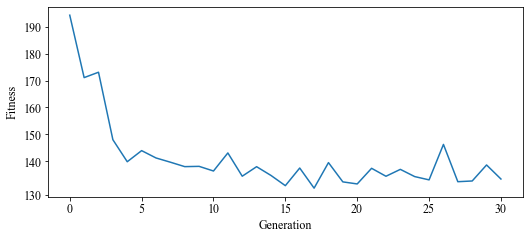

In [11]:
plt.figure(figsize =[8.5,3.5] )
ax = plt.subplot()
plt.plot([-x for x in best_solution_fitness ])
ax.set_yticks([-1.4,-1.48,-1.56,-1.64,-1.72,-1.8,-1.9])
ax.set_yticklabels([190,180,170,160,150,140,130])

ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')

plt.savefig('Figures/Fitness_plt.png',dpi =300)

#### 0922

##### `Timestep: 5min`

In [77]:
pyrano_DF = py_DF_5M['2022-09-22 06:00:00':'2022-09-22 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j])
        
        #print(r'C:\Radiance\bin\gendaylit 9 23 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 9 22 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/9_22_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.3,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/9_22_H{0}_{1}.sky > skyVectors/0922/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-09-22 06:00:00
hour: 6 minute: 5 2022-09-22 06:05:00
hour: 6 minute: 10 2022-09-22 06:10:00
hour: 6 minute: 15 2022-09-22 06:15:00
hour: 6 minute: 20 2022-09-22 06:20:00
hour: 6 minute: 25 2022-09-22 06:25:00
hour: 6 minute: 30 2022-09-22 06:30:00
hour: 6 minute: 35 2022-09-22 06:35:00
hour: 6 minute: 40 2022-09-22 06:40:00
hour: 6 minute: 45 2022-09-22 06:45:00
hour: 6 minute: 50 2022-09-22 06:50:00
hour: 6 minute: 55 2022-09-22 06:55:00
hour: 7 minute: 0 2022-09-22 07:00:00
hour: 7 minute: 5 2022-09-22 07:05:00
hour: 7 minute: 10 2022-09-22 07:10:00
hour: 7 minute: 15 2022-09-22 07:15:00
hour: 7 minute: 20 2022-09-22 07:20:00
hour: 7 minute: 25 2022-09-22 07:25:00
hour: 7 minute: 30 2022-09-22 07:30:00
hour: 7 minute: 35 2022-09-22 07:35:00
hour: 7 minute: 40 2022-09-22 07:40:00
hour: 7 minute: 45 2022-09-22 07:45:00
hour: 7 minute: 50 2022-09-22 07:50:00
hour: 7 minute: 55 2022-09-22 07:55:00
hour: 8 minute: 0 2022-09-22 08:00:00
hour: 8 minute: 5 2022-09-22 0

In [32]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        os.system('dctimestep matrices/v.mtx matrices/clear.xml matrices/daylight.dmx skyVectors/0922/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0922_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

#read flux data
simu_result_0922_5M = []
for i in range(14):
    for j in range(12):
        simu_result_0922_5M.append(read_result('results/0922_5M/3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_0922_5M = pd.DataFrame(simu_result_0922_5M)

In [74]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_0922_5M.iloc[:,0],dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1))
print("nmbe of sensr 1:",nmbe(simu_result_0922_5M.iloc[:,0],dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1))
print("r2 of sensr 1:",r2_score(simu_result_0922_5M.iloc[:,0],dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_0922_5M.iloc[:,1],dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1))
print("nmbe of sensr 2:",nmbe(simu_result_0922_5M.iloc[:,1],dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1))
print("r2 of sensr 2:",r2_score(simu_result_0922_5M.iloc[:,1],dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_0922_5M.iloc[:,2],dat_23_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_0922_5M.iloc[:,2],dat_23_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_0922_5M.iloc[:,2],dat_23_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_0922_5M.iloc[:,4],dat_22_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_0922_5M.iloc[:,4],dat_22_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_0922_5M.iloc[:,4],dat_22_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.18160494149922202
nmbe of sensr 1: 0.045517867107860766
r2 of sensr 1: 0.9445476599532506
cv_rmse of sensr 2: 0.23768175865625182
nmbe of sensr 2: 0.1268730055169249
r2 of sensr 2: 0.916031642457543
cv_rmse of sensr 3: 0.2293960686880135
nmbe of sensr 3: 0.05729177882078936
r2 of sensor 3: 0.9125949085872402
cv_rmse of sensor 5: 0.1366264098616826
nmbe of sensor 5: 0.024830281850800086
r2 of sensr 5: 0.9647865599229876


In [43]:
help(plt.subplot)

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs)
    Add a subplot to the current figure.
    
    Wrapper of `.Figure.add_subplot` with a difference in behavior
    explained in the notes section.
    
    Call signatures::
    
       subplot(nrows, ncols, index, **kwargs)
       subplot(pos, **kwargs)
       subplot(ax)
    
    Parameters
    ----------
    *args
        Either a 3-digit integer or three separate integers
        describing the position of the subplot. If the three
        integers are *nrows*, *ncols*, and *index* in order, the
        subplot will take the *index* position on a grid with *nrows*
        rows and *ncols* columns. *index* starts at 1 in the upper left
        corner and increases to the right.
    
        *pos* is a three digit integer, where the first digit is the
        number of rows, the second the number of columns, and the third
        the index of the subplot. i.e. fig.add_subplot(235) is the same as
       

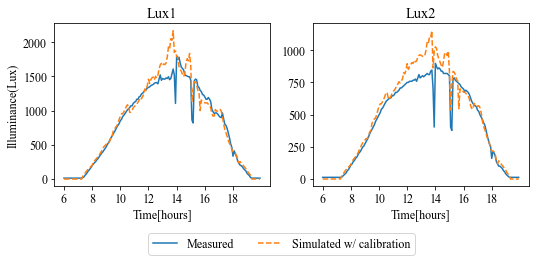

In [14]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1)
plt.plot(np.arange(168),simu_result_0922_5M.iloc[:,0],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1)
plt.plot(np.arange(168),simu_result_0922_5M.iloc[:,1],'--')

ax.set_xlabel('Time[hours]')
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.25))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0922_5M_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')

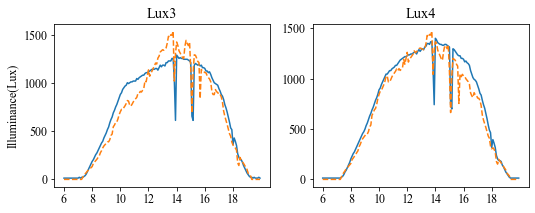

In [67]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_23_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1)
plt.plot(np.arange(168),simu_result_0922_5M.iloc[:,2],'--')

#ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux3')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_22_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1)
plt.plot(np.arange(168),simu_result_0922_5M.iloc[:,4],'--')

#ax.set_xlabel('Time[hours]')
ax.set_title('Lux4')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

#ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.35))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0922_5M_sensor3&4.jpg',dpi=300,bbox_inches = 'tight')

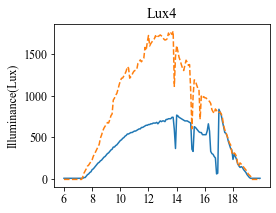

In [74]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_9_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1)
plt.plot(np.arange(168),simu_result_0922_5M.iloc[:,3],'--')

#ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux4')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0922_5M_sensor5.jpg',dpi=300,bbox_inches = 'tight')

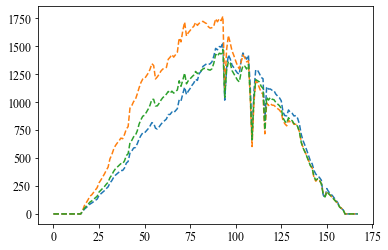

In [75]:
plt.plot(np.arange(168),simu_result_0922_5M.iloc[:,2],'--')
plt.plot(np.arange(168),simu_result_0922_5M.iloc[:,3],'--')
plt.plot(np.arange(168),simu_result_0922_5M.iloc[:,4],'--')

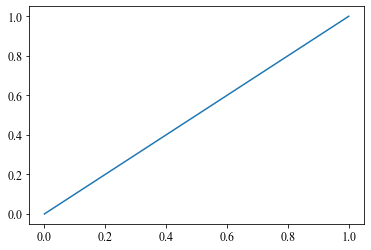

In [72]:
plt.plot([0,1],[0,1])

##### Timestep: 1 hour

In [146]:
for i in range(10):
    print(i,fitness_func(best_solution,0))

0 1.6725280669066
1 1.5068546661125226
2 1.812883446346404
3 1.5717245132442552
4 1.8242633999774411
5 1.6614262734866414
6 1.7758652635326735
7 1.7596159761039174
8 1.8551646770328638
9 1.6279761085801212


In [15]:
best_solution = [0.50468513, 0.26882482, 0.52277441, 0.81750907]
best_solution_fitness = [1.669706985476686, 1.6854525764750585, 1.8710172524064164, 1.8697979541836944, 1.8679619591687646, 1.9109490842986936, 1.9161973328085233, 1.9161035409673821, 1.9136369390394317, 1.927340622315179, 1.9230243651660952, 1.9192044889800197, 1.9293541272244379, 1.9282627683819749, 1.9312197943076455, 1.9365520809022718, 1.9332198672654175, 1.9344504185995484, 1.929204030739209, 1.933346596594984, 1.9356043432896488, 1.936150185794638, 1.9334800884756889, 1.9389217928471112, 1.9393075076989537, 1.9350165900274954, 1.9358906186506366, 1.9350891458488593, 1.9396078321881072, 1.9321073043500196, 1.9358272155010114]

In [48]:
simu_result_0922_1 = []
for i in range(13):
    simu_result_0922_1.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0922_1\3ph_{}.ill'.format(i+7)))
    
simu_result_0922_1 = pd.DataFrame(simu_result_0922_1)

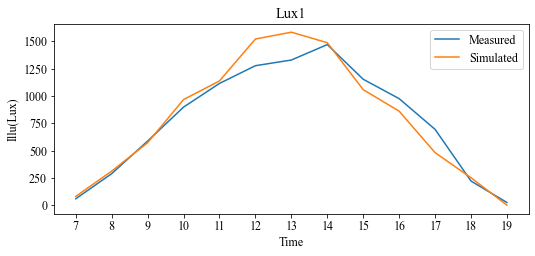

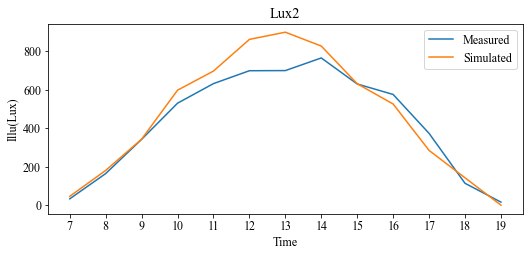

In [49]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(13),dat_17_resample.iloc[14:14+13,-1])
plt.plot(np.arange(13),simu_result_0922_1.iloc[:,0])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux1')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0922_sensor1.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(13),dat_18_resample.iloc[14:14+13,-1])
plt.plot(np.arange(13),simu_result_0922_1.iloc[:,1])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux2')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0922_sensor2.jpg',dpi=300)

#### 0923

##### Timestep: 5minutes

In [75]:
## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room.rad > octrees/room3ph.oct')

# generate v matrix
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Glazing.rad -i octrees/room3ph.oct < points.txt > matrices/v.mtx')

# generate D matrix
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Glazing.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/daylight.dmx')


0

In [61]:
pyrano_DF = py_DF_5M['2022-09-23 06:00:00':'2022-09-23 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j])
        
        #print(r'C:\Radiance\bin\gendaylit 9 23 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 9 23 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/9_23_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.3,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/9_23_H{0}_{1}.sky > skyVectors/0923/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-09-23 06:00:00
hour: 6 minute: 5 2022-09-23 06:05:00
hour: 6 minute: 10 2022-09-23 06:10:00
hour: 6 minute: 15 2022-09-23 06:15:00
hour: 6 minute: 20 2022-09-23 06:20:00
hour: 6 minute: 25 2022-09-23 06:25:00
hour: 6 minute: 30 2022-09-23 06:30:00
hour: 6 minute: 35 2022-09-23 06:35:00
hour: 6 minute: 40 2022-09-23 06:40:00
hour: 6 minute: 45 2022-09-23 06:45:00
hour: 6 minute: 50 2022-09-23 06:50:00
hour: 6 minute: 55 2022-09-23 06:55:00
hour: 7 minute: 0 2022-09-23 07:00:00
hour: 7 minute: 5 2022-09-23 07:05:00
hour: 7 minute: 10 2022-09-23 07:10:00
hour: 7 minute: 15 2022-09-23 07:15:00
hour: 7 minute: 20 2022-09-23 07:20:00
hour: 7 minute: 25 2022-09-23 07:25:00
hour: 7 minute: 30 2022-09-23 07:30:00
hour: 7 minute: 35 2022-09-23 07:35:00
hour: 7 minute: 40 2022-09-23 07:40:00
hour: 7 minute: 45 2022-09-23 07:45:00
hour: 7 minute: 50 2022-09-23 07:50:00
hour: 7 minute: 55 2022-09-23 07:55:00
hour: 8 minute: 0 2022-09-23 08:00:00
hour: 8 minute: 5 2022-09-23 0

In [83]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        os.system('dctimestep matrices/v.mtx matrices/clear.xml matrices/daylight.dmx skyVectors/0923/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0923_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))
    
                ### part 1 w blinds
        os.system('dctimestep matrices/Case2/v1.mtx matrices/clear.xml matrices/Case2/daylight1.dmx skyVectors/0923/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0923_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case2/v2.mtx matrices/clear.xml matrices/Case2/daylight2.dmx skyVectors/0923/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0923_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/0923_5M/3ph_H{0}_{1}_p1.ill + Results/0923_5M/3ph_H{0}_{1}_p2.ill > Results/0923_5M/3ph_H{0}_{1}_tot.ill'.format(i+6,j*5))

In [45]:
#read flux data
simu_result_0923_5M = []
for i in range(14):
    for j in range(12):
        simu_result_0923_5M.append(read_result('results/0923_5M/3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_0923_5M = pd.DataFrame(simu_result_0923_5M)

In [18]:
#read flux data
simu_result_0923_5M_tot = []
for i in range(14):
    for j in range(12):
        simu_result_0923_5M_tot.append(read_result('results/0923_5M/3ph_H{}_{}_tot.ill'.format(i+6,j*5)))

simu_result_0923_5M_tot = pd.DataFrame(simu_result_0923_5M_tot)

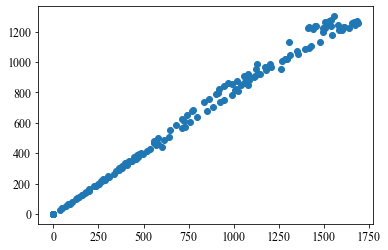

In [29]:
plt.scatter(simu_result_0923_5M.iloc[:,0],simu_result_0923_5M_tot.iloc[:,0])


NameError: name 'simu_result_0923_5M_tot' is not defined

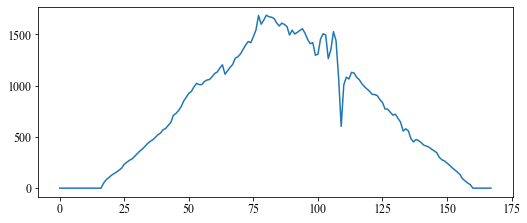

In [16]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
#plt.plot(np.arange(168),dat_17_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0923_5M.iloc[:,0])
plt.plot(np.arange(168),simu_result_0923_5M_tot.iloc[:,0])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Simulated_1','Simulated_p'])
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])

In [68]:
simu_result_0923_5M

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
163,0.0,0.0
164,0.0,0.0
165,0.0,0.0
166,0.0,0.0


NameError: name 'dat_17_5M' is not defined

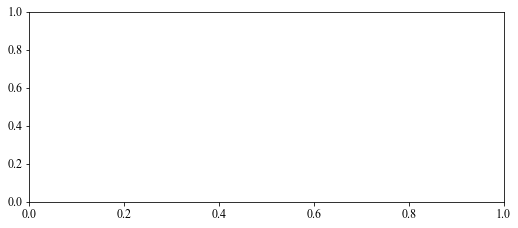

In [17]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_17_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0923_5M.iloc[:,0])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0923_5M_sensor1.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_18_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0923_5M.iloc[:,1])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0923_5M_sensor2.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_22_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0923_5M.iloc[:,4])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux5')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0923_5M_sensor5.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_23_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0923_5M.iloc[:,2])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux3')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0923_5M_sensor3.jpg',dpi=300)


In [32]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_0923_5M.iloc[:,0],dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("nmbe of sensr 1:",nmbe(simu_result_0923_5M.iloc[:,0],dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("r2 of sensr 1:",r2_score(simu_result_0923_5M.iloc[:,0],dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_0923_5M.iloc[:,1],dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("cv_nmbe of sensr 2:",nmbe(simu_result_0923_5M.iloc[:,1],dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("r2 of sensr 2:",r2_score(simu_result_0923_5M.iloc[:,1],dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_0923_5M.iloc[:,2],dat_23_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_0923_5M.iloc[:,2],dat_23_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_0923_5M.iloc[:,2],dat_23_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_0923_5M.iloc[:,4],dat_22_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_0923_5M.iloc[:,4],dat_22_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_0923_5M.iloc[:,4],dat_22_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.13823188679206014
nmbe of sensr 1: -0.03254866369312725
r2 of sensr 1: 0.9633120492085191
cv_rmse of sensr 2: 0.23644560178633325
cv_nmbe of sensr 2: 0.08050100387290224
r2 of sensr 2: 0.9130063548108819
cv_rmse of sensr 3: 0.25195126654149963
nmbe of sensr 3: -0.05541003667343289
r2 of sensor 3: 0.8808920595477867
cv_rmse of sensor 5: 0.15611308843439473
nmbe of sensor 5: -0.0764189719056307
r2 of sensr 5: 0.9434891826605494


In [55]:
dat_17_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[:,3]

Date Time, GMT-05:00
2022-09-23 06:00:00      11.800000
2022-09-23 07:00:00      57.150000
2022-09-23 08:00:00     302.875000
2022-09-23 09:00:00     621.500000
2022-09-23 10:00:00    1003.866667
2022-09-23 11:00:00    1262.725000
2022-09-23 12:00:00    1486.091667
2022-09-23 13:00:00    1559.025000
2022-09-23 14:00:00    1472.958333
2022-09-23 15:00:00    1038.700000
2022-09-23 16:00:00    1016.341667
2022-09-23 17:00:00     602.458333
2022-09-23 18:00:00     240.450000
2022-09-23 19:00:00      21.000000
Freq: H, Name: Intensity, Lux (LGR S/N: 10392512, SEN S/N: 10392512), dtype: float64

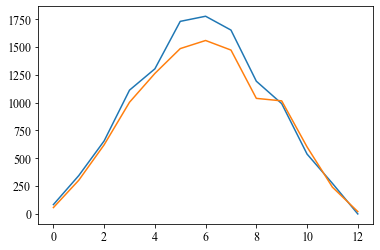

In [57]:
plt.plot(simu_result_0923_wo.iloc[:,0])
plt.plot(np.arange(13),dat_17_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3])

In [61]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_0923_3.iloc[:,0],dat_17_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("nmbe of sensr 1:",nmbe(simu_result_0923_3.iloc[:,0],dat_17_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("r2 of sensr 1:",r2_score(simu_result_0923_3.iloc[:,0],dat_17_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_0923_3.iloc[:,1],dat_18_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("cv_nmbe of sensr 2:",nmbe(simu_result_0923_3.iloc[:,1],dat_18_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("r2 of sensr 2:",r2_score(simu_result_0923_3.iloc[:,1],dat_18_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_0923_3.iloc[:,2],dat_23_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_0923_3.iloc[:,2],dat_23_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("r2 of sensor 3:",r2_score(simu_result_0923_3.iloc[:,2],dat_23_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_0923_3.iloc[:,4],dat_22_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_0923_3.iloc[:,4],dat_22_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("r2 of sensr 5:",r2_score(simu_result_0923_3.iloc[:,4],dat_22_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.0849400790800086
nmbe of sensr 1: 0.014232349120624696
r2 of sensr 1: 0.9844122149460008
cv_rmse of sensr 2: 0.140988896110643
cv_nmbe of sensr 2: 0.06385685149650777
r2 of sensr 2: 0.9588908913269313
cv_rmse of sensr 3: 0.1481803399122136
nmbe of sensr 3: -0.06054770503101618
r2 of sensor 3: 0.939914418533242
cv_rmse of sensor 5: 0.11899441193715606
nmbe of sensor 5: -0.0871870594339027
r2 of sensr 5: 0.9582099640634311


In [59]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_0923_wo.iloc[:,0],dat_17_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("nmbe of sensr 1:",nmbe(simu_result_0923_wo.iloc[:,0],dat_17_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("r2 of sensr 1:",r2_score(simu_result_0923_wo.iloc[:,0],dat_17_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_0923_wo.iloc[:,1],dat_18_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("cv_nmbe of sensr 2:",nmbe(simu_result_0923_wo.iloc[:,1],dat_18_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("r2 of sensr 2:",r2_score(simu_result_0923_wo.iloc[:,1],dat_18_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_0923_wo.iloc[:,2],dat_23_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_0923_wo.iloc[:,2],dat_23_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("r2 of sensor 3:",r2_score(simu_result_0923_wo.iloc[:,2],dat_23_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_0923_wo.iloc[:,4],dat_22_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_0923_wo.iloc[:,4],dat_22_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))
print("r2 of sensr 5:",r2_score(simu_result_0923_wo.iloc[:,4],dat_22_resample['2022-09-23 06:00:00':'2022-09-23 19:00:00'].iloc[1:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.14595027738750957
nmbe of sensr 1: 0.09114235581839888
r2 of sensr 1: 0.9601500544423293
cv_rmse of sensr 2: 0.27760974771355545
cv_nmbe of sensr 2: 0.19808074070019496
r2 of sensr 2: 0.8752444956445848
cv_rmse of sensr 3: 0.1724017462947052
nmbe of sensr 3: 0.03443926992681696
r2 of sensor 3: 0.9340723611832962
cv_rmse of sensor 5: 0.0930243223465942
nmbe of sensor 5: 0.0007577534001642623
r2 of sensr 5: 0.978839024222056


In [35]:
for i in range(23):
        ## calcualte View matrices
        os.system('dctimestep matrices/v.mtx matrices/clear.xml matrices/daylight.dmx skyVectors/0922/CSta_Per_{}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0922_1/3ph_{}.ill'.format(i+1,i+1))
 

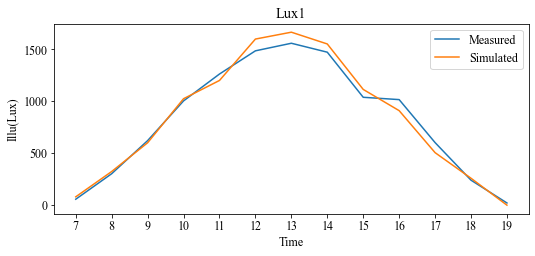

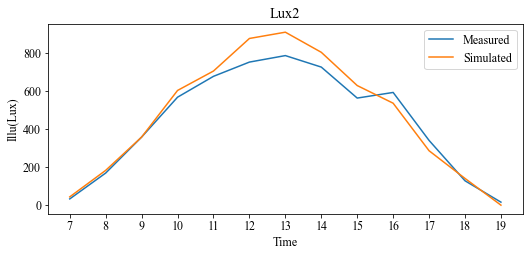

In [37]:
simu_result_0923_3 = []
for i in range(13):
    simu_result_0923_3.append(read_result(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Results\0923_3\3ph_{}.ill'.format(i+7)))

simu_result_0923_3 = pd.DataFrame(simu_result_0923_3)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(13),dat_17_resample.iloc[38:38+13,-1])
#plt.plot(np.arange(13),simu_result_0923.iloc[:,0])
plt.plot(np.arange(13),simu_result_0923_3.iloc[:,0])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated','Simulated2'])
ax.set_title('Lux1')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0923_sensor1.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(13),dat_18_resample.iloc[38:38+13,-1])
#plt.plot(np.arange(13),simu_result_0923.iloc[:,1])
plt.plot(np.arange(13),simu_result_0923_3.iloc[:,1])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated','Simulated2'])
ax.set_title('Lux2')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(['{}'.format(i+7) for i in range(13)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0923_sensor2.jpg',dpi=300)

In [38]:
def rmse(y_pred,y_mea):
    re = sum([(y_pred[i]-y_mea[i])**2 for i in range(len(y_pred))])/len(y_pred)
    return re**(1/2)

In [40]:
rmse(dat_18_resample.iloc[38:38+13,-1],simu_result_0923_3.iloc[:,1]) + rmse(dat_17_resample.iloc[38:38+13,-1],simu_result_0923_3.iloc[:,0])

131.7323084350336

#### 09/24

In [81]:
pyrano_DF = py_DF_5M['2022-09-24 06:00:00':'2022-09-24 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j])
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 9 24 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/9_24_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.3,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/9_24_H{0}_{1}.sky > skyVectors/0924/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-09-24 06:00:00
hour: 6 minute: 5 2022-09-24 06:05:00
hour: 6 minute: 10 2022-09-24 06:10:00
hour: 6 minute: 15 2022-09-24 06:15:00
hour: 6 minute: 20 2022-09-24 06:20:00
hour: 6 minute: 25 2022-09-24 06:25:00
hour: 6 minute: 30 2022-09-24 06:30:00
hour: 6 minute: 35 2022-09-24 06:35:00
hour: 6 minute: 40 2022-09-24 06:40:00
hour: 6 minute: 45 2022-09-24 06:45:00
hour: 6 minute: 50 2022-09-24 06:50:00
hour: 6 minute: 55 2022-09-24 06:55:00
hour: 7 minute: 0 2022-09-24 07:00:00
hour: 7 minute: 5 2022-09-24 07:05:00
hour: 7 minute: 10 2022-09-24 07:10:00
hour: 7 minute: 15 2022-09-24 07:15:00
hour: 7 minute: 20 2022-09-24 07:20:00
hour: 7 minute: 25 2022-09-24 07:25:00
hour: 7 minute: 30 2022-09-24 07:30:00
hour: 7 minute: 35 2022-09-24 07:35:00
hour: 7 minute: 40 2022-09-24 07:40:00
hour: 7 minute: 45 2022-09-24 07:45:00
hour: 7 minute: 50 2022-09-24 07:50:00
hour: 7 minute: 55 2022-09-24 07:55:00
hour: 8 minute: 0 2022-09-24 08:00:00
hour: 8 minute: 5 2022-09-24 0

In [119]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        os.system('dctimestep matrices/v.mtx matrices/clear.xml matrices/daylight.dmx skyVectors/0924/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0924_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))


In [75]:
#read flux data
simu_result_0924_5M = []
for i in range(14):
    for j in range(12):
        simu_result_0924_5M.append(read_result('results/0924_5M/3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_0924_5M = pd.DataFrame(simu_result_0924_5M)

NameError: name 'dat_17_5M' is not defined

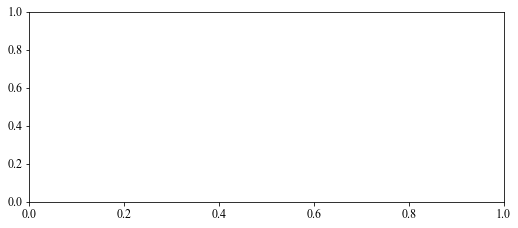

In [76]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_17_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0924_5M.iloc[:,0])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0924_5M_sensor1.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_18_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0924_5M.iloc[:,1])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0924_5M_sensor2.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_22_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0924_5M.iloc[:,4])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux5')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0924_5M_sensor5.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_23_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0924_5M.iloc[:,2])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux3')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0924_5M_sensor3.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(py_DF_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,-2])
ax.set_ylabel('Total radiation')

In [ ]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_0923_5M.iloc[:,0],dat_17_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("r2 of sensr 1:",r2_score(simu_result_0923_5M.iloc[:,0],dat_17_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_0923_5M.iloc[:,1],dat_18_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("r2 of sensr 2:",r2_score(simu_result_0923_5M.iloc[:,1],dat_18_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_0923_5M.iloc[:,2],dat_23_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_0923_5M.iloc[:,2],dat_23_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_0923_5M.iloc[:,4],dat_22_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_0923_5M.iloc[:,4],dat_22_5M['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]))

In [114]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_0924_5M.iloc[:,0],dat_17_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))
print("nmbe of sensr 1:",nmbe(simu_result_0924_5M.iloc[:,0],dat_17_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))
print("r2 of sensr 1:",r2_score(simu_result_0924_5M.iloc[:,0],dat_17_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_0924_5M.iloc[:,1],dat_18_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))
print("nmbe of sensr 2:",nmbe(simu_result_0924_5M.iloc[:,1],dat_18_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))
print("r2 of sensr 2:",r2_score(simu_result_0924_5M.iloc[:,1],dat_18_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_0924_5M.iloc[:,2],dat_23_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_0924_5M.iloc[:,2],dat_23_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_0924_5M.iloc[:,2],dat_23_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_0924_5M.iloc[:,4],dat_22_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_0924_5M.iloc[:,4],dat_22_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_0924_5M.iloc[:,4],dat_22_5M['2022-09-24 06:00:00':'2022-09-24 19:55:00'].iloc[:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.3025975923266091
nmbe of sensr 1: 0.09340895531137822
r2 of sensr 1: 0.8822125014598475
cv_rmse of sensr 2: 0.267770216164515
nmbe of sensr 2: 0.06016081033691052
r2 of sensr 2: 0.8906842116933857
cv_rmse of sensr 3: 0.2346362198962292
nmbe of sensr 3: -0.06833393462324194
r2 of sensor 3: 0.8849153258631519
cv_rmse of sensor 5: 0.2018958051341198
nmbe of sensor 5: -0.08986606663424763
r2 of sensr 5: 0.9071471216640802


#### 09/25

In [82]:
pyrano_DF = py_DF_5M['2022-09-25 06:00:00':'2022-09-25 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j])
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 9 25 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/9_25_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.3,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/9_25_H{0}_{1}.sky > skyVectors/0925/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-09-25 06:00:00
hour: 6 minute: 5 2022-09-25 06:05:00
hour: 6 minute: 10 2022-09-25 06:10:00
hour: 6 minute: 15 2022-09-25 06:15:00
hour: 6 minute: 20 2022-09-25 06:20:00
hour: 6 minute: 25 2022-09-25 06:25:00
hour: 6 minute: 30 2022-09-25 06:30:00
hour: 6 minute: 35 2022-09-25 06:35:00
hour: 6 minute: 40 2022-09-25 06:40:00
hour: 6 minute: 45 2022-09-25 06:45:00
hour: 6 minute: 50 2022-09-25 06:50:00
hour: 6 minute: 55 2022-09-25 06:55:00
hour: 7 minute: 0 2022-09-25 07:00:00
hour: 7 minute: 5 2022-09-25 07:05:00
hour: 7 minute: 10 2022-09-25 07:10:00
hour: 7 minute: 15 2022-09-25 07:15:00
hour: 7 minute: 20 2022-09-25 07:20:00
hour: 7 minute: 25 2022-09-25 07:25:00
hour: 7 minute: 30 2022-09-25 07:30:00
hour: 7 minute: 35 2022-09-25 07:35:00
hour: 7 minute: 40 2022-09-25 07:40:00
hour: 7 minute: 45 2022-09-25 07:45:00
hour: 7 minute: 50 2022-09-25 07:50:00
hour: 7 minute: 55 2022-09-25 07:55:00
hour: 8 minute: 0 2022-09-25 08:00:00
hour: 8 minute: 5 2022-09-25 0

In [122]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        os.system('dctimestep matrices/v.mtx matrices/clear.xml matrices/daylight.dmx skyVectors/0925/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0925_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))


In [123]:
#read flux data
simu_result_0925_5M = []
for i in range(14):
    for j in range(12):
        simu_result_0925_5M.append(read_result('results/0925_5M/3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_0925_5M = pd.DataFrame(simu_result_0925_5M)

Text(0, 0.5, 'Total radiation')

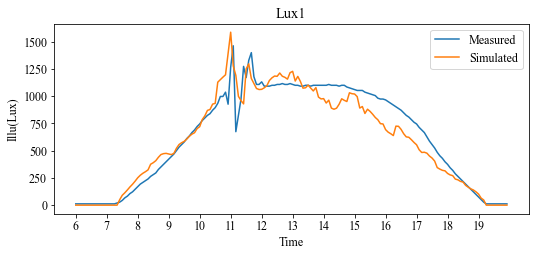

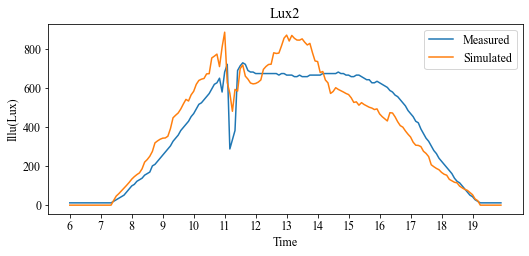

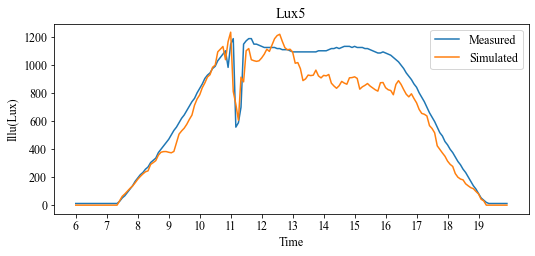

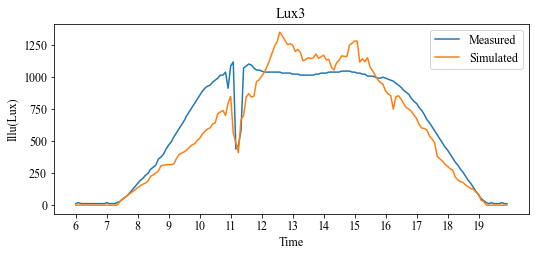

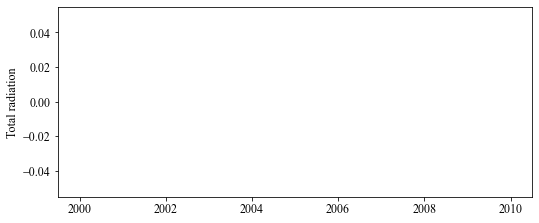

In [124]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_17_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0925_5M.iloc[:,0])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0925_5M_sensor1.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_18_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0925_5M.iloc[:,1])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0925_5M_sensor2.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_22_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0925_5M.iloc[:,4])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux5')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0925_5M_sensor5.jpg',dpi=300)

plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(np.arange(168),dat_23_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3])
plt.plot(np.arange(168),simu_result_0925_5M.iloc[:,2])

ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
ax.legend(['Measured','Simulated'])
ax.set_title('Lux3')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0925_5M_sensor3.jpg',dpi=300)


plt.figure(figsize=[8.5,3.5])
ax = plt.subplot()
plt.plot(py_DF_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,-2])
ax.set_ylabel('Total radiation')

In [115]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_0925_5M.iloc[:,0],dat_17_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))
print("nmbe of sensr 1:",nmbe(simu_result_0925_5M.iloc[:,0],dat_17_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))
print("r2 of sensr 1:",r2_score(simu_result_0925_5M.iloc[:,0],dat_17_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_0925_5M.iloc[:,1],dat_18_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))
print("nmbe of sensr 2:",nmbe(simu_result_0925_5M.iloc[:,1],dat_18_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))
print("r2 of sensr 2:",r2_score(simu_result_0925_5M.iloc[:,1],dat_18_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_0925_5M.iloc[:,2],dat_23_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_0925_5M.iloc[:,2],dat_23_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_0925_5M.iloc[:,2],dat_23_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_0925_5M.iloc[:,4],dat_22_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_0925_5M.iloc[:,4],dat_22_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_0925_5M.iloc[:,4],dat_22_5M['2022-09-25 06:00:00':'2022-09-25 19:55:00'].iloc[:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.1667673413781306
nmbe of sensr 1: -0.025035234850373872
r2 of sensr 1: 0.9392599352663502
cv_rmse of sensr 2: 0.16656910403947767
nmbe of sensr 2: -0.047207036316658395
r2 of sensr 2: 0.9377904953213073
cv_rmse of sensr 3: 0.19609080971689297
nmbe of sensr 3: -0.11434194328219752
r2 of sensor 3: 0.9045554998523884
cv_rmse of sensor 5: 0.20401325887795413
nmbe of sensor 5: -0.1495081568393675
r2 of sensr 5: 0.8808088144182263


### `Testing 2: blinds=50, horizontal`

#### A quick peek of the dataset

In [19]:
path = r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Case2_Blind50_VerticalAndHorizon'

In [20]:
path = r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Case2_Blind50_VerticalAndHorizon'
dat_09 = pd.read_csv(path+'\\'+'Sensor_09.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_09=dat_09.iloc[:,:-2]
dat_09 = dat_09.set_index("Date Time, GMT-05:00")

dat_17 = pd.read_csv(path+'\\'+'Sensor_17.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_17=dat_17.iloc[:,:-2]
dat_17 = dat_17.set_index("Date Time, GMT-05:00")

dat_18 = pd.read_csv(path+'\\'+'Sensor_18.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_18=dat_18.iloc[:,:-3]
dat_18 = dat_18.set_index("Date Time, GMT-05:00")

dat_19 = pd.read_csv(path+'\\'+'Sensor_19.csv',header=1)
dat_20 = pd.read_csv(path+'\\'+'Sensor_20.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_20=dat_20.iloc[:-3,:-3]
dat_20 = dat_20.set_index("Date Time, GMT-05:00")

dat_22 = pd.read_csv(path+'\\'+'Sensor_22.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_22=dat_22.iloc[:,:-3]
dat_22 = dat_22.set_index("Date Time, GMT-05:00")

dat_23 = pd.read_csv(path+'\\'+'Sensor_23.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_23=dat_23.iloc[:,:-3]
dat_23 = dat_23.set_index("Date Time, GMT-05:00")


dat_17_resample = dat_17.resample('1H').mean()
dat_17_resample = dat_17.resample('1H').mean()
dat_18_resample = dat_18.resample('1H').mean()
dat_20_resample = dat_20.resample('1H').mean()
dat_23_resample = dat_23.resample('1H').mean()
dat_22_resample = dat_22.resample('1H').mean()

# resample to 5Minute
dat_17_5M_Case2 = dat_17.resample('5T').mean()
dat_09_5M_Case2 = dat_09.resample('5T').mean()
dat_18_5M_Case2 = dat_18.resample('5T').mean()
dat_20_5M_Case2 = dat_20.resample('5T').mean()
dat_22_5M_Case2 = dat_22.resample('5T').mean()
dat_23_5M_Case2 = dat_23.resample('5T').mean()

In [21]:
py_DF = pd.read_csv(path+'\\'+'pyranometer.csv',parse_dates=[2],date_parser = lambda x:time.strftime("%m/%d/%Y %H:%M:%S",time.strptime(x,'%m/%d/%Y %H:%M:%S')))
py_DF = py_DF.set_index('Datetime')

py_DF.to_csv(path+'\\'+'Pyranometer_af.csv')

## resample 
py_DF_resample = py_DF.resample('1H').mean()
py_DF_resample.to_csv(path+'\\'+'pyranometer_Hourly.csv')

# calc Total and diffuse
py_DF_resample['Total(W/m2)'] = py_DF_resample['CH1'].apply(lambda x:x*1000)
py_DF_resample['Diffuse(W/m2)'] = py_DF_resample['CH2'].apply(lambda x:x*1000)


#### 5min ########

## resample 
py_DF_5M = py_DF.resample('5T').mean()
py_DF_5M.to_csv('pyranometer_5M.csv')
# calc Total and diffuse
py_DF_5M['Total(W/m2)'] = py_DF_5M['CH1'].apply(lambda x:x*1000)
py_DF_5M['Diffuse(W/m2)'] = py_DF_5M['CH2'].apply(lambda x:x*1000)

## resample 
py_DF_1M = py_DF.resample('1T').mean()
py_DF_1M.to_csv('pyranometer_1M.csv')
# calc Total and diffuse
py_DF_1M['Total(W/m2)'] = py_DF_1M['CH1'].apply(lambda x:x*1000)
py_DF_1M['Diffuse(W/m2)'] = py_DF_1M['CH2'].apply(lambda x:x*1000)

In [22]:
py_DF_2 = pd.read_csv(path+'\\'+'pyranometer2.csv',parse_dates=[2],date_parser = lambda x:time.strftime("%m/%d/%Y %H:%M:%S",time.strptime(x,'%m/%d/%Y %H:%M:%S')))
py_DF_2 = py_DF_2.set_index('Datetime')

## resample 
py_DF_resample2 = py_DF_2.resample('1H').mean()


# calc Total and diffuse
py_DF_resample2['Total(W/m2)'] = py_DF_resample2['CH1'].apply(lambda x:x*1000)
py_DF_resample2['Diffuse(W/m2)'] = py_DF_resample2['CH2'].apply(lambda x:x*1000)



#### 5min ########

## resample 
py_DF_5M_2 = py_DF_2.resample('5T').mean()
py_DF_5M_2.to_csv('pyranometer_5M.csv')
# calc Total and diffuse
py_DF_5M_2['Total(W/m2)'] = py_DF_5M_2['CH1'].apply(lambda x:x*1000)
py_DF_5M_2['Diffuse(W/m2)'] = py_DF_5M_2['CH2'].apply(lambda x:x*1000)

## resample 
py_DF_1M_2 = py_DF_2.resample('1T').mean()
py_DF_1M_2.to_csv('pyranometer_1M.csv')
# calc Total and diffuse
py_DF_1M_2['Total(W/m2)'] = py_DF_1M_2['CH1'].apply(lambda x:x*1000)
py_DF_1M_2['Diffuse(W/m2)'] = py_DF_1M_2['CH2'].apply(lambda x:x*1000)


py_DF_1M = py_DF_1M.truncate(after='2022-10-02 16:00:00').append(py_DF_1M_2.truncate(before='2022-10-02 16:01:00',after='2022-10-04 15:00:00'))
py_DF_5M = py_DF_5M.truncate(after='2022-10-02 16:00:00').append(py_DF_5M_2.truncate(before='2022-10-02 16:01:00',after='2022-10-04 15:00:00'))

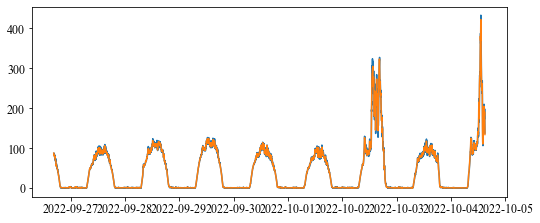

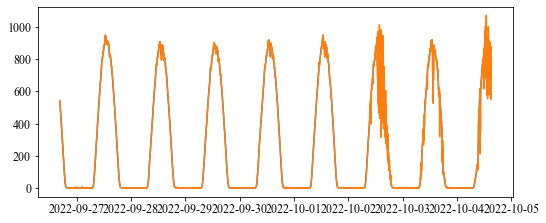

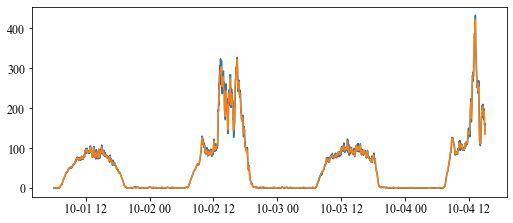

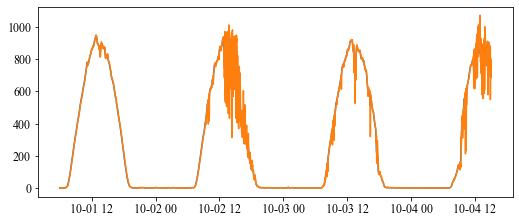

In [151]:
plt.figure(figsize=[8.5,3.5])
plt.plot(py_DF_1M.iloc[:,-1])
plt.plot(py_DF_5M.iloc[:,-1])

plt.figure(figsize=[8.5,3.5])
plt.plot(py_DF_5M.iloc[:,-2])
plt.plot(py_DF_1M.iloc[:,-2])


plt.figure(figsize=[8.5,3.5])
plt.plot(py_DF_1M['2022-10-01 06:00:00':].iloc[:,-1])
plt.plot(py_DF_5M['2022-10-01 06:00:00':].iloc[:,-1])

plt.figure(figsize=[8.5,3.5])
plt.plot(py_DF_5M['2022-10-01 06:00:00':].iloc[:,-2])
plt.plot(py_DF_1M['2022-10-01 06:00:00':].iloc[:,-2])

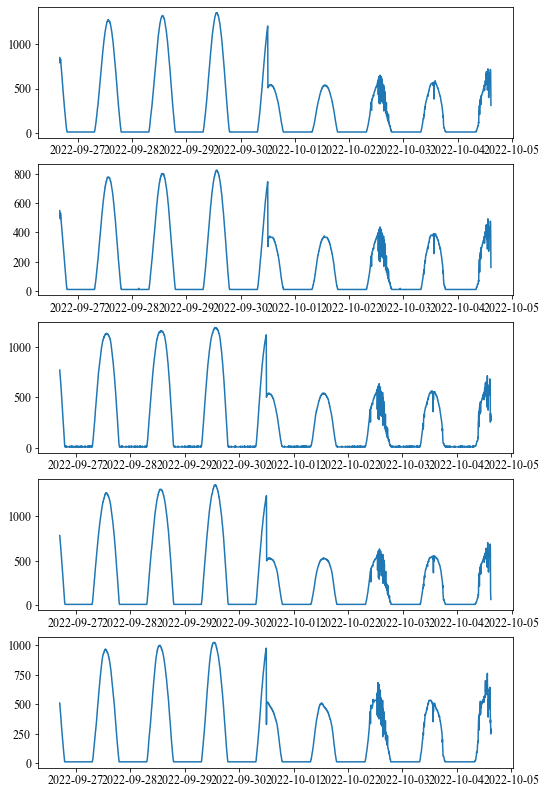

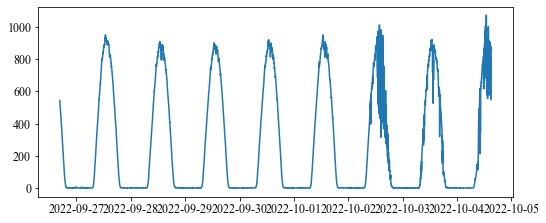

In [152]:
plt.figure(figsize = [8.5,3.5*4])
n_rows = 5

ax = plt.subplot(n_rows,1,1)
plt.plot(dat_17_5M_Case2.iloc[:,-1])

ax = plt.subplot(n_rows,1,2)
plt.plot(dat_18_5M_Case2.iloc[:,-1])

ax = plt.subplot(n_rows,1,3)
plt.plot(dat_23_5M_Case2.iloc[:,-1])

ax = plt.subplot(n_rows,1,4)
plt.plot(dat_22_5M_Case2.iloc[:,-1])

ax = plt.subplot(n_rows,1,5)
plt.plot(dat_20_5M_Case2.iloc[:,-1])

plt.figure(figsize = [8.5,3.5])
plt.plot(py_DF_1M['Total(W/m2)'] )

#### 9/27

In [209]:
## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V1.rad > octrees/roomV1_3ph.oct')
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V2.rad > octrees/roomV2_3ph.oct')

# generate v matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx1.rad -i octrees/roomV1_3ph.oct < points.txt > matrices/Case2/v1.mtx')
# generate v matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx2.rad -i octrees/roomV2_3ph.oct < points.txt > matrices/Case2/v2.mtx')


# generate D matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx1.rad skyDomes/skyglow.rad -i octrees/roomV1_3ph.oct > matrices/Case2/daylight1.dmx')

# generate D matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx2.rad skyDomes/skyglow.rad -i octrees/roomV2_3ph.oct > matrices/Case2/daylight2.dmx')

0

In [93]:
### generate sky

pyrano_DF = py_DF_5M['2022-09-27 06:00:00':'2022-09-27 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j],Dir_rad,Dif_rad)
        
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 9 27 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/0927/09_27_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.27,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/0927/09_27_H{0}_{1}.sky > skyVectors/0927/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-09-27 06:00:00 0.9836490566666656 1.1475394533333347
hour: 6 minute: 5 2022-09-27 06:05:00 0.9683307666666674 1.1814583966666676
hour: 6 minute: 10 2022-09-27 06:10:00 1.132454646666669 1.1923999600000001
hour: 6 minute: 15 2022-09-27 06:15:00 0.6203882566666687 0.9079186033333331
hour: 6 minute: 20 2022-09-27 06:20:00 0.38186157666666953 0.9845097366666669
hour: 6 minute: 25 2022-09-27 06:25:00 0.37639079333333436 0.8893178733333329
hour: 6 minute: 30 2022-09-27 06:30:00 0.48252423666666644 1.086266496666667
hour: 6 minute: 35 2022-09-27 06:35:00 0.5974109300000011 0.8707171599999998
hour: 6 minute: 40 2022-09-27 06:40:00 0.565376605351172 0.8578214581939798
hour: 6 minute: 45 2022-09-27 06:45:00 0.3162120533333338 0.8510222999999998
hour: 6 minute: 50 2022-09-27 06:50:00 0.28557558666666694 0.9287076133333338
hour: 6 minute: 55 2022-09-27 06:55:00 0.48908919333333445 0.8772821233333336
hour: 7 minute: 0 2022-09-27 07:00:00 1.0427336433333347 0.9221426600000002


hour: 15 minute: 5 2022-09-27 15:05:00 697.3509247333327 106.48003547
hour: 15 minute: 10 2022-09-27 15:10:00 684.3654626699989 101.70950253666656
hour: 15 minute: 15 2022-09-27 15:15:00 673.4950021900003 103.11330843999983
hour: 15 minute: 20 2022-09-27 15:20:00 661.5697783433308 98.57364314666681
hour: 15 minute: 25 2022-09-27 15:25:00 652.2191020766652 101.10771516666654
hour: 15 minute: 30 2022-09-27 15:30:00 645.3368504033339 98.61303279333343
hour: 15 minute: 35 2022-09-27 15:35:00 635.3745435833338 96.16758767000009
hour: 15 minute: 40 2022-09-27 15:40:00 624.1473929300007 90.02826197666668
hour: 15 minute: 45 2022-09-27 15:45:00 613.759455806666 90.60926041999993
hour: 15 minute: 50 2022-09-27 15:50:00 602.2653270399987 88.42750742
hour: 15 minute: 55 2022-09-27 15:55:00 589.1398060899996 88.97021030999993
hour: 16 minute: 0 2022-09-27 16:00:00 573.3434444799996 90.23505804666674
hour: 16 minute: 5 2022-09-27 16:05:00 559.2999264900018 88.04126933999981
hour: 16 minute: 10 2022

In [191]:
## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room.rad > octrees/room3ph.oct')

# generate v matrix
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Glazing.rad -i octrees/room3ph.oct < points.txt > matrices/v.mtx')

# generate D matrix
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Glazing.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/daylight.dmx')


for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        os.system('dctimestep matrices/v.mtx matrices/clear.xml matrices/daylight.dmx skyVectors/0927/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0927_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))
    
        # combine these two part 
        #os.system(r'C:\Radiance\bin\rmtxop Results/0923_5M/3ph_H{0}_{1}_p1.ill + Results/0923_5M/3ph_H{0}_{1}_p2.ill > Results/0923_5M/3ph_H{0}_{1}_tot.ill'.format(i+6,j*5))

In [203]:
########## Method: separate#############
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        
        ### part 1 w blinds
        
        #
        # blinds_ven0.xml : w/o glazing layer
        # Ven0.xml : w glazing layer
        os.system('dctimestep matrices/Case2/v1.mtx matrices/Ven0_withGlz.xml matrices/Case2/daylight1.dmx skyVectors/0927/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0927_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case2/v2.mtx matrices/clear.xml matrices/Case2/daylight2.dmx skyVectors/0927/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0927_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/0927_5M/3ph_H{0}_{1}_p1.ill + Results/0927_5M/3ph_H{0}_{1}_p2.ill > Results/0927_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

In [46]:
#read flux data
simu_result_0927_5M = []
for i in range(14):
    for j in range(12):
        simu_result_0927_5M.append(read_result(r'Results\0927_5M\3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_0927_5M = pd.DataFrame(simu_result_0927_5M)

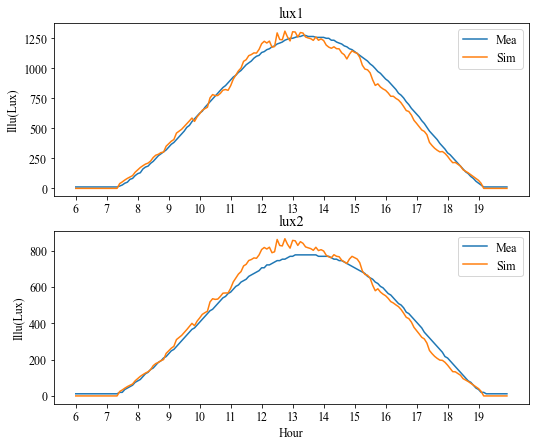

In [18]:

n_rows = 2
plt.figure(figsize = [8.5,3.5*n_rows])

ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1])

#plt.plot(np.arange(168),dat_17_5M['2022-10-01 06:00:00':'2022-10-01 19:55:00'].iloc[:,-1])
plt.plot(simu_result_0927_5M.iloc[:,0])
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1])

#plt.plot(np.arange(168),dat_17_5M['2022-10-01 06:00:00':'2022-10-01 19:55:00'].iloc[:,-1])
plt.plot(simu_result_0927_5M.iloc[:,1])
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
ax.set_xlabel('Hour')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig('Figures/0927_Blind50_H.png',dpi=300)

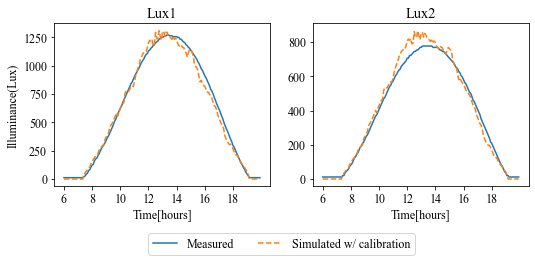

In [95]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_0927_5M.iloc[:,0],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_0927_5M.iloc[:,1],'--')

ax.set_xlabel('Time[hours]')
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.25))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\0927_5M_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')

[Text(0, 0, '6'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '12'),
 Text(0, 0, '14'),
 Text(0, 0, '16'),
 Text(0, 0, '18')]

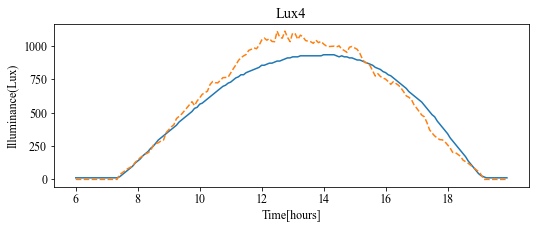

In [36]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot()
plt.plot(np.arange(168),dat_09_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_0927_5M.iloc[:,4],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux4')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

In [88]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_0927_5M.iloc[:,0],dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]*1.1))
print("nmbe of sensr 1:",nmbe(simu_result_0927_5M.iloc[:,0],dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]*1.1))
print("r2 of sensr 1:",r2_score(simu_result_0927_5M.iloc[:,0],dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]*1.1))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_0927_5M.iloc[:,1],dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]*1.1))
print("nmbe of sensr 2:",nmbe(simu_result_0927_5M.iloc[:,1],dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]*1.1))
print("r2 of sensr 2:",r2_score(simu_result_0927_5M.iloc[:,1],dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]*1.1))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_0927_5M.iloc[:,2],dat_23_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_0927_5M.iloc[:,2],dat_23_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_0927_5M.iloc[:,2],dat_23_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_0927_5M.iloc[:,4],dat_22_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_0927_5M.iloc[:,4],dat_22_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_0927_5M.iloc[:,4],dat_22_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.1507062358580772
nmbe of sensr 1: -0.11066642579362024
r2 of sensr 1: 0.9499434605507767
cv_rmse of sensr 2: 0.10330298560924613
nmbe of sensr 2: -0.06545128110755909
r2 of sensr 2: 0.9787650601428168
cv_rmse of sensr 3: 0.19241696955497498
nmbe of sensr 3: -0.1602392442594423
r2 of sensor 3: 0.9027905925164876
cv_rmse of sensor 5: 0.2476788066326294
nmbe of sensor 5: -0.2146526460692102
r2 of sensr 5: 0.8093606797097892


#### 9/28

In [193]:
### generate sky

pyrano_DF = py_DF_5M['2022-09-28 06:00:00':'2022-09-28 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j],Dir_rad,Dif_rad)
        
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 9 28 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/0928/09_28_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.27,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/0928/09_28_H{0}_{1}.sky > skyVectors/0928/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-09-28 06:00:00 0.4103097600000001 0.9746622766666677
hour: 6 minute: 5 2022-09-28 06:05:00 0.9814606966666666 1.0687600033333335
hour: 6 minute: 10 2022-09-28 06:10:00 1.3304973866666736 1.6628883966666677
hour: 6 minute: 15 2022-09-28 06:15:00 1.411465253333338 2.404728190000001
hour: 6 minute: 20 2022-09-28 06:20:00 1.3239324866666702 2.034902433333334
hour: 6 minute: 25 2022-09-28 06:25:00 1.104006449999999 1.3324523600000027
hour: 6 minute: 30 2022-09-28 06:30:00 0.18272461666666773 0.8718113333333329
hour: 6 minute: 35 2022-09-28 06:35:00 0.27682226000000054 0.9713798400000007
hour: 6 minute: 40 2022-09-28 06:40:00 0.3982739966666685 0.9538732733333332
hour: 6 minute: 45 2022-09-28 06:45:00 0.2910464000000009 0.9440258266666673
hour: 6 minute: 50 2022-09-28 06:50:00 0.35231930000000056 0.9276134233333336
hour: 6 minute: 55 2022-09-28 06:55:00 0.5416087733333328 1.1015847600000008
hour: 7 minute: 0 2022-09-28 07:00:00 0.7877945566666672 0.909012786666667
hour

hour: 15 minute: 5 2022-09-28 15:05:00 668.1708202633309 113.80761756666676
hour: 15 minute: 10 2022-09-28 15:10:00 657.1548387733329 112.80427390000007
hour: 15 minute: 15 2022-09-28 15:15:00 645.4024856766642 115.58890826666672
hour: 15 minute: 20 2022-09-28 15:20:00 634.4926084648814 109.37277567892968
hour: 15 minute: 25 2022-09-28 15:25:00 623.4263274666653 109.12789996000012
hour: 15 minute: 30 2022-09-28 15:30:00 614.22554946 113.08000189666686
hour: 15 minute: 35 2022-09-28 15:35:00 607.6584185666669 105.82791677999977
hour: 15 minute: 40 2022-09-28 15:40:00 599.1469613299988 108.05671846333325
hour: 15 minute: 45 2022-09-28 15:45:00 587.2151655400006 110.80524560666674
hour: 15 minute: 50 2022-09-28 15:50:00 573.1245996366661 108.19130000666661
hour: 15 minute: 55 2022-09-28 15:55:00 560.3918843599989 104.54884501999986
hour: 16 minute: 0 2022-09-28 16:00:00 546.7017797666675 101.89660371333342
hour: 16 minute: 5 2022-09-28 16:05:00 532.5871432633321 96.49145872666688
hour: 16

In [53]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        
        ### part 1 w blinds
        os.system('dctimestep matrices/Case2/v1.mtx matrices/Ven0.xml matrices/Case2/daylight1.dmx skyVectors/0928/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0928_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case2/v2.mtx matrices/clear.xml matrices/Case2/daylight2.dmx skyVectors/0928/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/0928_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/0928_5M/3ph_H{0}_{1}_p1.ill + Results/0928_5M/3ph_H{0}_{1}_p2.ill > Results/0928_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))
        
        
#read flux data
simu_result_0928_5M = []
for i in range(14):
    for j in range(12):
        simu_result_0928_5M.append(read_result(r'Results\0928_5M\3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_0928_5M = pd.DataFrame(simu_result_0928_5M)

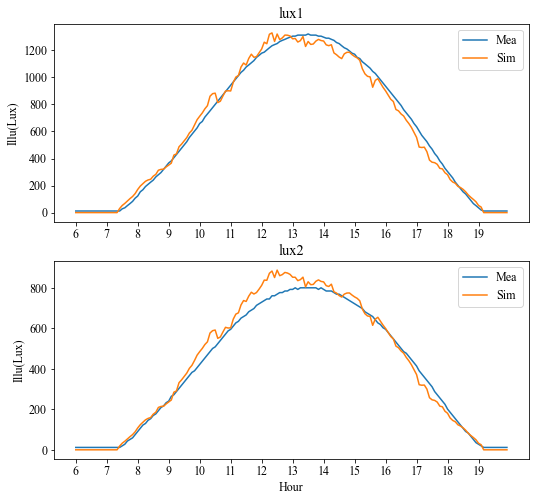

In [90]:
n_rows = 2
plt.figure(figsize = [8.5,4*n_rows])


ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_17_5M_Case2['2022-09-28 06:00:00':'2022-09-28 19:55:00'].iloc[:,-1])

#plt.plot(np.arange(168),dat_17_5M['2022-10-01 06:00:00':'2022-10-01 19:55:00'].iloc[:,-1])
plt.plot(simu_result_0928_5M.iloc[:,0])
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
#ax.set_xlabel('Hour')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])


ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_18_5M_Case2['2022-09-28 06:00:00':'2022-09-28 19:55:00'].iloc[:,-1])

#plt.plot(np.arange(168),dat_17_5M['2022-10-01 06:00:00':'2022-10-01 19:55:00'].iloc[:,-1])
plt.plot(simu_result_0928_5M.iloc[:,1])
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
ax.set_xlabel('Hour')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig('Figures/0928_Blind50_H.png',dpi=300)

### `Testing 3: blinds=50, vertical`

##### run radiance simulation first

###### generate sky vector and view, daylighting matrices

In [20]:
2175/145

15.0

In [202]:
# generate v matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx1.rad -i octrees/room3ph.oct < points.txt > matrices/Case2/v1.mtx')
# generate v matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx2.rad -i octrees/room3ph.oct < points.txt > matrices/Case2/v2.mtx')


# generate D matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx1.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/Case2/daylight1.dmx')

# generate D matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx2.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/Case2/daylight2.dmx')

0

In [27]:
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 3 - skyDomes/skyglow.rad -i octrees/room3ph.oct < points_roof.txt > matrices/roof_point.mtx')

0

In [10]:
i = 10
j = 0
### part 1 w blinds
os.system('dctimestep matrices/Case2/v1.mtx matrices/clear.xml matrices/Case2/daylight1.dmx skyVectors/1001/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1001_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))

### part 2 w/o blinds (clear)
os.system('dctimestep matrices/Case2/v2.mtx matrices/clear.xml matrices/Case2/daylight2.dmx skyVectors/1001/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1001_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))

# combine these two part 
os.system(r'C:\Radiance\bin\rmtxop Results/1001_5M/3ph_H{0}_{1}_p1.ill + Results/1001_5M/3ph_H{0}_{1}_p2.ill > Results/1001_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

0

In [13]:
read_result(r'Results/1001_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

[689.1801284000001, 479.98483325, 703.4099609, 694.5341726, 703.0800777]

In [17]:

## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V1.rad > octrees/roomV1_3ph.oct')
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V2.rad > octrees/roomV2_3ph.oct')

# generate v matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx1.rad -i octrees/roomV1_3ph.oct < points.txt > matrices/Case2/v1.mtx')
# generate v matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx2.rad -i octrees/roomV2_3ph.oct < points.txt > matrices/Case2/v2.mtx')


# generate D matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx1.rad skyDomes/skyglow.rad -i octrees/roomV1_3ph.oct > matrices/Case2/daylight1.dmx')

# generate D matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx2.rad skyDomes/skyglow.rad -i octrees/roomV2_3ph.oct > matrices/Case2/daylight2.dmx')

0

In [15]:

### part 1 w blinds
os.system('dctimestep matrices/Case2/v1.mtx matrices/clear.xml matrices/Case2/daylight1.dmx skyVectors/1001/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1001_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))

### part 2 w/o blinds (clear)
os.system('dctimestep matrices/Case2/v2.mtx matrices/clear.xml matrices/Case2/daylight2.dmx skyVectors/1001/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1001_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))

# combine these two part 
os.system(r'C:\Radiance\bin\rmtxop Results/1001_5M/3ph_H{0}_{1}_p1.ill + Results/1001_5M/3ph_H{0}_{1}_p2.ill > Results/1001_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

0

In [16]:
read_result(r'Results/1001_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

[823.0982491, 576.71467188, 901.8638831, 870.8990351, 866.4758488]

#### 10/01

In [152]:
### generate sky

pyrano_DF = py_DF_5M['2022-10-01 06:00:00':'2022-10-01 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j],Dir_rad,Dif_rad)
        
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 10 1 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/1001/10_01_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.25,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/1001/10_01_H{0}_{1}.sky > skyVectors/1001/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-10-01 06:00:00 1.019756249999999 0.9527791633333338
hour: 6 minute: 5 2022-10-01 06:05:00 0.731992483333334 0.9593440633333337
hour: 6 minute: 10 2022-10-01 06:10:00 0.6980735366666666 1.0031104466666672
hour: 6 minute: 15 2022-10-01 06:15:00 0.8085835666666675 0.9101069466666666
hour: 6 minute: 20 2022-10-01 06:20:00 0.8162427066666689 0.8739996666666661
hour: 6 minute: 25 2022-10-01 06:25:00 0.9289410966666679 0.8958828566666662
hour: 6 minute: 30 2022-10-01 06:30:00 0.7407457233333333 0.8772821666666683
hour: 6 minute: 35 2022-10-01 06:35:00 0.5547387333333348 0.7591129566666664
hour: 6 minute: 40 2022-10-01 06:40:00 0.5897517933333336 0.9702856966666678
hour: 6 minute: 45 2022-10-01 06:45:00 0.5525503766666691 0.8794704499999999
hour: 6 minute: 50 2022-10-01 06:50:00 0.4409461699999998 0.9112010466666675
hour: 6 minute: 55 2022-10-01 06:55:00 0.7287099566666652 0.9637207366666681
hour: 7 minute: 0 2022-10-01 07:00:00 1.5022803700000025 2.32157211666667
hour: 

hour: 15 minute: 5 2022-10-01 15:05:00 705.5385225566686 90.89045923999997
hour: 15 minute: 10 2022-10-01 15:10:00 695.9876205699991 87.98984384666659
hour: 15 minute: 15 2022-10-01 15:15:00 684.9048920099992 90.85982282333339
hour: 15 minute: 20 2022-10-01 15:20:00 673.1033020800019 93.24290099000017
hour: 15 minute: 25 2022-10-01 15:25:00 662.2054943000028 86.65825249999999
hour: 15 minute: 30 2022-10-01 15:30:00 653.0178536266666 81.62949809333338
hour: 15 minute: 35 2022-10-01 15:35:00 637.9272236099989 84.67891897999995
hour: 15 minute: 40 2022-10-01 15:40:00 611.840307586665 84.16357014333336
hour: 15 minute: 45 2022-10-01 15:45:00 603.223814046666 82.47090632666666
hour: 15 minute: 50 2022-10-01 15:50:00 596.6530602006671 79.62738845484961
hour: 15 minute: 55 2022-10-01 15:55:00 589.1770157033325 78.12709524666681
hour: 16 minute: 0 2022-10-01 16:00:00 577.9837795066657 76.01755692000003
hour: 16 minute: 5 2022-10-01 16:05:00 564.9665777366661 79.30112783000006
hour: 16 minute: 

In [242]:

## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V1.rad > octrees/roomV1_3ph.oct')
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V2.rad > octrees/roomV2_3ph.oct')

# generate v matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx1.rad -i octrees/roomV1_3ph.oct < points.txt > matrices/Case2/v1.mtx')
# generate v matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx2.rad -i octrees/roomV2_3ph.oct < points.txt > matrices/Case2/v2.mtx')


# generate D matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx1.rad skyDomes/skyglow.rad -i octrees/roomV1_3ph.oct > matrices/Case2/daylight1.dmx')

# generate D matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx2.rad skyDomes/skyglow.rad -i octrees/roomV2_3ph.oct > matrices/Case2/daylight2.dmx')




0

In [114]:

# generate v matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx1.rad -i octrees/room3ph.oct < points.txt > matrices/Case2/v1.mtx')
# generate v matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case2/GlazingVmtx2.rad -i octrees/room3ph.oct < points.txt > matrices/Case2/v2.mtx')


# generate D matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx1.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/Case2/daylight1.dmx')

# generate D matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case2/GlazingVmtx2.rad skyDomes/skyglow.rad -i octrees/room3ph.oct > matrices/Case2/daylight2.dmx')




0

In [194]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        
        ### part 1 w blinds
        os.system('dctimestep matrices/Case2/v1.mtx matrices/Ven90.xml matrices/Case2/daylight1.dmx skyVectors/1001/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1001_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case2/v2.mtx matrices/clear.xml matrices/Case2/daylight2.dmx skyVectors/1001/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1001_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/1001_5M/3ph_H{0}_{1}_p1.ill + Results/1001_5M/3ph_H{0}_{1}_p2.ill > Results/1001_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

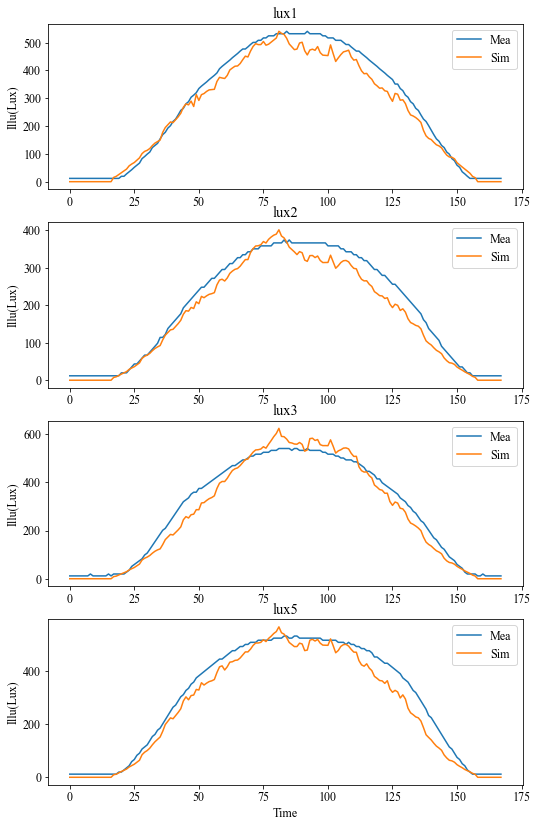

In [195]:
#read flux data
simu_result_1001_5M = []
for i in range(14):
    for j in range(12):
        simu_result_1001_5M.append(read_result(r'Results\1001_5M\3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_1001_5M = pd.DataFrame(simu_result_1001_5M)


plt.figure(figsize = [8.5,3.5*4])
n_rows = 4

ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_17_5M_Case2['2022-10-01 06:00:00':'2022-10-01 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1001_5M.iloc[:,0])
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_18_5M_Case2['2022-10-01 06:00:00':'2022-10-01 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1001_5M.iloc[:,1])
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

ax = plt.subplot(n_rows,1,3)
plt.plot(np.arange(168),dat_23_5M_Case2['2022-10-01 06:00:00':'2022-10-01 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1001_5M.iloc[:,2])
ax.legend(['Mea','Sim'])
ax.set_title('lux3')
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

ax = plt.subplot(n_rows,1,4)
plt.plot(np.arange(168),dat_22_5M_Case2['2022-10-01 06:00:00':'2022-10-01 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1001_5M.iloc[:,4])
ax.set_title('lux5')
ax.legend(['Mea','Sim'])
ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

plt.savefig('Figures/1001_Blind50_V.png',dpi=300)

#### 10/02

In [175]:
### generate sky

pyrano_DF = py_DF_5M['2022-10-02 06:00:00':'2022-10-02 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j],Dir_rad,Dif_rad)
        
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 10 2 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/1002/10_02_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.24,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/1002/10_02_H{0}_{1}.sky > skyVectors/1002/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-10-02 06:00:00 0.5022190766666685 0.7974085433333338
hour: 6 minute: 5 2022-10-02 06:05:00 0.5055015766666681 0.8816587666666665
hour: 6 minute: 10 2022-10-02 06:10:00 0.7713821766666672 0.9319901033333337
hour: 6 minute: 15 2022-10-02 06:15:00 1.0635225700000026 1.1070556033333334
hour: 6 minute: 20 2022-10-02 06:20:00 1.3381565199999974 1.1781758933333357
hour: 6 minute: 25 2022-10-02 06:25:00 1.1882567299999998 1.066571686666667
hour: 6 minute: 30 2022-10-02 06:30:00 1.1237013100000002 1.1114322266666667
hour: 6 minute: 35 2022-10-02 06:35:00 0.8709506433333354 0.8707171966666671
hour: 6 minute: 40 2022-10-02 06:40:00 0.8381258533333333 1.0742307966666684
hour: 6 minute: 45 2022-10-02 06:45:00 1.4590007792642177 2.365126220735789
hour: 6 minute: 50 2022-10-02 06:50:00 1.5000921000000056 2.5469688633333347
hour: 6 minute: 55 2022-10-02 06:55:00 1.4738323000000029 2.5568162700000037
hour: 7 minute: 0 2022-10-02 07:00:00 1.4858680533333324 2.5174265400000024
hour

hour: 15 minute: 0 2022-10-02 15:00:00 545.8382719063541 217.49469614046842
hour: 15 minute: 5 2022-10-02 15:05:00 327.2682556900006 257.1424192533332
hour: 15 minute: 10 2022-10-02 15:10:00 604.1569742533347 273.45413690000004
hour: 15 minute: 15 2022-10-02 15:15:00 584.7171162466676 208.81671084666655
hour: 15 minute: 20 2022-10-02 15:20:00 374.0238358399998 224.6896717099999
hour: 15 minute: 25 2022-10-02 15:25:00 489.9947539866665 236.9606620399999
hour: 15 minute: 30 2022-10-02 15:30:00 357.35981400000037 226.1263022333334
hour: 15 minute: 35 2022-10-02 15:35:00 258.7739676500004 213.52159352999993
hour: 15 minute: 40 2022-10-02 15:40:00 504.29980769666633 181.04039601000008
hour: 15 minute: 45 2022-10-02 15:45:00 408.397960410001 144.25149381333324
hour: 15 minute: 50 2022-10-02 15:50:00 483.6979268599999 151.22128573333345
hour: 15 minute: 55 2022-10-02 15:55:00 353.22283268666695 160.37283022999986
hour: 16 minute: 0 2022-10-02 16:00:00 215.48578533 206.84284824999997
hour: 16 

In [212]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        
        ### part 1 w blinds
        os.system('dctimestep matrices/Case2/v1.mtx matrices/Ven90.xml matrices/Case2/daylight1.dmx skyVectors/1002/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1002_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case2/v2.mtx matrices/clear.xml matrices/Case2/daylight2.dmx skyVectors/1002/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1002_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/1002_5M/3ph_H{0}_{1}_p1.ill + Results/1002_5M/3ph_H{0}_{1}_p2.ill > Results/1002_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

In [19]:
#read flux data
simu_result_1002_5M = []
for i in range(14):
    for j in range(12):
        simu_result_1002_5M.append(read_result(r'Results\1002_5M\3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_1002_5M = pd.DataFrame(simu_result_1002_5M)

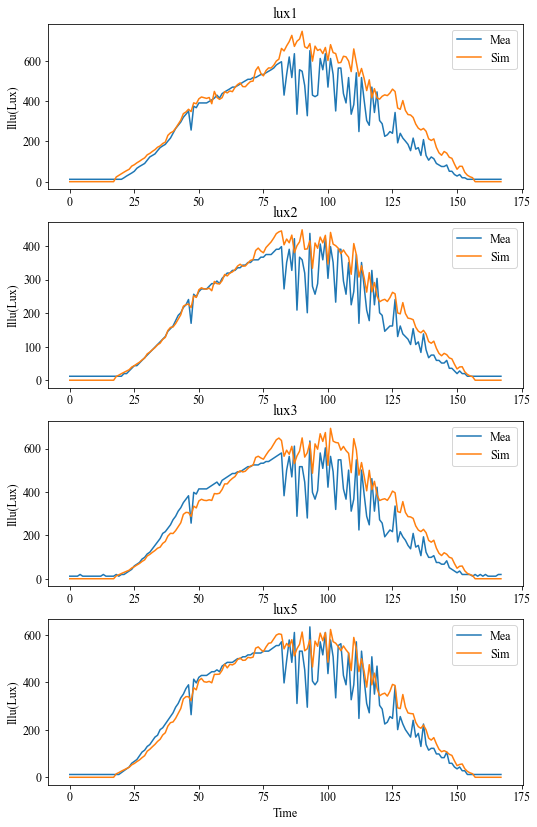

In [20]:
n_rows = 4
plt.figure(figsize = [8.5,3.5*4])


ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_17_5M_Case2['2022-10-02 06:00:00':'2022-10-02 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1002_5M.iloc[:,0])
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_18_5M_Case2['2022-10-02 06:00:00':'2022-10-02 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1002_5M.iloc[:,1])
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

ax = plt.subplot(n_rows,1,3)
plt.plot(np.arange(168),dat_23_5M_Case2['2022-10-02 06:00:00':'2022-10-02 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1002_5M.iloc[:,2])
ax.legend(['Mea','Sim'])
ax.set_title('lux3')
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

ax = plt.subplot(n_rows,1,4)
plt.plot(np.arange(168),dat_22_5M_Case2['2022-10-02 06:00:00':'2022-10-02 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1002_5M.iloc[:,4])
ax.legend(['Mea','Sim'])
ax.set_title('lux5')
ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
plt.savefig('Figures/1002_Blind50_V.png',dpi=300)

#### 10/03

In [111]:
### generate sky

pyrano_DF = py_DF_5M['2022-10-03 06:00:00':'2022-10-03 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j],Dir_rad,Dif_rad)
        
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 10 3 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/1003/10_03_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.24,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/1003/10_03_H{0}_{1}.sky > skyVectors/1003/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-10-03 06:00:00 1.2844475719063566 1.565914431438129
hour: 6 minute: 5 2022-10-03 06:05:00 1.3031433899999993 1.5097061433333363
hour: 6 minute: 10 2022-10-03 06:10:00 1.0580518199999986 1.1508219100000023
hour: 6 minute: 15 2022-10-03 06:15:00 0.8096777466666666 0.9834155733333344
hour: 6 minute: 20 2022-10-03 06:20:00 0.6816611399999999 1.0195228266666674
hour: 6 minute: 25 2022-10-03 06:25:00 0.5963167866666667 0.7394180666666669
hour: 6 minute: 30 2022-10-03 06:30:00 0.8479732900000014 0.8313274966666662
hour: 6 minute: 35 2022-10-03 06:35:00 1.4180301533333355 1.7930933000000027
hour: 6 minute: 40 2022-10-03 06:40:00 1.4650789833333375 2.0502206666666667
hour: 6 minute: 45 2022-10-03 06:45:00 1.1795034733333343 1.3849719666666682
hour: 6 minute: 50 2022-10-03 06:50:00 1.1116656300000003 1.3598062833333346
hour: 6 minute: 55 2022-10-03 06:55:00 0.4518877866666665 0.8389865266666666
hour: 7 minute: 0 2022-10-03 07:00:00 1.2692245000000004 1.5655082333333352
hou

hour: 15 minute: 5 2022-10-03 15:05:00 679.5719540433336 104.68123815666655
hour: 15 minute: 10 2022-10-03 15:10:00 668.6325641600029 103.0586005400001
hour: 15 minute: 15 2022-10-03 15:15:00 658.9864720566646 97.78584868333357
hour: 15 minute: 20 2022-10-03 15:20:00 645.8215653933346 94.84474959000012
hour: 15 minute: 25 2022-10-03 15:25:00 635.1765000200006 97.36350331333348
hour: 15 minute: 30 2022-10-03 15:30:00 625.8170677533328 102.93496059333329
hour: 15 minute: 35 2022-10-03 15:35:00 614.2233648699985 108.27992688999996
hour: 15 minute: 40 2022-10-03 15:40:00 588.968016723333 97.25736991666673
hour: 15 minute: 45 2022-10-03 15:45:00 558.6609390933337 86.38033614333315
hour: 15 minute: 50 2022-10-03 15:50:00 530.4524472400004 86.79611649333322
hour: 15 minute: 55 2022-10-03 15:55:00 511.1514910399994 93.85672411000009
hour: 16 minute: 0 2022-10-03 16:00:00 522.7364397266666 92.59953550333337
hour: 16 minute: 5 2022-10-03 16:05:00 519.4655040668895 85.92118085618726
hour: 16 minu

In [215]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        
        ### part 1 w blinds
        os.system('dctimestep matrices/Case2/v1.mtx matrices/Ven90.xml matrices/Case2/daylight1.dmx skyVectors/1003/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1003_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case2/v2.mtx matrices/clear.xml matrices/Case2/daylight2.dmx skyVectors/1003/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1003_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/1003_5M/3ph_H{0}_{1}_p1.ill + Results/1003_5M/3ph_H{0}_{1}_p2.ill > Results/1003_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

In [47]:
#read flux data
simu_result_1003_5M = []
for i in range(14):
    for j in range(12):
        simu_result_1003_5M.append(read_result(r'Results\1003_5M\3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_1003_5M = pd.DataFrame(simu_result_1003_5M)

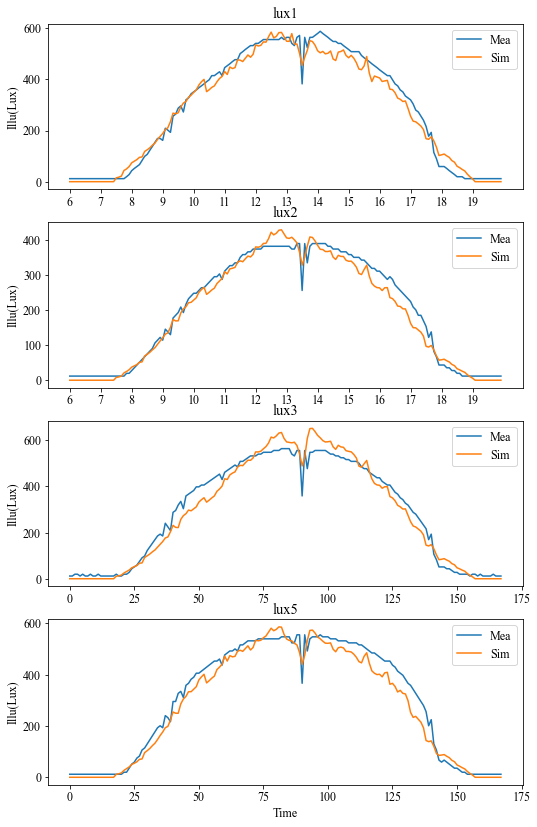

In [25]:
n_rows = 4
plt.figure(figsize = [8.5,3.5*4])


ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1003_5M.iloc[:,0])
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])



ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1003_5M.iloc[:,1])
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
#ax.set_xlabel('Hour')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])

ax = plt.subplot(n_rows,1,3)
plt.plot(np.arange(168),dat_23_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1003_5M.iloc[:,2])
ax.legend(['Mea','Sim'])
ax.set_title('lux3')
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

ax = plt.subplot(n_rows,1,4)
plt.plot(np.arange(168),dat_22_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1003_5M.iloc[:,4])
ax.legend(['Mea','Sim'])
ax.set_title('lux5')
ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')
plt.savefig('Figures/1003_Blind50_V.png',dpi=300)

Text(0, 0.5, 'Illu(Lux)')

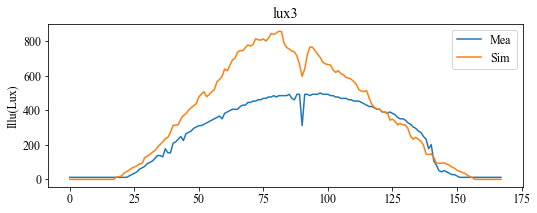

In [32]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot()
plt.plot(np.arange(168),dat_09_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1003_5M.iloc[:,3])
ax.legend(['Mea','Sim'])
ax.set_title('lux3')
#ax.set_xlabel('Time')
ax.set_ylabel('Illu(Lux)')

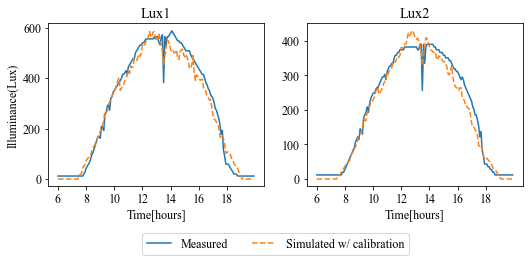

In [98]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1003_5M.iloc[:,0],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1003_5M.iloc[:,1],'--')

ax.set_xlabel('Time[hours]')
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.25))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\1003_5M_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')

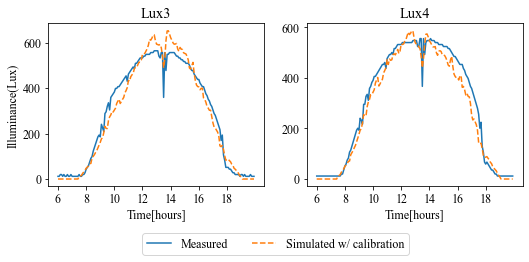

In [77]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_23_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1003_5M.iloc[:,2],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux3')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_22_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1003_5M.iloc[:,4],'--')

ax.set_xlabel('Time[hours]')
ax.set_title('Lux4')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.25))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\1003_5M_sensor3&4.jpg',dpi=300,bbox_inches = 'tight')

[Text(0, 0, '6'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '12'),
 Text(0, 0, '14'),
 Text(0, 0, '16'),
 Text(0, 0, '18')]

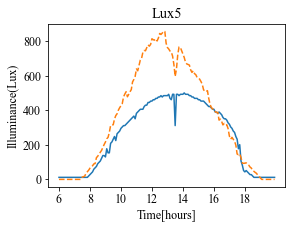

In [80]:
plt.figure(figsize=[8.5/2,3])
ax = plt.subplot()
plt.plot(np.arange(168),dat_09_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1003_5M.iloc[:,3],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux5')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

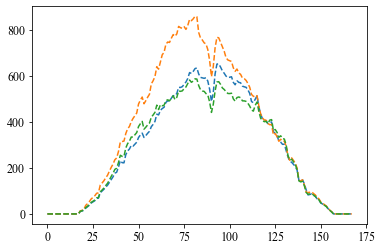

In [81]:
plt.plot(np.arange(168),simu_result_1003_5M.iloc[:,2],'--')
plt.plot(np.arange(168),simu_result_1003_5M.iloc[:,3],'--')
plt.plot(np.arange(168),simu_result_1003_5M.iloc[:,4],'--')

In [99]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_1003_5M.iloc[:,0],dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]*1.1))
print("nmbe of sensr 1:",nmbe(simu_result_1003_5M.iloc[:,0],dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]*1.1))
print("r2 of sensr 1:",r2_score(simu_result_1003_5M.iloc[:,0],dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]*1.1))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_1003_5M.iloc[:,1],dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]*1.1))
print("nmbe of sensr 2:",nmbe(simu_result_1003_5M.iloc[:,1],dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]*1.1))
print("r2 of sensr 2:",r2_score(simu_result_1003_5M.iloc[:,1],dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]*1.1))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_1003_5M.iloc[:,2],dat_23_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_1003_5M.iloc[:,2],dat_23_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_1003_5M.iloc[:,2],dat_23_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_1003_5M.iloc[:,4],dat_22_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_1003_5M.iloc[:,4],dat_22_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_1003_5M.iloc[:,4],dat_22_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.1914663631143214
nmbe of sensr 1: -0.12634564914810847
r2 of sensr 1: 0.9103586653809024
cv_rmse of sensr 2: 0.185378393805757
nmbe of sensr 2: -0.13478885491433665
r2 of sensr 2: 0.923489607370399
cv_rmse of sensr 3: 0.1479375712339856
nmbe of sensr 3: -0.0228953747634736
r2 of sensor 3: 0.9638077627374457
cv_rmse of sensor 5: 0.13587233524534462
nmbe of sensor 5: -0.07734549418593503
r2 of sensr 5: 0.9623107816423715


In [124]:
sol_rad = [0.08,0.79,1.51,2.41,3.07,3.43,3.46,3.3,2.81,2.09,1.08,0.2,0.01]

In [129]:
py_DF_5M_2 = py_DF_2.resample('1H').mean()

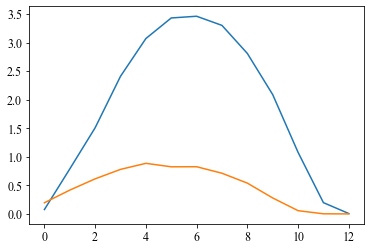

In [137]:
plt.plot(sol_rad)
plt.plot(np.arange(13),py_DF_5M_2['2022-10-03 08:00:00':'2022-10-03 20:00:00'].iloc[:,-2])

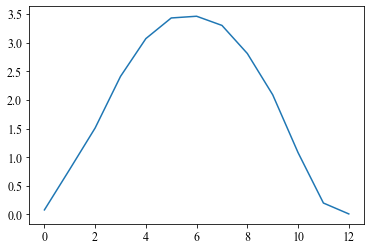

In [131]:
plt.plot(sol_rad)

In [130]:
len(sol_rad)

13

In [125]:
py_DF_5M_3

,CH1,CH2,Total(W/m2),Diffuse(W/m2)
DateTime,,,,
2022-10-04 15:25:00,0.722385,0.103310,722.385123,103.310257
2022-10-04 15:30:00,0.707964,0.097095,707.964120,97.095434
2022-10-04 15:35:00,0.700152,0.094666,700.151831,94.666402
2022-10-04 15:40:00,0.681113,0.091450,681.113480,91.449575
2022-10-04 15:45:00,0.643234,0.089480,643.233726,89.480088
...,...,...,...,...
2022-10-14 10:50:00,0.630826,0.094273,630.825973,94.272504
2022-10-14 10:55:00,0.649733,0.096505,649.733026,96.504589
2022-10-14 11:00:00,0.664307,0.094863,664.307212,94.863350


### `Testing 4: blinds=75, vertical`

In [221]:

## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V1_case3.rad > octrees/roomV1_3ph_Case3.oct')
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V2_case3.rad > octrees/roomV2_3ph_Case3.oct')

# generate v matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case3/GlazingVmtx1.rad -i octrees/roomV1_3ph_Case3.oct < points.txt > matrices/Case3/v1.mtx')
# generate v matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case3/GlazingVmtx2.rad -i octrees/roomV2_3ph_Case3.oct < points.txt > matrices/Case3/v2.mtx')


# generate D matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case3/GlazingVmtx1.rad skyDomes/skyglow.rad -i octrees/roomV1_3ph_Case3.oct > matrices/Case3/daylight1.dmx')

# generate D matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case3/GlazingVmtx2.rad skyDomes/skyglow.rad -i octrees/roomV2_3ph_Case3.oct > matrices/Case3/daylight2.dmx')

0

In [24]:
path = r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Case3_Blind75_VerticalAndHorizon'

dat_09 = pd.read_csv(path+'\\'+'Sensor_09.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_09=dat_09.iloc[:,:-2]
dat_09 = dat_09.set_index("Date Time, GMT-05:00")

dat_17 = pd.read_csv(path+'\\'+'Sensor_17.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_17=dat_17.iloc[:,:-2]
dat_17 = dat_17.set_index("Date Time, GMT-05:00")

dat_18 = pd.read_csv(path+'\\'+'Sensor_18.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_18=dat_18.iloc[:,:-3]
dat_18 = dat_18.set_index("Date Time, GMT-05:00")

dat_19 = pd.read_csv(path+'\\'+'Sensor_19.csv',header=1)
dat_20 = pd.read_csv(path+'\\'+'Sensor_20.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_20=dat_20.iloc[:-3,:-3]
dat_20 = dat_20.set_index("Date Time, GMT-05:00")


dat_22 = pd.read_csv(path+'\\'+'Sensor_22.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_22=dat_22.iloc[:,:-3]
dat_22 = dat_22.set_index("Date Time, GMT-05:00")

dat_23 = pd.read_csv(path+'\\'+'Sensor_23.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_23=dat_23.iloc[:,:-3]
dat_23 = dat_23.set_index("Date Time, GMT-05:00")


dat_17_resample = dat_17.resample('1H').mean()
dat_17_resample = dat_17.resample('1H').mean()
dat_18_resample = dat_18.resample('1H').mean()
dat_20_resample = dat_20.resample('1H').mean()
dat_23_resample = dat_23.resample('1H').mean()
dat_22_resample = dat_22.resample('1H').mean()

# resample to 5Minute
dat_17_5M_Case3 = dat_17.resample('5T').mean()
dat_09_5M_Case3 = dat_09.resample('5T').mean()
dat_18_5M_Case3 = dat_18.resample('5T').mean()
dat_20_5M_Case3 = dat_20.resample('5T').mean()
dat_22_5M_Case3 = dat_22.resample('5T').mean()
dat_23_5M_Case3 = dat_23.resample('5T').mean()

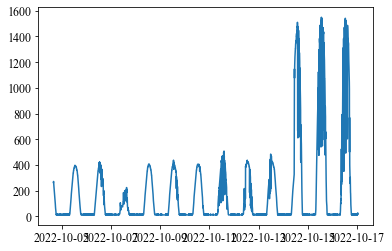

In [107]:
plt.plot(dat_23_5M_Case3.iloc[:,-1])

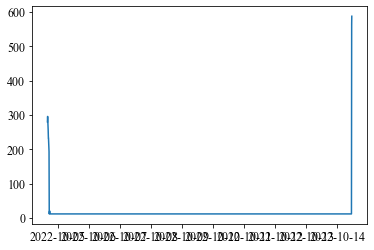

In [106]:
plt.plot(dat_22_5M_Case3.iloc[:,-1])

In [96]:
py_DF_3 = pd.read_csv(path+'\\'+'pyranometer.csv',parse_dates=[2],date_parser = lambda x:time.strftime("%m/%d/%Y %H:%M:%S",time.strptime(x,'%m/%d/%Y %H:%M')))
py_DF_3 = py_DF_3.set_index('DateTime')

## resample 
py_DF_resample3 = py_DF_3.resample('1H').mean()


# calc Total and diffuse
py_DF_resample3['Total(W/m2)'] = py_DF_resample3['CH1'].apply(lambda x:x*1000)
py_DF_resample3['Diffuse(W/m2)'] = py_DF_resample3['CH2'].apply(lambda x:x*1000)

py_DF_5M_3 = py_DF_3.resample('5T').mean()
py_DF_5M_3.to_csv('pyranometer3_5M.csv')
# calc Total and diffuse
py_DF_5M_3['Total(W/m2)'] = py_DF_5M_3['CH1'].apply(lambda x:x*1000)
py_DF_5M_3['Diffuse(W/m2)'] = py_DF_5M_3['CH2'].apply(lambda x:x*1000)

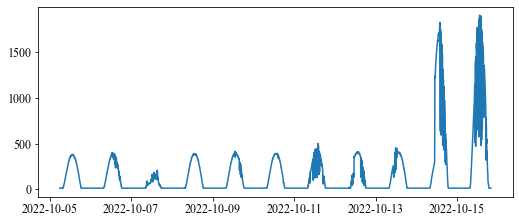

In [224]:
plt.figure(figsize=[8.5,3.5])
plt.plot(dat_17_5M_Case3['2022-10-05 06:00:00':'2022-10-15 19:55:00'].iloc[:,-1])

#### 10/05

In [ ]:

## generate a scene
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V1_case3.rad > octrees/roomV1_3ph_Case3.oct')
os.system(r'C:\Radiance\bin\oconv -f materials.rad room_V2_case3.rad > octrees/roomV2_3ph_Case3.oct')

# generate v matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case3/GlazingVmtx1.rad -i octrees/roomV1_3ph_Case3.oct < points.txt > matrices/Case3/v1.mtx')
# generate v matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 5 - objects/Case3/GlazingVmtx2.rad -i octrees/roomV2_3ph_Case3.oct < points.txt > matrices/Case3/v2.mtx')


# generate D matrix for shading part 1
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case3/GlazingVmtx1.rad skyDomes/skyglow.rad -i octrees/roomV1_3ph_Case3.oct > matrices/Case3/daylight1.dmx')

# generate D matrix for shading part 2
os.system(r'C:\Radiance\bin\rfluxmtx -v -ff -ab 4 -aa 0.08 -ar 512  -ad 2000 -lw 0.001 -c 1000 -n 16 objects/Case3/GlazingVmtx2.rad skyDomes/skyglow.rad -i octrees/roomV2_3ph_Case3.oct > matrices/Case3/daylight2.dmx')

In [46]:
### generate sky

pyrano_DF = py_DF_5M_3['2022-10-05 06:00:00':'2022-10-05 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j],Dir_rad,Dif_rad)
        
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 10 5 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/1005/10_05_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.23,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/1005/10_05_H{0}_{1}.sky > skyVectors/1005/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-10-05 06:00:00 0.7877946000000002 0.8532105999999999
hour: 6 minute: 5 2022-10-05 06:05:00 0.9847432000000003 0.9845096
hour: 6 minute: 10 2022-10-05 06:10:00 0.9847429999999998 0.7219118000000001
hour: 6 minute: 15 2022-10-05 06:15:00 1.4442901999999997 0.5249628
hour: 6 minute: 20 2022-10-05 06:20:00 1.5755887999999998 0.9845098
hour: 6 minute: 25 2022-10-05 06:25:00 0.9847429999999999 1.2471079999999999
hour: 6 minute: 30 2022-10-05 06:30:00 0.9847431999999998 1.1814584000000001
hour: 6 minute: 35 2022-10-05 06:35:00 1.3129910000000005 1.0501593999999999
hour: 6 minute: 40 2022-10-05 06:40:00 1.3129908 0.8532108
hour: 6 minute: 45 2022-10-05 06:45:00 0.7221448000000004 1.5753555999999997
hour: 6 minute: 50 2022-10-05 06:50:00 1.6412388000000002 0.39366379999999995
hour: 6 minute: 55 2022-10-05 06:55:00 0.6564958000000001 1.1158086
hour: 7 minute: 0 2022-10-05 07:00:00 1.1160426 0.7875608
hour: 7 minute: 5 2022-10-05 07:05:00 0.3282478000000001 0.65626179999999

hour: 15 minute: 45 2022-10-05 15:45:00 528.9381228 100.50921019999998
hour: 15 minute: 50 2022-10-05 15:50:00 494.537795 91.18697639999999
hour: 15 minute: 55 2022-10-05 15:55:00 490.27057579999996 95.1259484
hour: 16 minute: 0 2022-10-05 16:00:00 484.493421 93.81295759999999
hour: 16 minute: 5 2022-10-05 16:05:00 476.4841894 82.65253659999999
hour: 16 minute: 10 2022-10-05 16:10:00 468.27800019999995 86.000663
hour: 16 minute: 15 2022-10-05 16:15:00 469.78793680000007 89.2174902
hour: 16 minute: 20 2022-10-05 16:20:00 460.5313612 83.177733
hour: 16 minute: 25 2022-10-05 16:25:00 446.0884702 85.67241519999999
hour: 16 minute: 30 2022-10-05 16:30:00 431.44863539999994 80.026555
hour: 16 minute: 35 2022-10-05 16:35:00 415.88969920000005 88.101448
hour: 16 minute: 40 2022-10-05 16:40:00 398.0330344 88.75794340000002
hour: 16 minute: 45 2022-10-05 16:45:00 380.24201899999997 88.6922938
hour: 16 minute: 50 2022-10-05 16:50:00 365.01133660000005 81.8647424
hour: 16 minute: 55 2022-10-05 16:

In [225]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        
        ### part 1 w blinds
        os.system('dctimestep matrices/Case3/v1.mtx matrices/blinds_ven70.xml matrices/Case3/daylight1.dmx skyVectors/1005/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1005_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case3/v2.mtx matrices/clear.xml matrices/Case3/daylight2.dmx skyVectors/1005/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1005_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/1005_5M/3ph_H{0}_{1}_p1.ill + Results/1005_5M/3ph_H{0}_{1}_p2.ill > Results/1005_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

In [25]:
#read flux data
simu_result_1005_5M = []
for i in range(14):
    for j in range(12):
        simu_result_1005_5M.append(read_result(r'Results\1005_5M\3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_1005_5M = pd.DataFrame(simu_result_1005_5M)

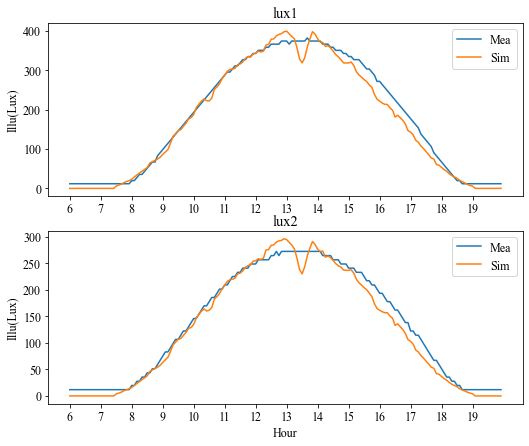

In [25]:
plt.figure(figsize = [8.5,3.5*2])
n_rows = 2

ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_17_5M_Case3['2022-10-05 06:00:00':'2022-10-05 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1005_5M.iloc[:,0])
#plt.plot(simu_result_1001_5M.iloc[:,0])
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])



ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_18_5M_Case3['2022-10-05 06:00:00':'2022-10-05 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1005_5M.iloc[:,1])
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
ax.set_xlabel('Hour')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
plt.savefig('Figures/1005_Blind75_V.png',dpi=300)

NameError: name 'dat_09_5M_Case3' is not defined

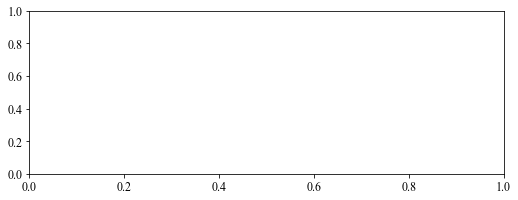

In [83]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot()
plt.plot(np.arange(168),dat_09_5M_Case3['2022-10-05 06:00:00':'2022-10-05 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1005_5M.iloc[:,3])

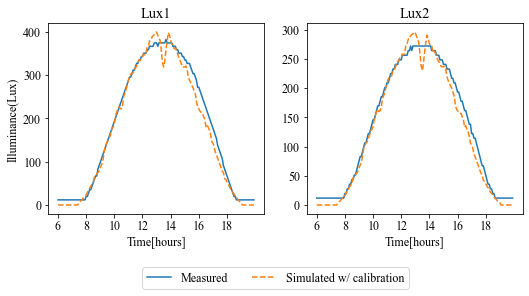

In [233]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_17_5M_Case3['2022-10-05 06:00:00':'2022-10-05 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1005_5M.iloc[:,0],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_18_5M_Case3['2022-10-05 06:00:00':'2022-10-05 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1005_5M.iloc[:,1],'--')

ax.set_xlabel('Time[hours]')
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.25))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\1005_5M_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')

#### 10/06

In [103]:
### generate sky

pyrano_DF = py_DF_5M_3['2022-10-06 06:00:00':'2022-10-06 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j],Dir_rad,Dif_rad)
        
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 10 6 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/1006/10_06_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.22,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/1006/10_06_H{0}_{1}.sky > skyVectors/1006/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-10-06 06:00:00 0.6564954000000003 1.1814584
hour: 6 minute: 5 2022-10-06 06:05:00 0.7877945999999998 0.7875611999999999
hour: 6 minute: 10 2022-10-06 06:10:00 0.4595465999999998 0.9845098
hour: 6 minute: 15 2022-10-06 06:15:00 0.7221449999999999 0.9845098
hour: 6 minute: 20 2022-10-06 06:20:00 0.8534439999999996 0.7219118
hour: 6 minute: 25 2022-10-06 06:25:00 0.9847434 0.9188602
hour: 6 minute: 30 2022-10-06 06:30:00 0.5908461999999999 0.8532105999999999
hour: 6 minute: 35 2022-10-06 06:35:00 0.45954680000000026 0.9188604
hour: 6 minute: 40 2022-10-06 06:40:00 0.3282480000000001 0.787561
hour: 6 minute: 45 2022-10-06 06:45:00 0.1969487999999998 0.7875612000000001
hour: 6 minute: 50 2022-10-06 06:50:00 0.5908458000000001 0.5249630000000001
hour: 6 minute: 55 2022-10-06 06:55:00 0.13129919999999995 1.3784070000000002
hour: 7 minute: 0 2022-10-06 07:00:00 1.0503930000000001 1.509706
hour: 7 minute: 5 2022-10-06 07:05:00 1.1160423999999998 0.5249630000000001
hour: 7

hour: 15 minute: 45 2022-10-06 15:45:00 362.05703599999987 240.53965499999998
hour: 15 minute: 50 2022-10-06 15:50:00 321.15740399999993 232.98996
hour: 15 minute: 55 2022-10-06 15:55:00 311.8351753999999 232.0708668
hour: 16 minute: 0 2022-10-06 16:00:00 374.2021998 224.1929238
hour: 16 minute: 5 2022-10-06 16:05:00 377.61597700000027 216.97147599999997
hour: 16 minute: 10 2022-10-06 16:10:00 343.4125958 202.85682839999998
hour: 16 minute: 15 2022-10-06 16:15:00 348.46761660000004 182.5711244
hour: 16 minute: 20 2022-10-06 16:20:00 362.18836699999997 166.0930926
hour: 16 minute: 25 2022-10-06 16:25:00 404.72924000000006 172.2641484
hour: 16 minute: 30 2022-10-06 16:30:00 353.85088899999994 151.65019600000002
hour: 16 minute: 35 2022-10-06 16:35:00 336.9133200000001 145.938687
hour: 16 minute: 40 2022-10-06 16:40:00 336.38812799999994 137.46989739999998
hour: 16 minute: 45 2022-10-06 16:45:00 233.38404859999997 140.62107480000003
hour: 16 minute: 50 2022-10-06 16:50:00 299.493103999999

In [237]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        
        ### part 1 w blinds
        os.system('dctimestep matrices/Case3/v1.mtx matrices/blinds_ven70.xml matrices/Case3/daylight1.dmx skyVectors/1006/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1006_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case3/v2.mtx matrices/clear.xml matrices/Case3/daylight2.dmx skyVectors/1006/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1006_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/1006_5M/3ph_H{0}_{1}_p1.ill + Results/1006_5M/3ph_H{0}_{1}_p2.ill > Results/1006_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

In [48]:
#read flux data
simu_result_1006_5M = []
for i in range(14):
    for j in range(12):
        simu_result_1006_5M.append(read_result(r'Results\1006_5M\3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_1006_5M = pd.DataFrame(simu_result_1006_5M)

[Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19')]

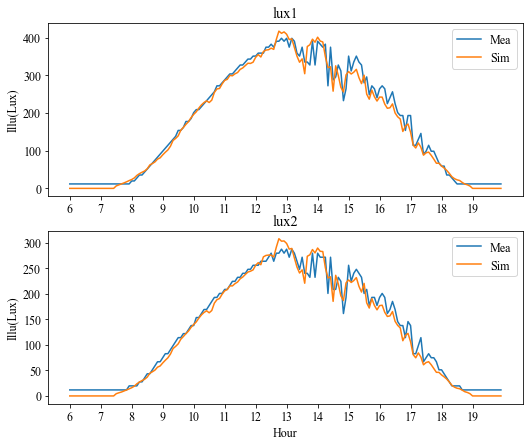

In [21]:

plt.figure(figsize = [8.5,3.5*2])
n_rows = 2

ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1006_5M.iloc[:,0])
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])

ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1006_5M.iloc[:,1])
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
ax.set_xlabel('Hour')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
#plt.savefig('Figures/1005_Blind75_V.png',dpi=300)

[Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19')]

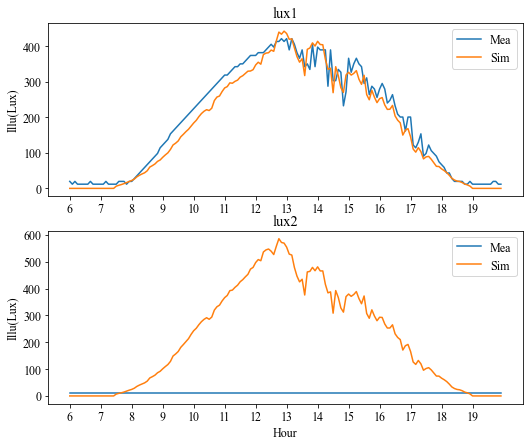

In [99]:

plt.figure(figsize = [8.5,3.5*2])
n_rows = 2

ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_23_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1006_5M.iloc[:,2])
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])

ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_22_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1006_5M.iloc[:,3])
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
ax.set_xlabel('Hour')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])
#plt.savefig('Figures/1005_Blind75_V.png',dpi=300)

[Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19')]

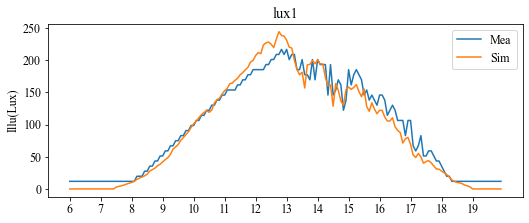

In [104]:
plt.figure(figsize = [8.5,3.5*2])
n_rows = 2

ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_09_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1006_5M.iloc[:,3]/2.4)
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])

In [108]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_1006_5M.iloc[:,0],dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]*1.1))
print("nmbe of sensr 1:",nmbe(simu_result_1006_5M.iloc[:,0],dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]*1.1))
print("r2 of sensr 1:",r2_score(simu_result_1006_5M.iloc[:,0],dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]*1.1))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_1006_5M.iloc[:,1],dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]*1.1))
print("nmbe of sensr 2:",nmbe(simu_result_1006_5M.iloc[:,1],dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]*1.1))
print("r2 of sensr 2:",r2_score(simu_result_1006_5M.iloc[:,1],dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]*1.1))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_1006_5M.iloc[:,2],dat_23_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_1006_5M.iloc[:,2],dat_23_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_1006_5M.iloc[:,2],dat_23_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_1006_5M.iloc[:,4],dat_22_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_1006_5M.iloc[:,4],dat_22_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_1006_5M.iloc[:,4],dat_22_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 0.16871823834204927
nmbe of sensr 1: -0.12494314696321161
r2 of sensr 1: 0.9438436821115119
cv_rmse of sensr 2: 0.1663851980849536
nmbe of sensr 2: -0.13179888314718297
r2 of sensr 2: 0.9454292692720481
cv_rmse of sensr 3: 0.14484597616739667
nmbe of sensr 3: -0.0885485405935655
r2 of sensor 3: 0.9636452497290209
cv_rmse of sensor 5: 18.32700713891053
nmbe of sensor 5: 13.941156462825415
r2 of sensr 5: -1.373312936958508


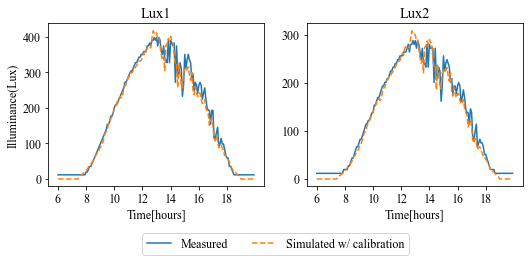

In [81]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1006_5M.iloc[:,0],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1006_5M.iloc[:,1],'--')

ax.set_xlabel('Time[hours]')
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.25))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\1006_5M_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')

### `Testing 5: blinds = 75, facing upwards`

In [26]:
path = r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Case3_Blind75_VerticalAndHorizon\Case5'

In [27]:
py_DF = pd.read_csv(path+'\\Pyranometer.csv',parse_dates=[2],date_parser = date_parser_func2)
py_DF = py_DF.set_index('Datetime')

py_DF.to_csv(path+'\\Pyranometer_af.csv')

## resample 
py_DF_resample = py_DF.resample('1H').mean()
py_DF_resample.to_csv('pyranometer_Hourly.csv')

# calc Total and diffuse
py_DF_resample['Total(W/m2)'] = py_DF_resample['Ch1'].apply(lambda x:x*1000)
py_DF_resample['Diffuse(W/m2)'] = py_DF_resample['Ch2'].apply(lambda x:x*1000)


#### 5min ########

## resample 
py_DF_5M_Case5 = py_DF.resample('5T').mean()
py_DF_5M_Case5.to_csv('pyranometer_5M.csv')

# calc Total and diffuse
py_DF_5M_Case5['Total(W/m2)'] = py_DF_5M_Case5['Ch1'].apply(lambda x:x*1000)
py_DF_5M_Case5['Diffuse(W/m2)'] = py_DF_5M_Case5['Ch2'].apply(lambda x:x*1000)

In [13]:
path = r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\HOBO\Case3_Blind75_VerticalAndHorizon\Case5'
dat_17 = pd.read_csv(path+'\\'+'Sensor_17.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_17=dat_17.iloc[:,:-2]
dat_17 = dat_17.set_index("Date Time, GMT-05:00")

dat_18 = pd.read_csv(path+'\\'+'Sensor_18.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_18=dat_18.iloc[:,:-3]
dat_18 = dat_18.set_index("Date Time, GMT-05:00")

dat_20 = pd.read_csv(path+'\\'+'Sensor_20.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_20=dat_20.iloc[:,:-2]
dat_20 = dat_20.set_index("Date Time, GMT-05:00")

## On the south-facing wall
dat_22 = pd.read_csv(path+'\\'+'Sensor_22.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_22=dat_22.iloc[:,:-2]
dat_22 = dat_22.set_index("Date Time, GMT-05:00")

## On the north-facing wall
dat_9 = pd.read_csv(path+'\\'+'Sensor_09.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_9=dat_9.iloc[:,:-2]
dat_9 = dat_9.set_index("Date Time, GMT-05:00")

dat_17_resample = dat_17.resample('1H').mean()
dat_18_resample = dat_18.resample('1H').mean()
dat_20_resample = dat_20.resample('1H').mean()
dat_22_resample = dat_22.resample('1H').mean()
dat_9_resample = dat_9.resample('1H').mean()

# resample to 5Minute
dat_17_5M_Case5 = dat_17.resample('5T').mean()
dat_18_5M_Case5 = dat_18.resample('5T').mean()
dat_20_5M_Case5 = dat_20.resample('5T').mean()
dat_22_5M_Case5 = dat_22.resample('5T').mean()
dat_9_5M_Case5 = dat_9.resample('5T').mean()

In [29]:
py_DF_resample['2022-10-20 06:00:00':'2022-10-20 19:55:00']

,Ch1,Ch2,Total(W/m2),Diffuse(W/m2)
Datetime,,,,
2022-10-20 06:00:00,0.001433,0.000822,1.433386,0.821763
2022-10-20 07:00:00,0.012567,0.007375,12.566537,7.374861
2022-10-20 08:00:00,0.157591,0.033540,157.590901,33.540280
2022-10-20 09:00:00,0.373082,0.052460,373.082291,52.459950
2022-10-20 10:00:00,0.561011,0.063090,561.010535,63.089595
2022-10-20 11:00:00,0.729037,0.070202,729.036654,70.202419
2022-10-20 12:00:00,0.823537,0.086765,823.537427,86.765200
2022-10-20 13:00:00,0.777221,0.086811,777.220526,86.811441
2022-10-20 14:00:00,0.752489,0.075670,752.488513,75.670082


#### Calibration factor

In [66]:
def read_skyVec(fileName):
    skyVec = []
    with open(fileName) as fp:
        lines = fp.readlines()

    line_Count = 0
    for line in lines:

        line_Count += 1
        if line_Count >= 8:
            skyVec.append([float(s) for s in line.split()])
    skyVec = np.array(skyVec)
    return skyVec

##### Roof

In [13]:
## Step1： get matrix for roof points

os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 3  - skyDomes/skyglow.rad -i octrees/room3ph.oct < points_roof.txt > matrices/roof_point.mtx')

## Step2 : read matrix from txt file mannually

x = [[0.000000e+00,0.000000e+00,0.000000e+00,4.448736e-03,4.448736e-03,4.448736e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.291722e-03,4.291722e-03,4.291722e-03,4.710427e-03,4.710427e-03,4.710427e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.815103e-03,4.815103e-03,4.815103e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.448736e-03,4.448736e-03,4.448736e-03,1.287517e-02,1.287517e-02,1.287517e-02,1.266581e-02,1.266581e-02,1.266581e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.250880e-02,1.250880e-02,1.250880e-02,1.339855e-02,1.339855e-02,1.339855e-02,1.250880e-02,1.250880e-02,1.250880e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.261348e-02,1.261348e-02,1.261348e-02,1.266581e-02,1.266581e-02,1.266581e-02,1.282283e-02,1.282283e-02,1.282283e-02,1.308452e-02,1.308452e-02,1.308452e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.229945e-02,1.229945e-02,1.229945e-02,1.297984e-02,1.297984e-02,1.297984e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.282283e-02,1.282283e-02,1.282283e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.250880e-02,1.250880e-02,1.250880e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.261348e-02,1.261348e-02,1.261348e-02,1.235179e-02,1.235179e-02,1.235179e-02,1.266581e-02,1.266581e-02,1.266581e-02,1.313686e-02,1.313686e-02,1.313686e-02,1.250880e-02,1.250880e-02,1.250880e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.282283e-02,1.282283e-02,1.282283e-02,1.240412e-02,1.240412e-02,1.240412e-02,1.287517e-02,1.287517e-02,1.287517e-02,2.386616e-02,2.386616e-02,2.386616e-02,2.329044e-02,2.329044e-02,2.329044e-02,2.376149e-02,2.376149e-02,2.376149e-02,2.313343e-02,2.313343e-02,2.313343e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.355213e-02,2.355213e-02,2.355213e-02,2.386616e-02,2.386616e-02,2.386616e-02,2.334278e-02,2.334278e-02,2.334278e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.323810e-02,2.323810e-02,2.323810e-02,2.370915e-02,2.370915e-02,2.370915e-02,2.391850e-02,2.391850e-02,2.391850e-02,2.323810e-02,2.323810e-02,2.323810e-02,2.402318e-02,2.402318e-02,2.402318e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.355213e-02,2.355213e-02,2.355213e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.344746e-02,2.344746e-02,2.344746e-02,2.386616e-02,2.386616e-02,2.386616e-02,2.674476e-02,2.674476e-02,2.674476e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.705878e-02,2.705878e-02,2.705878e-02,2.705878e-02,2.705878e-02,2.705878e-02,2.732047e-02,2.732047e-02,2.732047e-02,2.690177e-02,2.690177e-02,2.690177e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.664008e-02,2.664008e-02,2.664008e-02,2.648307e-02,2.648307e-02,2.648307e-02,2.732047e-02,2.732047e-02,2.732047e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.726814e-02,2.726814e-02,2.726814e-02,2.737281e-02,2.737281e-02,2.737281e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.773918e-02,2.773918e-02,2.773918e-02,2.653540e-02,2.653540e-02,2.653540e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.700645e-02,2.700645e-02,2.700645e-02,2.711112e-02,2.711112e-02,2.711112e-02,2.700645e-02,2.700645e-02,2.700645e-02,2.700645e-02,2.700645e-02,2.700645e-02,2.690177e-02,2.690177e-02,2.690177e-02,3.401975e-02,3.401975e-02,3.401975e-02,3.496183e-02,3.496183e-02,3.496183e-02,3.433378e-02,3.433378e-02,3.433378e-02,3.470014e-02,3.470014e-02,3.470014e-02,3.490949e-02,3.490949e-02,3.490949e-02,3.464780e-02,3.464780e-02,3.464780e-02,3.443845e-02,3.443845e-02,3.443845e-02,3.490949e-02,3.490949e-02,3.490949e-02,3.438611e-02,3.438611e-02,3.438611e-02,3.433378e-02,3.433378e-02,3.433378e-02,3.417676e-02,3.417676e-02,3.417676e-02,3.422910e-02,3.422910e-02,3.422910e-02,3.470014e-02,3.470014e-02,3.470014e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.454313e-02,3.454313e-02,3.454313e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.475248e-02,3.475248e-02,3.475248e-02,4.040499e-02,4.040499e-02,4.040499e-02,4.045733e-02,4.045733e-02,4.045733e-02,4.019564e-02,4.019564e-02,4.019564e-02,4.066668e-02,4.066668e-02,4.066668e-02,4.040499e-02,4.040499e-02,4.040499e-02,4.050967e-02,4.050967e-02,4.050967e-02,4.040499e-02,4.040499e-02,4.040499e-02,4.045733e-02,4.045733e-02,4.045733e-02,4.098071e-02,4.098071e-02,4.098071e-02,4.030032e-02,4.030032e-02,4.030032e-02,4.019564e-02,4.019564e-02,4.019564e-02,4.087604e-02,4.087604e-02,4.087604e-02,4.364995e-02,4.364995e-02,4.364995e-02,4.406866e-02,4.406866e-02,4.406866e-02,4.443502e-02,4.443502e-02,4.443502e-02,4.433035e-02,4.433035e-02,4.433035e-02,4.396398e-02,4.396398e-02,4.396398e-02,4.469671e-02,4.469671e-02,4.469671e-02,3.438611e-02,3.438611e-02,3.438611e-02],
[0.000000e+00,0.000000e+00,0.000000e+00,4.658089e-03,4.658089e-03,4.658089e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.710427e-03,4.710427e-03,4.710427e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.187046e-03,4.187046e-03,4.187046e-03,4.187046e-03,4.187046e-03,4.187046e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.344060e-03,4.344060e-03,4.344060e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.762765e-03,4.762765e-03,4.762765e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.344060e-03,4.344060e-03,4.344060e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.239384e-03,4.239384e-03,4.239384e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.344060e-03,4.344060e-03,4.344060e-03,1.235179e-02,1.235179e-02,1.235179e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.266581e-02,1.266581e-02,1.266581e-02,1.292750e-02,1.292750e-02,1.292750e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.297984e-02,1.297984e-02,1.297984e-02,1.224711e-02,1.224711e-02,1.224711e-02,1.308452e-02,1.308452e-02,1.308452e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.329387e-02,1.329387e-02,1.329387e-02,1.250880e-02,1.250880e-02,1.250880e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.308452e-02,1.308452e-02,1.308452e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.297984e-02,1.297984e-02,1.297984e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.229945e-02,1.229945e-02,1.229945e-02,1.266581e-02,1.266581e-02,1.266581e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.329387e-02,1.329387e-02,1.329387e-02,1.250880e-02,1.250880e-02,1.250880e-02,1.297984e-02,1.297984e-02,1.297984e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.292750e-02,1.292750e-02,1.292750e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.329044e-02,2.329044e-02,2.329044e-02,2.344746e-02,2.344746e-02,2.344746e-02,2.349979e-02,2.349979e-02,2.349979e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.376149e-02,2.376149e-02,2.376149e-02,2.318577e-02,2.318577e-02,2.318577e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.344746e-02,2.344746e-02,2.344746e-02,2.391850e-02,2.391850e-02,2.391850e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.334278e-02,2.334278e-02,2.334278e-02,2.318577e-02,2.318577e-02,2.318577e-02,2.344746e-02,2.344746e-02,2.344746e-02,2.391850e-02,2.391850e-02,2.391850e-02,2.376149e-02,2.376149e-02,2.376149e-02,2.355213e-02,2.355213e-02,2.355213e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.339512e-02,2.339512e-02,2.339512e-02,2.370915e-02,2.370915e-02,2.370915e-02,2.302875e-02,2.302875e-02,2.302875e-02,2.370915e-02,2.370915e-02,2.370915e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.737281e-02,2.737281e-02,2.737281e-02,2.721580e-02,2.721580e-02,2.721580e-02,2.732047e-02,2.732047e-02,2.732047e-02,2.726814e-02,2.726814e-02,2.726814e-02,2.669242e-02,2.669242e-02,2.669242e-02,2.684943e-02,2.684943e-02,2.684943e-02,2.705878e-02,2.705878e-02,2.705878e-02,2.664008e-02,2.664008e-02,2.664008e-02,2.732047e-02,2.732047e-02,2.732047e-02,2.700645e-02,2.700645e-02,2.700645e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.669242e-02,2.669242e-02,2.669242e-02,2.700645e-02,2.700645e-02,2.700645e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.653540e-02,2.653540e-02,2.653540e-02,2.732047e-02,2.732047e-02,2.732047e-02,2.690177e-02,2.690177e-02,2.690177e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.763450e-02,2.763450e-02,2.763450e-02,2.690177e-02,2.690177e-02,2.690177e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.401975e-02,3.401975e-02,3.401975e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.475248e-02,3.475248e-02,3.475248e-02,3.443845e-02,3.443845e-02,3.443845e-02,3.496183e-02,3.496183e-02,3.496183e-02,3.480482e-02,3.480482e-02,3.480482e-02,3.412442e-02,3.412442e-02,3.412442e-02,3.391507e-02,3.391507e-02,3.391507e-02,3.501417e-02,3.501417e-02,3.501417e-02,3.470014e-02,3.470014e-02,3.470014e-02,3.464780e-02,3.464780e-02,3.464780e-02,3.443845e-02,3.443845e-02,3.443845e-02,3.480482e-02,3.480482e-02,3.480482e-02,3.485716e-02,3.485716e-02,3.485716e-02,3.480482e-02,3.480482e-02,3.480482e-02,3.485716e-02,3.485716e-02,3.485716e-02,3.391507e-02,3.391507e-02,3.391507e-02,4.061434e-02,4.061434e-02,4.061434e-02,4.077136e-02,4.077136e-02,4.077136e-02,4.040499e-02,4.040499e-02,4.040499e-02,4.019564e-02,4.019564e-02,4.019564e-02,4.077136e-02,4.077136e-02,4.077136e-02,4.082370e-02,4.082370e-02,4.082370e-02,4.003863e-02,4.003863e-02,4.003863e-02,4.056201e-02,4.056201e-02,4.056201e-02,4.056201e-02,4.056201e-02,4.056201e-02,4.030032e-02,4.030032e-02,4.030032e-02,4.024798e-02,4.024798e-02,4.024798e-02,4.061434e-02,4.061434e-02,4.061434e-02,4.364995e-02,4.364995e-02,4.364995e-02,4.422567e-02,4.422567e-02,4.422567e-02,4.433035e-02,4.433035e-02,4.433035e-02,4.417333e-02,4.417333e-02,4.417333e-02,4.396398e-02,4.396398e-02,4.396398e-02,4.453970e-02,4.453970e-02,4.453970e-02,3.433378e-02,3.433378e-02,3.433378e-02],
[0.000000e+00,0.000000e+00,0.000000e+00,4.396398e-03,4.396398e-03,4.396398e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.658089e-03,4.291722e-03,4.291722e-03,4.291722e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.605750e-03,4.605750e-03,4.605750e-03,4.082370e-03,4.082370e-03,4.082370e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.815103e-03,4.815103e-03,4.815103e-03,4.710427e-03,4.710427e-03,4.710427e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.501074e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.710427e-03,4.710427e-03,4.710427e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.448736e-03,4.448736e-03,4.448736e-03,4.553412e-03,4.553412e-03,4.553412e-03,4.396398e-03,4.396398e-03,4.396398e-03,4.762765e-03,4.762765e-03,4.762765e-03,1.240412e-02,1.240412e-02,1.240412e-02,1.282283e-02,1.282283e-02,1.282283e-02,1.313686e-02,1.313686e-02,1.313686e-02,1.261348e-02,1.261348e-02,1.261348e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.266581e-02,1.266581e-02,1.266581e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.266581e-02,1.266581e-02,1.266581e-02,1.282283e-02,1.282283e-02,1.282283e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.256114e-02,1.256114e-02,1.256114e-02,1.297984e-02,1.297984e-02,1.297984e-02,1.297984e-02,1.297984e-02,1.297984e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.261348e-02,1.261348e-02,1.261348e-02,1.308452e-02,1.308452e-02,1.308452e-02,1.308452e-02,1.308452e-02,1.308452e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.261348e-02,1.261348e-02,1.261348e-02,1.282283e-02,1.282283e-02,1.282283e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.303218e-02,1.303218e-02,1.303218e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.271815e-02,1.271815e-02,1.271815e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.277049e-02,1.277049e-02,1.277049e-02,1.287517e-02,1.287517e-02,1.287517e-02,1.313686e-02,1.313686e-02,1.313686e-02,1.240412e-02,1.240412e-02,1.240412e-02,2.397084e-02,2.397084e-02,2.397084e-02,2.339512e-02,2.339512e-02,2.339512e-02,2.334278e-02,2.334278e-02,2.334278e-02,2.349979e-02,2.349979e-02,2.349979e-02,2.370915e-02,2.370915e-02,2.370915e-02,2.386616e-02,2.386616e-02,2.386616e-02,2.323810e-02,2.323810e-02,2.323810e-02,2.349979e-02,2.349979e-02,2.349979e-02,2.355213e-02,2.355213e-02,2.355213e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.397084e-02,2.397084e-02,2.397084e-02,2.329044e-02,2.329044e-02,2.329044e-02,2.355213e-02,2.355213e-02,2.355213e-02,2.344746e-02,2.344746e-02,2.344746e-02,2.355213e-02,2.355213e-02,2.355213e-02,2.344746e-02,2.344746e-02,2.344746e-02,2.365681e-02,2.365681e-02,2.365681e-02,2.376149e-02,2.376149e-02,2.376149e-02,2.323810e-02,2.323810e-02,2.323810e-02,2.360447e-02,2.360447e-02,2.360447e-02,2.344746e-02,2.344746e-02,2.344746e-02,2.381382e-02,2.381382e-02,2.381382e-02,2.711112e-02,2.711112e-02,2.711112e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.721580e-02,2.721580e-02,2.721580e-02,2.669242e-02,2.669242e-02,2.669242e-02,2.679709e-02,2.679709e-02,2.679709e-02,2.711112e-02,2.711112e-02,2.711112e-02,2.747749e-02,2.747749e-02,2.747749e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.716346e-02,2.705878e-02,2.705878e-02,2.705878e-02,2.679709e-02,2.679709e-02,2.679709e-02,2.711112e-02,2.711112e-02,2.711112e-02,2.695411e-02,2.695411e-02,2.695411e-02,2.669242e-02,2.669242e-02,2.669242e-02,2.732047e-02,2.732047e-02,2.732047e-02,2.705878e-02,2.705878e-02,2.705878e-02,2.732047e-02,2.732047e-02,2.732047e-02,2.684943e-02,2.684943e-02,2.684943e-02,2.679709e-02,2.679709e-02,2.679709e-02,2.705878e-02,2.705878e-02,2.705878e-02,2.721580e-02,2.721580e-02,2.721580e-02,2.737281e-02,2.737281e-02,2.737281e-02,2.773918e-02,2.773918e-02,2.773918e-02,2.695411e-02,2.695411e-02,2.695411e-02,3.422910e-02,3.422910e-02,3.422910e-02,3.485716e-02,3.485716e-02,3.485716e-02,3.454313e-02,3.454313e-02,3.454313e-02,3.443845e-02,3.443845e-02,3.443845e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.428144e-02,3.428144e-02,3.428144e-02,3.422910e-02,3.422910e-02,3.422910e-02,3.433378e-02,3.433378e-02,3.433378e-02,3.449079e-02,3.449079e-02,3.449079e-02,3.454313e-02,3.454313e-02,3.454313e-02,3.470014e-02,3.470014e-02,3.470014e-02,3.428144e-02,3.428144e-02,3.428144e-02,3.443845e-02,3.443845e-02,3.443845e-02,3.438611e-02,3.438611e-02,3.438611e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.417676e-02,3.417676e-02,3.417676e-02,3.401975e-02,3.401975e-02,3.401975e-02,3.428144e-02,3.428144e-02,3.428144e-02,4.050967e-02,4.050967e-02,4.050967e-02,4.030032e-02,4.030032e-02,4.030032e-02,4.061434e-02,4.061434e-02,4.061434e-02,4.019564e-02,4.019564e-02,4.019564e-02,4.087604e-02,4.087604e-02,4.087604e-02,4.014330e-02,4.014330e-02,4.014330e-02,4.098071e-02,4.098071e-02,4.098071e-02,4.030032e-02,4.030032e-02,4.030032e-02,4.040499e-02,4.040499e-02,4.040499e-02,4.077136e-02,4.077136e-02,4.077136e-02,4.045733e-02,4.045733e-02,4.045733e-02,4.103305e-02,4.103305e-02,4.103305e-02,4.438269e-02,4.438269e-02,4.438269e-02,4.406866e-02,4.406866e-02,4.406866e-02,4.385931e-02,4.385931e-02,4.385931e-02,4.448736e-02,4.448736e-02,4.448736e-02,4.433035e-02,4.433035e-02,4.433035e-02,4.375463e-02,4.375463e-02,4.375463e-02,3.454313e-02,3.454313e-02,3.454313e-02]]

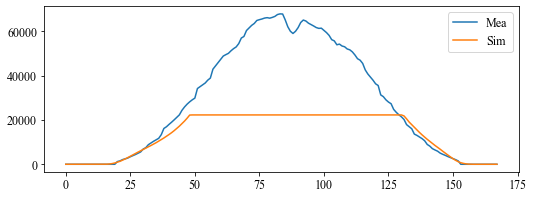

In [19]:
## Step: get skyVec
ill_List = []
for i in range(14):
    for j in range(12):
        
        fileName = "skyVectors/1020/CSta_Per_H{0}_{1}.vec".format(i+6,j*5)
        skyVec =read_skyVec(fileName)
        
        for k in range(3):  
            temp = np.dot(np.transpose(skyVec),np.reshape(x[k],(-1,3)))
        #    temp = [temp[0,0],temp[1,1],temp[2,2]]
            ill_List.append(47.4*temp[0,0]+ 119.9*temp[1,1]+ 11.6*temp[2,2])
            break

n_rows = 4
plt.figure(figsize = [8.5,3.5*4])

ax = plt.subplot(n_rows,1,1)
plt.plot(ill_List)
plt.plot(np.arange(168),dat_20_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/1.45)
ax.legend(['Mea','Sim'])


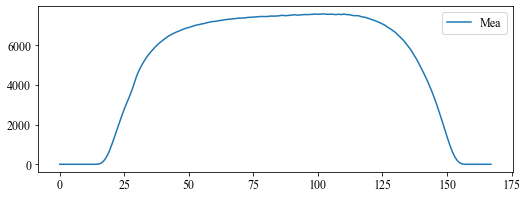

In [144]:
n_rows = 4
plt.figure(figsize = [8.5,3.5*4])

ax = plt.subplot(n_rows,1,1)
#plt.plot(ill_List)
plt.plot(np.arange(168),dat_9_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/1.45)
ax.legend(['Mea','Sim'])


In [114]:
len(dat_20_5M_Case5['2022-10-20 06:00:00':'2022-10-20 10:00:00'].iloc[:,-1]),len(dat_20_5M_Case5['2022-10-20 16:55:00':'2022-10-20 19:55:00'].iloc[:,-1])

(49, 37)

In [138]:
(sum(dat_20_5M_Case5['2022-10-20 07:40:00':'2022-10-20 10:00:00'].iloc[:,-1]/ill_List[20:49])+sum(dat_20_5M_Case5['2022-10-20 16:55:00':'2022-10-20 18:40:00'].iloc[:,-1]/ill_List[-37:-15]))/(22+29)

1.454862270656653

In [134]:
len(dat_20_5M_Case5['2022-10-20 16:55:00':'2022-10-20 18:40:00'].iloc[:,-1])

22

In [132]:

dat_20_5M_Case5['2022-10-20 16:55:00':'2022-10-20 19:55:00'].iloc[:,-1]/ill_List[-37:]

Date Time, GMT-05:00
2022-10-20 16:55:00    1.564068
2022-10-20 17:00:00    1.660643
2022-10-20 17:05:00    1.627983
2022-10-20 17:10:00    1.616278
2022-10-20 17:15:00    1.770609
2022-10-20 17:20:00    1.726226
2022-10-20 17:25:00    1.695622
2022-10-20 17:30:00    1.663320
2022-10-20 17:35:00    1.675792
2022-10-20 17:40:00    1.823696
2022-10-20 17:45:00    1.828058
2022-10-20 17:50:00    1.925316
2022-10-20 17:55:00    1.909763
2022-10-20 18:00:00    1.882894
2022-10-20 18:05:00    1.953110
2022-10-20 18:10:00    1.895422
2022-10-20 18:15:00    1.823259
2022-10-20 18:20:00    1.737087
2022-10-20 18:25:00    1.588947
2022-10-20 18:30:00    1.430212
2022-10-20 18:35:00    1.241738
2022-10-20 18:40:00    1.115354
2022-10-20 18:45:00         inf
2022-10-20 18:50:00         inf
2022-10-20 18:55:00         inf
2022-10-20 19:00:00         inf
2022-10-20 19:05:00         inf
2022-10-20 19:10:00         inf
2022-10-20 19:15:00         inf
2022-10-20 19:20:00         inf
2022-10-20 19:25:00

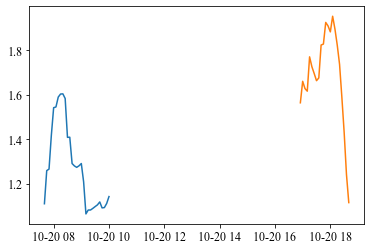

In [122]:
plt.plot(dat_20_5M_Case5['2022-10-20 06:00:00':'2022-10-20 10:00:00'].iloc[:,-1]/ill_List[:49])
plt.plot(dat_20_5M_Case5['2022-10-20 16:55:00':'2022-10-20 19:55:00'].iloc[:,-1]/ill_List[-37:])

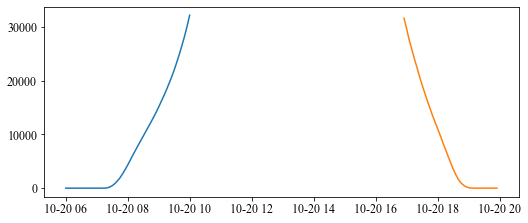

In [112]:
plt.figure(figsize=[8.5,3.5])
plt.plot(dat_20_5M_Case5['2022-10-20 06:00:00':'2022-10-20 10:00:00'].iloc[:,-1])
plt.plot(dat_20_5M_Case5['2022-10-20 16:55:00':'2022-10-20 19:55:00'].iloc[:,-1])

##### South-facing wall

In [24]:
## Step1： get matrix for roof points

os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 3  - skyDomes/skyglow.rad -i octrees/room3ph.oct < points_SFWall.txt > matrices/SFWall_point.mtx')

## Step2 : read matrix from txt file mannually

x = [[1.570718e+00,1.570718e+00,1.570718e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.344060e-03,4.344060e-03,4.344060e-03,1.339855e-02,1.339855e-02,1.339855e-02,2.182498e-02,2.182498e-02,2.182498e-02,2.873360e-02,2.873360e-02,2.873360e-02,3.485716e-02,3.485716e-02,3.485716e-02,3.951525e-02,3.951525e-02,3.951525e-02,4.207981e-02,4.207981e-02,4.207981e-02,4.296956e-02,4.296956e-02,4.296956e-02,4.228916e-02,4.228916e-02,4.228916e-02,3.951525e-02,3.951525e-02,3.951525e-02,3.475248e-02,3.475248e-02,3.475248e-02,2.852425e-02,2.852425e-02,2.852425e-02,2.130160e-02,2.130160e-02,2.130160e-02,1.376491e-02,1.376491e-02,1.376491e-02,4.291722e-03,4.291722e-03,4.291722e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.187046e-03,4.187046e-03,4.187046e-03,1.182840e-02,1.182840e-02,1.182840e-02,1.999314e-02,1.999314e-02,1.999314e-02,2.637839e-02,2.637839e-02,2.637839e-02,3.187389e-02,3.187389e-02,3.187389e-02,3.595626e-02,3.595626e-02,3.595626e-02,3.836381e-02,3.836381e-02,3.836381e-02,3.956758e-02,3.956758e-02,3.956758e-02,3.878251e-02,3.878251e-02,3.878251e-02,3.579924e-02,3.579924e-02,3.579924e-02,3.208324e-02,3.208324e-02,3.208324e-02,2.674476e-02,2.674476e-02,2.674476e-02,1.973145e-02,1.973145e-02,1.973145e-02,1.193308e-02,1.193308e-02,1.193308e-02,4.501074e-03,4.501074e-03,4.501074e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.413128e-03,1.413128e-03,1.413128e-03,1.036294e-02,1.036294e-02,1.036294e-02,2.056886e-02,2.056886e-02,2.056886e-02,2.889062e-02,2.889062e-02,2.889062e-02,3.532820e-02,3.532820e-02,3.532820e-02,3.961992e-02,3.961992e-02,3.961992e-02,4.092837e-02,4.092837e-02,4.092837e-02,3.961992e-02,3.961992e-02,3.961992e-02,3.527586e-02,3.527586e-02,3.527586e-02,2.951867e-02,2.951867e-02,2.951867e-02,2.009782e-02,2.009782e-02,2.009782e-02,1.083398e-02,1.083398e-02,1.083398e-02,1.465466e-03,1.465466e-03,1.465466e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.046761e-03,1.046761e-03,1.046761e-03,7.798373e-03,7.798373e-03,7.798373e-03,1.528272e-02,1.528272e-02,1.528272e-02,2.103991e-02,2.103991e-02,2.103991e-02,2.632605e-02,2.632605e-02,2.632605e-02,2.915231e-02,2.915231e-02,2.915231e-02,3.025141e-02,3.025141e-02,3.025141e-02,2.920464e-02,2.920464e-02,2.920464e-02,2.648307e-02,2.648307e-02,2.648307e-02,2.124926e-02,2.124926e-02,2.124926e-02,1.496869e-02,1.496869e-02,1.496869e-02,7.536683e-03,7.536683e-03,7.536683e-03,1.256114e-03,1.256114e-03,1.256114e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.187046e-03,4.187046e-03,4.187046e-03,1.282283e-02,1.282283e-02,1.282283e-02,1.946976e-02,1.946976e-02,1.946976e-02,2.344746e-02,2.344746e-02,2.344746e-02,2.517461e-02,2.517461e-02,2.517461e-02,2.349979e-02,2.349979e-02,2.349979e-02,1.967912e-02,1.967912e-02,1.967912e-02,1.229945e-02,1.229945e-02,1.229945e-02,4.291722e-03,4.291722e-03,4.291722e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.151438e-03,1.151438e-03,1.151438e-03,9.263839e-03,9.263839e-03,9.263839e-03,1.575376e-02,1.575376e-02,1.575376e-02,1.800430e-02,1.800430e-02,1.800430e-02,1.559675e-02,1.559675e-02,1.559675e-02,9.368515e-03,9.368515e-03,9.368515e-03,1.151438e-03,1.151438e-03,1.151438e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.710427e-03,4.710427e-03,4.710427e-03,9.839558e-03,9.839558e-03,9.839558e-03,5.024455e-03,5.024455e-03,5.024455e-03,0.000000e+00,0.000000e+00,0.000000e+00,7.327330e-04,7.327330e-04,7.327330e-04],
[1.570090e+00,1.570090e+00,1.570090e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.553412e-03,4.553412e-03,4.553412e-03,1.329387e-02,1.329387e-02,1.329387e-02,2.187731e-02,2.187731e-02,2.187731e-02,2.889062e-02,2.889062e-02,2.889062e-02,3.449079e-02,3.449079e-02,3.449079e-02,3.920122e-02,3.920122e-02,3.920122e-02,4.265553e-02,4.265553e-02,4.265553e-02,4.302190e-02,4.302190e-02,4.302190e-02,4.197513e-02,4.197513e-02,4.197513e-02,3.920122e-02,3.920122e-02,3.920122e-02,3.501417e-02,3.501417e-02,3.501417e-02,2.873360e-02,2.873360e-02,2.873360e-02,2.140627e-02,2.140627e-02,2.140627e-02,1.360790e-02,1.360790e-02,1.360790e-02,4.553412e-03,4.553412e-03,4.553412e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.977694e-03,3.977694e-03,3.977694e-03,1.250880e-02,1.250880e-02,1.250880e-02,1.962678e-02,1.962678e-02,1.962678e-02,2.601202e-02,2.601202e-02,2.601202e-02,3.192622e-02,3.192622e-02,3.192622e-02,3.579924e-02,3.579924e-02,3.579924e-02,3.904420e-02,3.904420e-02,3.904420e-02,3.930589e-02,3.930589e-02,3.930589e-02,3.888719e-02,3.888719e-02,3.888719e-02,3.637496e-02,3.637496e-02,3.637496e-02,3.176921e-02,3.176921e-02,3.176921e-02,2.648307e-02,2.648307e-02,2.648307e-02,1.983613e-02,1.983613e-02,1.983613e-02,1.224711e-02,1.224711e-02,1.224711e-02,4.134708e-03,4.134708e-03,4.134708e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.413128e-03,1.413128e-03,1.413128e-03,1.031060e-02,1.031060e-02,1.031060e-02,2.072588e-02,2.072588e-02,2.072588e-02,2.925698e-02,2.925698e-02,2.925698e-02,3.548521e-02,3.548521e-02,3.548521e-02,3.956758e-02,3.956758e-02,3.956758e-02,4.098071e-02,4.098071e-02,4.098071e-02,3.982927e-02,3.982927e-02,3.982927e-02,3.543288e-02,3.543288e-02,3.543288e-02,2.889062e-02,2.889062e-02,2.889062e-02,2.051652e-02,2.051652e-02,2.051652e-02,1.051995e-02,1.051995e-02,1.051995e-02,1.360790e-03,1.360790e-03,1.360790e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.897472e-04,8.897472e-04,8.897472e-04,7.641359e-03,7.641359e-03,7.641359e-03,1.528272e-02,1.528272e-02,1.528272e-02,2.124926e-02,2.124926e-02,2.124926e-02,2.632605e-02,2.632605e-02,2.632605e-02,2.894295e-02,2.894295e-02,2.894295e-02,2.988504e-02,2.988504e-02,2.988504e-02,2.909997e-02,2.909997e-02,2.909997e-02,2.580267e-02,2.580267e-02,2.580267e-02,2.151095e-02,2.151095e-02,2.151095e-02,1.486401e-02,1.486401e-02,1.486401e-02,7.903049e-03,7.903049e-03,7.903049e-03,1.151438e-03,1.151438e-03,1.151438e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.396398e-03,4.396398e-03,4.396398e-03,1.261348e-02,1.261348e-02,1.261348e-02,1.936509e-02,1.936509e-02,1.936509e-02,2.349979e-02,2.349979e-02,2.349979e-02,2.496526e-02,2.496526e-02,2.496526e-02,2.391850e-02,2.391850e-02,2.391850e-02,1.946976e-02,1.946976e-02,1.946976e-02,1.266581e-02,1.266581e-02,1.266581e-02,4.396398e-03,4.396398e-03,4.396398e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.203776e-03,1.203776e-03,1.203776e-03,9.159163e-03,9.159163e-03,9.159163e-03,1.601545e-02,1.601545e-02,1.601545e-02,1.800430e-02,1.800430e-02,1.800430e-02,1.570142e-02,1.570142e-02,1.570142e-02,9.159163e-03,9.159163e-03,9.159163e-03,1.203776e-03,1.203776e-03,1.203776e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.867441e-03,4.867441e-03,4.867441e-03,9.839558e-03,9.839558e-03,9.839558e-03,4.972117e-03,4.972117e-03,4.972117e-03,0.000000e+00,0.000000e+00,0.000000e+00,8.374092e-04,8.374092e-04,8.374092e-04],
[1.570823e+00,1.570823e+00,1.570823e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.344060e-03,4.344060e-03,4.344060e-03,1.345088e-02,1.345088e-02,1.345088e-02,2.135393e-02,2.135393e-02,2.135393e-02,2.894295e-02,2.894295e-02,2.894295e-02,3.522352e-02,3.522352e-02,3.522352e-02,3.930589e-02,3.930589e-02,3.930589e-02,4.223683e-02,4.223683e-02,4.223683e-02,4.317891e-02,4.317891e-02,4.317891e-02,4.202747e-02,4.202747e-02,4.202747e-02,3.941057e-02,3.941057e-02,3.941057e-02,3.501417e-02,3.501417e-02,3.501417e-02,2.862893e-02,2.862893e-02,2.862893e-02,2.156329e-02,2.156329e-02,2.156329e-02,1.360790e-02,1.360790e-02,1.360790e-02,4.344060e-03,4.344060e-03,4.344060e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.239384e-03,4.239384e-03,4.239384e-03,1.182840e-02,1.182840e-02,1.182840e-02,1.983613e-02,1.983613e-02,1.983613e-02,2.653540e-02,2.653540e-02,2.653540e-02,3.203090e-02,3.203090e-02,3.203090e-02,3.637496e-02,3.637496e-02,3.637496e-02,3.846848e-02,3.846848e-02,3.846848e-02,3.941057e-02,3.941057e-02,3.941057e-02,3.873017e-02,3.873017e-02,3.873017e-02,3.590392e-02,3.590392e-02,3.590392e-02,3.208324e-02,3.208324e-02,3.208324e-02,2.632605e-02,2.632605e-02,2.632605e-02,1.973145e-02,1.973145e-02,1.973145e-02,1.214243e-02,1.214243e-02,1.214243e-02,4.082370e-03,4.082370e-03,4.082370e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.517804e-03,1.517804e-03,1.517804e-03,1.051995e-02,1.051995e-02,1.051995e-02,2.046419e-02,2.046419e-02,2.046419e-02,2.862893e-02,2.862893e-02,2.862893e-02,3.558989e-02,3.558989e-02,3.558989e-02,3.930589e-02,3.930589e-02,3.930589e-02,4.103305e-02,4.103305e-02,4.103305e-02,3.909654e-02,3.909654e-02,3.909654e-02,3.538054e-02,3.538054e-02,3.538054e-02,2.915231e-02,2.915231e-02,2.915231e-02,2.062120e-02,2.062120e-02,2.062120e-02,1.067697e-02,1.067697e-02,1.067697e-02,1.360790e-03,1.360790e-03,1.360790e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.374092e-04,8.374092e-04,8.374092e-04,7.955387e-03,7.955387e-03,7.955387e-03,1.507337e-02,1.507337e-02,1.507337e-02,2.124926e-02,2.124926e-02,2.124926e-02,2.595968e-02,2.595968e-02,2.595968e-02,2.904763e-02,2.904763e-02,2.904763e-02,3.046076e-02,3.046076e-02,3.046076e-02,2.930932e-02,2.930932e-02,2.930932e-02,2.622137e-02,2.622137e-02,2.622137e-02,2.114458e-02,2.114458e-02,2.114458e-02,1.502103e-02,1.502103e-02,1.502103e-02,7.798373e-03,7.798373e-03,7.798373e-03,9.944234e-04,9.944234e-04,9.944234e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.396398e-03,4.396398e-03,4.396398e-03,1.266581e-02,1.266581e-02,1.266581e-02,1.936509e-02,1.936509e-02,1.936509e-02,2.407551e-02,2.407551e-02,2.407551e-02,2.491292e-02,2.491292e-02,2.491292e-02,2.418019e-02,2.418019e-02,2.418019e-02,1.931275e-02,1.931275e-02,1.931275e-02,1.256114e-02,1.256114e-02,1.256114e-02,4.396398e-03,4.396398e-03,4.396398e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.465466e-03,1.465466e-03,1.465466e-03,8.845134e-03,8.845134e-03,8.845134e-03,1.549207e-02,1.549207e-02,1.549207e-02,1.810897e-02,1.810897e-02,1.810897e-02,1.570142e-02,1.570142e-02,1.570142e-02,9.316177e-03,9.316177e-03,9.316177e-03,1.046761e-03,1.046761e-03,1.046761e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.972117e-03,4.972117e-03,4.972117e-03,9.682544e-03,9.682544e-03,9.682544e-03,5.024455e-03,5.024455e-03,5.024455e-03,0.000000e+00,0.000000e+00,0.000000e+00,4.710427e-04,4.710427e-04,4.710427e-04]]

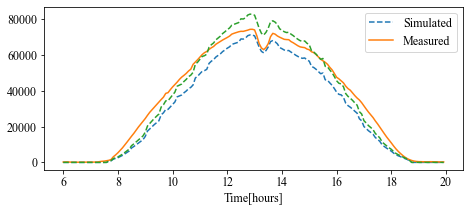

In [34]:
## Step: get skyVec
ill_List = []
for i in range(14):
    for j in range(12):
        
        fileName = "skyVectors/1020/CSta_Per_H{0}_{1}.vec".format(i+6,j*5)
        skyVec =read_skyVec(fileName)
        
        for k in range(3):  
            temp = np.dot(np.transpose(skyVec),np.reshape(x[k],(-1,3)))
        #    temp = [temp[0,0],temp[1,1],temp[2,2]]
            ill_List.append(47.4*temp[0,0]+ 119.9*temp[1,1]+ 11.6*temp[2,2])
            break

n_rows = 4
plt.figure(figsize = [7.5,3])

ax = plt.subplot()
plt.plot(ill_List,'--')
#plt.plot(np.arange(168),py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00']['Total(W/m2)']*88.2030636946749/1.15)
plt.plot(np.arange(168),py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00']['Total(W/m2)']*88.2030636946749)
plt.plot([x/0.86 for x in ill_List],'--')

ax.legend(['Simulated','Measured'])

ax.set_xticks([i*12 for i in np.arange(0,16,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,16,2)])


ax.set_xlabel('Time[hours]')
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\1020_Calib_.jpg',dpi=300,bbox_inches = 'tight')

In [26]:
from sklearn.metrics import r2_score

In [37]:
1/(sum(ill_List)/sum(py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00']['Total(W/m2)']*88.2030636946749))

1.1825330704500172

In [28]:
r2_score(ill_List,py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00']['Total(W/m2)']*88.2030636946749)

0.9344461815907663

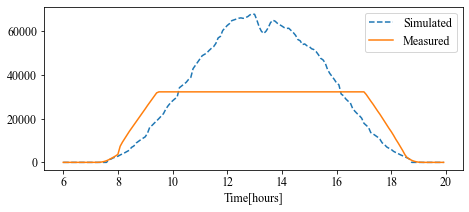

In [23]:
## Step: get skyVec
ill_List = []
for i in range(14):
    for j in range(12):
        
        fileName = "skyVectors/1020/CSta_Per_H{0}_{1}.vec".format(i+6,j*5)
        skyVec =read_skyVec(fileName)
        
        for k in range(3):  
            temp = np.dot(np.transpose(skyVec),np.reshape(x[k],(-1,3)))
        #    temp = [temp[0,0],temp[1,1],temp[2,2]]
            ill_List.append(47.4*temp[0,0]+ 119.9*temp[1,1]+ 11.6*temp[2,2])
            break

n_rows = 4
plt.figure(figsize = [7.5,3])

ax = plt.subplot()
plt.plot(ill_List,'--')
#plt.plot(np.arange(168),py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00']['Total(W/m2)']*88.2030636946749/1.15)
plt.plot(np.arange(168),dat_22_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])
ax.legend(['Simulated','Measured'])

ax.set_xticks([i*12 for i in np.arange(0,16,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,16,2)])


ax.set_xlabel('Time[hours]')
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\1020_Calib_.jpg',dpi=300,bbox_inches = 'tight')

In [ ]:
ax.set_xticks(np.arange(0,13,2))
ax.set_xticklabels(['{}'.format(i+7) for i in range(0,13,2)])
plt.savefig(r'.\Figures\CaliResult\0923_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')

In [36]:
py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00']['Total(W/m2)'].sum()*88.2030636946749/sum(ill_List)

1.1825330704500172

In [33]:
dat_22_5M_Case5['2022-10-20 06:00:00':'2022-10-20 9:25:00'].iloc[:,-1].sum()/py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 9:25:00']['Total(W/m2)'].sum()

88.20306369467495

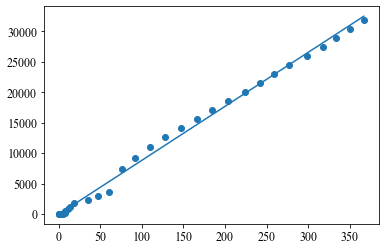

In [34]:

x_h = py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 9:25:00']['Total(W/m2)']
y_h = dat_22_5M_Case5['2022-10-20 06:00:00':'2022-10-20 9:25:00'].iloc[:,-1]

#create scatterplot
plt.scatter(x_h, y_h)

#calculate equation for trendline
z = np.polyfit(x_h, y_h, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x_h, p(x_h))

In [166]:
len(dat_22_5M_Case5['2022-10-20 06:00:00':'2022-10-20 07:20:00'].iloc[:,-1]),len(dat_22_5M_Case5['2022-10-20 07:20:00':'2022-10-20 08:55:00'])

(17, 20)

In [168]:
dat_22_5M_Case5['2022-10-20 07:35:00':'2022-10-20 08:55:00'].iloc[:,-1]/ill_List[20:37]

Date Time, GMT-05:00
2022-10-20 07:35:00    1.059194
2022-10-20 07:40:00    1.356537
2022-10-20 07:45:00    0.970657
2022-10-20 07:50:00    1.076471
2022-10-20 07:55:00    1.134776
2022-10-20 08:00:00    1.116187
2022-10-20 08:05:00    1.889315
2022-10-20 08:10:00    1.951151
2022-10-20 08:15:00    1.976188
2022-10-20 08:20:00    1.970027
2022-10-20 08:25:00    1.761881
2022-10-20 08:30:00    1.759334
2022-10-20 08:35:00    1.744396
2022-10-20 08:40:00    1.729898
2022-10-20 08:45:00    1.716754
2022-10-20 08:50:00    1.700329
2022-10-20 08:55:00    1.591969
Freq: 5T, Name: Intensity, Lux (LGR S/N: 10396216, SEN S/N: 10396216), dtype: float64

##### North-facing wall

In [16]:
## Step1： get matrix for roof points

os.system(r'C:\Radiance\bin\rfluxmtx -v -I+ -as 512 -aa 0.08 -ar 512 -ab 12 -ad 60000 -lw 0.00000002 -n 16 -y 3  - skyDomes/skyglow.rad -i octrees/room3ph.oct < points_NFWall.txt > matrices/NFWall_point.mtx')

## Step2 : read matrix from txt file mannually

x = [[1.570875e+00,1.570875e+00,1.570875e+00,4.302190e-02,4.302190e-02,4.302190e-02,4.228916e-02,4.228916e-02,4.228916e-02,3.951525e-02,3.951525e-02,3.951525e-02,3.553755e-02,3.553755e-02,3.553755e-02,2.878594e-02,2.878594e-02,2.878594e-02,2.145861e-02,2.145861e-02,2.145861e-02,1.360790e-02,1.360790e-02,1.360790e-02,4.344060e-03,4.344060e-03,4.344060e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.501074e-03,4.501074e-03,4.501074e-03,1.329387e-02,1.329387e-02,1.329387e-02,2.140627e-02,2.140627e-02,2.140627e-02,2.889062e-02,2.889062e-02,2.889062e-02,3.475248e-02,3.475248e-02,3.475248e-02,3.920122e-02,3.920122e-02,3.920122e-02,4.228916e-02,4.228916e-02,4.228916e-02,3.956758e-02,3.956758e-02,3.956758e-02,3.857316e-02,3.857316e-02,3.857316e-02,3.585158e-02,3.585158e-02,3.585158e-02,3.166453e-02,3.166453e-02,3.166453e-02,2.653540e-02,2.653540e-02,2.653540e-02,1.973145e-02,1.973145e-02,1.973145e-02,1.224711e-02,1.224711e-02,1.224711e-02,3.977694e-03,3.977694e-03,3.977694e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.134708e-03,4.134708e-03,4.134708e-03,1.229945e-02,1.229945e-02,1.229945e-02,1.994081e-02,1.994081e-02,1.994081e-02,2.611670e-02,2.611670e-02,2.611670e-02,3.197856e-02,3.197856e-02,3.197856e-02,3.637496e-02,3.637496e-02,3.637496e-02,3.873017e-02,3.873017e-02,3.873017e-02,4.103305e-02,4.103305e-02,4.103305e-02,3.961992e-02,3.961992e-02,3.961992e-02,3.538054e-02,3.538054e-02,3.538054e-02,2.909997e-02,2.909997e-02,2.909997e-02,2.041185e-02,2.041185e-02,2.041185e-02,1.078164e-02,1.078164e-02,1.078164e-02,1.256114e-03,1.256114e-03,1.256114e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.308452e-03,1.308452e-03,1.308452e-03,1.041528e-02,1.041528e-02,1.041528e-02,2.067354e-02,2.067354e-02,2.067354e-02,2.899529e-02,2.899529e-02,2.899529e-02,3.532820e-02,3.532820e-02,3.532820e-02,3.956758e-02,3.956758e-02,3.956758e-02,2.972803e-02,2.972803e-02,2.972803e-02,2.904763e-02,2.904763e-02,2.904763e-02,2.622137e-02,2.622137e-02,2.622137e-02,2.109224e-02,2.109224e-02,2.109224e-02,1.496869e-02,1.496869e-02,1.496869e-02,8.374092e-03,8.374092e-03,8.374092e-03,6.280569e-04,6.280569e-04,6.280569e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.099100e-03,1.099100e-03,1.099100e-03,7.850711e-03,7.850711e-03,7.850711e-03,1.502103e-02,1.502103e-02,1.502103e-02,2.124926e-02,2.124926e-02,2.124926e-02,2.622137e-02,2.622137e-02,2.622137e-02,2.889062e-02,2.889062e-02,2.889062e-02,2.543630e-02,2.543630e-02,2.543630e-02,2.360447e-02,2.360447e-02,2.360447e-02,1.967912e-02,1.967912e-02,1.967912e-02,1.224711e-02,1.224711e-02,1.224711e-02,4.605750e-03,4.605750e-03,4.605750e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.448736e-03,4.448736e-03,4.448736e-03,1.240412e-02,1.240412e-02,1.240412e-02,1.931275e-02,1.931275e-02,1.931275e-02,2.376149e-02,2.376149e-02,2.376149e-02,1.826599e-02,1.826599e-02,1.826599e-02,1.554441e-02,1.554441e-02,1.554441e-02,9.106825e-03,9.106825e-03,9.106825e-03,1.256114e-03,1.256114e-03,1.256114e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.203776e-03,1.203776e-03,1.203776e-03,9.316177e-03,9.316177e-03,9.316177e-03,1.538739e-02,1.538739e-02,1.538739e-02,9.996572e-03,9.996572e-03,9.996572e-03,4.710427e-03,4.710427e-03,4.710427e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.815103e-03,4.815103e-03,4.815103e-03,7.327330e-04,7.327330e-04,7.327330e-04],
[1.570875e+00,1.570875e+00,1.570875e+00,4.281254e-02,4.281254e-02,4.281254e-02,4.234150e-02,4.234150e-02,4.234150e-02,3.941057e-02,3.941057e-02,3.941057e-02,3.496183e-02,3.496183e-02,3.496183e-02,2.894295e-02,2.894295e-02,2.894295e-02,2.172030e-02,2.172030e-02,2.172030e-02,1.339855e-02,1.339855e-02,1.339855e-02,4.396398e-03,4.396398e-03,4.396398e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.448736e-03,4.448736e-03,4.448736e-03,1.350322e-02,1.350322e-02,1.350322e-02,2.135393e-02,2.135393e-02,2.135393e-02,2.889062e-02,2.889062e-02,2.889062e-02,3.459547e-02,3.459547e-02,3.459547e-02,3.961992e-02,3.961992e-02,3.961992e-02,4.223683e-02,4.223683e-02,4.223683e-02,3.935823e-02,3.935823e-02,3.935823e-02,3.878251e-02,3.878251e-02,3.878251e-02,3.616561e-02,3.616561e-02,3.616561e-02,3.187389e-02,3.187389e-02,3.187389e-02,2.648307e-02,2.648307e-02,2.648307e-02,1.941743e-02,1.941743e-02,1.941743e-02,1.250880e-02,1.250880e-02,1.250880e-02,3.977694e-03,3.977694e-03,3.977694e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.030032e-03,4.030032e-03,4.030032e-03,1.235179e-02,1.235179e-02,1.235179e-02,1.962678e-02,1.962678e-02,1.962678e-02,2.674476e-02,2.674476e-02,2.674476e-02,3.197856e-02,3.197856e-02,3.197856e-02,3.590392e-02,3.590392e-02,3.590392e-02,3.883485e-02,3.883485e-02,3.883485e-02,4.098071e-02,4.098071e-02,4.098071e-02,3.951525e-02,3.951525e-02,3.951525e-02,3.543288e-02,3.543288e-02,3.543288e-02,2.909997e-02,2.909997e-02,2.909997e-02,2.067354e-02,2.067354e-02,2.067354e-02,1.031060e-02,1.031060e-02,1.031060e-02,1.413128e-03,1.413128e-03,1.413128e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.413128e-03,1.413128e-03,1.413128e-03,1.046761e-02,1.046761e-02,1.046761e-02,2.067354e-02,2.067354e-02,2.067354e-02,2.862893e-02,2.862893e-02,2.862893e-02,3.558989e-02,3.558989e-02,3.558989e-02,3.935823e-02,3.935823e-02,3.935823e-02,3.025141e-02,3.025141e-02,3.025141e-02,2.873360e-02,2.873360e-02,2.873360e-02,2.648307e-02,2.648307e-02,2.648307e-02,2.109224e-02,2.109224e-02,2.109224e-02,1.533506e-02,1.533506e-02,1.533506e-02,7.955387e-03,7.955387e-03,7.955387e-03,6.803950e-04,6.803950e-04,6.803950e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.944234e-04,9.944234e-04,9.944234e-04,7.746035e-03,7.746035e-03,7.746035e-03,1.512570e-02,1.512570e-02,1.512570e-02,2.124926e-02,2.124926e-02,2.124926e-02,2.627371e-02,2.627371e-02,2.627371e-02,2.930932e-02,2.930932e-02,2.930932e-02,2.522695e-02,2.522695e-02,2.522695e-02,2.297641e-02,2.297641e-02,2.297641e-02,1.915573e-02,1.915573e-02,1.915573e-02,1.277049e-02,1.277049e-02,1.277049e-02,4.396398e-03,4.396398e-03,4.396398e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.396398e-03,4.396398e-03,4.396398e-03,1.261348e-02,1.261348e-02,1.261348e-02,1.920807e-02,1.920807e-02,1.920807e-02,2.376149e-02,2.376149e-02,2.376149e-02,1.842300e-02,1.842300e-02,1.842300e-02,1.617246e-02,1.617246e-02,1.617246e-02,8.949811e-03,8.949811e-03,8.949811e-03,1.099100e-03,1.099100e-03,1.099100e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.151438e-03,1.151438e-03,1.151438e-03,9.368515e-03,9.368515e-03,9.368515e-03,1.543973e-02,1.543973e-02,1.543973e-02,9.473191e-03,9.473191e-03,9.473191e-03,4.919779e-03,4.919779e-03,4.919779e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.762765e-03,4.762765e-03,4.762765e-03,9.944234e-04,9.944234e-04,9.944234e-04],
[1.570980e+00,1.570980e+00,1.570980e+00,4.328359e-02,4.328359e-02,4.328359e-02,4.228916e-02,4.228916e-02,4.228916e-02,3.925355e-02,3.925355e-02,3.925355e-02,3.480482e-02,3.480482e-02,3.480482e-02,2.894295e-02,2.894295e-02,2.894295e-02,2.145861e-02,2.145861e-02,2.145861e-02,1.339855e-02,1.339855e-02,1.339855e-02,4.448736e-03,4.448736e-03,4.448736e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.291722e-03,4.291722e-03,4.291722e-03,1.318919e-02,1.318919e-02,1.318919e-02,2.161562e-02,2.161562e-02,2.161562e-02,2.889062e-02,2.889062e-02,2.889062e-02,3.511885e-02,3.511885e-02,3.511885e-02,3.941057e-02,3.941057e-02,3.941057e-02,4.228916e-02,4.228916e-02,4.228916e-02,3.920122e-02,3.920122e-02,3.920122e-02,3.852082e-02,3.852082e-02,3.852082e-02,3.606093e-02,3.606093e-02,3.606093e-02,3.234493e-02,3.234493e-02,3.234493e-02,2.616904e-02,2.616904e-02,2.616904e-02,1.999314e-02,1.999314e-02,1.999314e-02,1.224711e-02,1.224711e-02,1.224711e-02,4.030032e-03,4.030032e-03,4.030032e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.030032e-03,4.030032e-03,4.030032e-03,1.266581e-02,1.266581e-02,1.266581e-02,1.920807e-02,1.920807e-02,1.920807e-02,2.684943e-02,2.684943e-02,2.684943e-02,3.224025e-02,3.224025e-02,3.224025e-02,3.595626e-02,3.595626e-02,3.595626e-02,3.883485e-02,3.883485e-02,3.883485e-02,4.035265e-02,4.035265e-02,4.035265e-02,3.961992e-02,3.961992e-02,3.961992e-02,3.522352e-02,3.522352e-02,3.522352e-02,2.894295e-02,2.894295e-02,2.894295e-02,2.067354e-02,2.067354e-02,2.067354e-02,1.041528e-02,1.041528e-02,1.041528e-02,1.256114e-03,1.256114e-03,1.256114e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.360790e-03,1.360790e-03,1.360790e-03,1.041528e-02,1.041528e-02,1.041528e-02,2.062120e-02,2.062120e-02,2.062120e-02,2.878594e-02,2.878594e-02,2.878594e-02,3.558989e-02,3.558989e-02,3.558989e-02,3.941057e-02,3.941057e-02,3.941057e-02,3.030374e-02,3.030374e-02,3.030374e-02,2.899529e-02,2.899529e-02,2.899529e-02,2.601202e-02,2.601202e-02,2.601202e-02,2.177264e-02,2.177264e-02,2.177264e-02,1.496869e-02,1.496869e-02,1.496869e-02,7.903049e-03,7.903049e-03,7.903049e-03,8.897472e-04,8.897472e-04,8.897472e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.280569e-04,6.280569e-04,6.280569e-04,8.164739e-03,8.164739e-03,8.164739e-03,1.538739e-02,1.538739e-02,1.538739e-02,2.088289e-02,2.088289e-02,2.088289e-02,2.627371e-02,2.627371e-02,2.627371e-02,2.941400e-02,2.941400e-02,2.941400e-02,2.491292e-02,2.491292e-02,2.491292e-02,2.365681e-02,2.365681e-02,2.365681e-02,1.957444e-02,1.957444e-02,1.957444e-02,1.261348e-02,1.261348e-02,1.261348e-02,4.344060e-03,4.344060e-03,4.344060e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.501074e-03,4.501074e-03,4.501074e-03,1.214243e-02,1.214243e-02,1.214243e-02,1.957444e-02,1.957444e-02,1.957444e-02,2.339512e-02,2.339512e-02,2.339512e-02,1.837066e-02,1.837066e-02,1.837066e-02,1.538739e-02,1.538739e-02,1.538739e-02,9.368515e-03,9.368515e-03,9.368515e-03,1.256114e-03,1.256114e-03,1.256114e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.256114e-03,1.256114e-03,1.256114e-03,9.002149e-03,9.002149e-03,9.002149e-03,1.606779e-02,1.606779e-02,1.606779e-02,9.734882e-03,9.734882e-03,9.734882e-03,4.658089e-03,4.658089e-03,4.658089e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.605750e-03,4.605750e-03,4.605750e-03,8.897472e-04,8.897472e-04,8.897472e-04]]

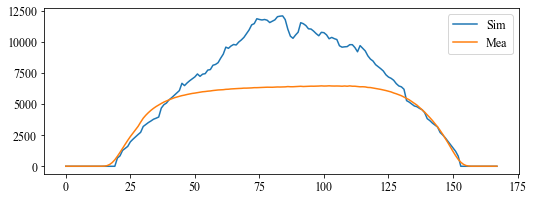

In [18]:
## Step: get skyVec
ill_List = []
for i in range(14):
    for j in range(12):
        
        fileName = "skyVectors/1020/CSta_Per_H{0}_{1}.vec".format(i+6,j*5)
        skyVec =read_skyVec(fileName)
        
        for k in range(3):  
            temp = np.dot(np.transpose(skyVec),np.reshape(x[k],(-1,3)))
        #    temp = [temp[0,0],temp[1,1],temp[2,2]]
            ill_List.append(47.4*temp[0,0]+ 119.9*temp[1,1]+ 11.6*temp[2,2])
            break

n_rows = 4
plt.figure(figsize = [8.5,3.5*4])

ax = plt.subplot(n_rows,1,1)
plt.plot(ill_List)
plt.plot(np.arange(168),dat_9_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/1.7)
ax.legend(['Sim','Mea'])


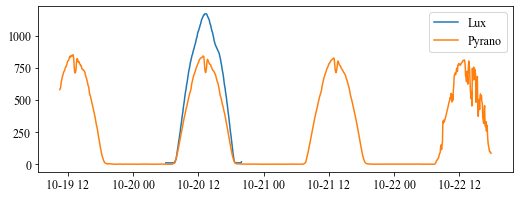

In [28]:
n_rows = 4
plt.figure(figsize = [8.5,3.5*4])


ax = plt.subplot(n_rows,1,1)
plt.plot(dat_18_5M_Case5.iloc[:,-1])

plt.plot(py_DF_5M_Case5['Total(W/m2)'])

ax.legend(['Lux','Pyrano'])

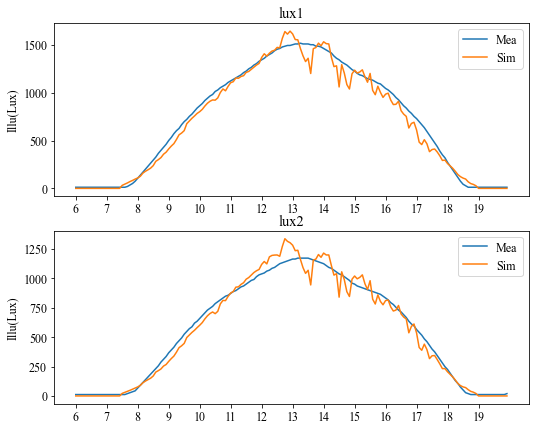

In [31]:
n_rows = 2
plt.figure(figsize = [8.5,3.5*n_rows])


ax = plt.subplot(n_rows,1,1)
plt.plot(np.arange(168),dat_17_5M_Case2['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1006_5M.iloc[:,0]*6)
ax.legend(['Mea','Sim'])
ax.set_title('lux1')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])



ax = plt.subplot(n_rows,1,2)
plt.plot(np.arange(168),dat_18_5M_Case2['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])
plt.plot(simu_result_1006_5M.iloc[:,1]*6)
ax.legend(['Mea','Sim'])
ax.set_title('lux2')
#ax.set_xlabel('Hour')
ax.set_ylabel('Illu(Lux)')
ax.set_xticks([i*12 for i in np.arange(14)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(14)])

plt.savefig('Figures/1020_Blind75_V.png',dpi=300)

In [22]:
dat_09 = pd.read_csv(path+'\\'+'Sensor_09.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_09=dat_09.iloc[:,:-2]
dat_09 = dat_09.set_index("Date Time, GMT-05:00")

dat_17 = pd.read_csv(path+'\\'+'Sensor_17.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_17=dat_17.iloc[:,:-2]
dat_17 = dat_17.set_index("Date Time, GMT-05:00")

dat_18 = pd.read_csv(path+'\\'+'Sensor_18.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_18=dat_18.iloc[:,:-3]
dat_18 = dat_18.set_index("Date Time, GMT-05:00")

dat_19 = pd.read_csv(path+'\\'+'Sensor_19.csv',header=1)
dat_20 = pd.read_csv(path+'\\'+'Sensor_20.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_20=dat_20.iloc[:-3,:-3]
dat_20 = dat_20.set_index("Date Time, GMT-05:00")



dat_22 = pd.read_csv(path+'\\'+'Sensor_22.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_22=dat_22.iloc[:,:-3]
dat_22 = dat_22.set_index("Date Time, GMT-05:00")

dat_23 = pd.read_csv(path+'\\'+'Sensor_23.csv',header=1,parse_dates=[1],date_parser = date_parser_func2)
dat_23=dat_23.iloc[:,:-3]
dat_23 = dat_23.set_index("Date Time, GMT-05:00")


dat_17_resample = dat_17.resample('1H').mean()
dat_17_resample = dat_17.resample('1H').mean()
dat_18_resample = dat_18.resample('1H').mean()
dat_20_resample = dat_20.resample('1H').mean()
dat_23_resample = dat_23.resample('1H').mean()
dat_22_resample = dat_22.resample('1H').mean()

# resample to 5Minute
dat_17_5M_Case2 = dat_17.resample('5T').mean()
dat_09_5M_Case2 = dat_09.resample('5T').mean()
dat_18_5M_Case2 = dat_18.resample('5T').mean()
dat_20_5M_Case2 = dat_20.resample('5T').mean()
dat_22_5M_Case2 = dat_22.resample('5T').mean()
dat_23_5M_Case2 = dat_23.resample('5T').mean()

NameError: name 'path' is not defined

#### 10/20

In [26]:
### generate sky

pyrano_DF = py_DF_5M_Case5['2022-10-20 06:00:00':'2022-10-20 20:00:00']

#from 6am to 8pm

for i in range(14):
    for j in range(12):
        Dir_rad = pyrano_DF.iloc[i*12+j,-2]-pyrano_DF.iloc[i*12+j,-1]
        Dif_rad = pyrano_DF.iloc[i*12+j,-1]
        print("hour:",i+6,"minute:",j*5,pyrano_DF.index[i*12+j],Dir_rad,Dif_rad)
        
        
        #print(r'C:\Radiance\bin\gendaylit 9 24 +{}.2 -a 30.6 -o 96.3 -m 90 -W {} {} >  skies/9_23_{}.sky'.format(i,Dir_rad,Dif_rad,i+1))
        # offset for Apparent solar time = LST-1.3 hr. 
        os.system(r'C:\Radiance\bin\gendaylit 10 20 +{} -a 30.6 -o 96.3 -m 90 -W {} {} > skies/gendaylit/1020/10_20_H{}_{}.sky'.format(i+6+round(j*5/60,2)-1.17,Dir_rad,Dif_rad,i+6,j*5))

        # generate skyvec
        os.system(r"C:\Radiance\bin\genskyvec -m 1 < skies/gendaylit/1020/10_20_H{0}_{1}.sky > skyVectors/1020/CSta_Per_H{0}_{1}.vec".format(i+6,j*5))
        
   

hour: 6 minute: 0 2022-10-20 06:00:00 1.1576202433333331 1.0545359333333337
hour: 6 minute: 5 2022-10-20 06:05:00 1.2703186666666697 1.1891174900000003
hour: 6 minute: 10 2022-10-20 06:10:00 1.416936006666667 1.4090434600000035
hour: 6 minute: 15 2022-10-20 06:15:00 0.9464476100000033 0.810538436666666
hour: 6 minute: 20 2022-10-20 06:20:00 0.24261793645484853 0.6536272140468234
hour: 6 minute: 25 2022-10-20 06:25:00 0.3063645633333335 0.6442262533333338
hour: 6 minute: 30 2022-10-20 06:30:00 0.2636923299999996 0.6540737000000002
hour: 6 minute: 35 2022-10-20 06:35:00 0.20898439999999874 0.6081189766666668
hour: 6 minute: 40 2022-10-20 06:40:00 0.2757281333333327 0.5971773766666671
hour: 6 minute: 45 2022-10-20 06:45:00 0.37857912666666715 0.7240997933333331
hour: 6 minute: 50 2022-10-20 06:50:00 0.39170901000000136 0.7985026266666666
hour: 6 minute: 55 2022-10-20 06:55:00 0.47924173333333353 0.7175348866666668
hour: 7 minute: 0 2022-10-20 07:00:00 0.7243334000000025 0.789749383333333


hour: 15 minute: 0 2022-10-20 15:00:00 632.3842222799997 80.62068353666672
hour: 15 minute: 5 2022-10-20 15:05:00 616.7530779966669 83.32435028666647
hour: 15 minute: 10 2022-10-20 15:10:00 606.6299240233327 87.89355788666671
hour: 15 minute: 15 2022-10-20 15:15:00 592.470422593333 89.93525851
hour: 15 minute: 20 2022-10-20 15:20:00 580.2585260233328 87.3771148133333
hour: 15 minute: 25 2022-10-20 15:25:00 569.6451953499991 82.9129464866667
hour: 15 minute: 30 2022-10-20 15:30:00 557.3928103599995 85.96783812666663
hour: 15 minute: 35 2022-10-20 15:35:00 549.7435520566673 83.78499117666655
hour: 15 minute: 40 2022-10-20 15:40:00 538.9059163033326 82.32100657333329
hour: 15 minute: 45 2022-10-20 15:45:00 525.0024517066659 77.06247865000006
hour: 15 minute: 50 2022-10-20 15:50:00 511.2554492833339 74.87525493000004
hour: 15 minute: 55 2022-10-20 15:55:00 486.9344987933338 76.36878186666671
hour: 16 minute: 0 2022-10-20 16:00:00 464.6202357999994 74.47260444999999
hour: 16 minute: 5 2022-

In [97]:
for i in range(14):
    for j in range(12):
        # calculate illuminance and post-process
        
        ### part 1 w blinds
        os.system('dctimestep matrices/Case3/v1.mtx matrices/blinds_venN75.xml matrices/Case3/daylight1.dmx skyVectors/1020/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1020_5M/3ph_H{0}_{1}_p1.ill'.format(i+6,j*5))
        
        ### part 2 w/o blinds (clear)
        os.system('dctimestep matrices/Case3/v2.mtx matrices/clear.xml matrices/Case3/daylight2.dmx skyVectors/1020/CSta_Per_H{0}_{1}.vec | rmtxop -fa -c 47.4 119.9 11.6 - > Results/1020_5M/3ph_H{0}_{1}_p2.ill'.format(i+6,j*5))
        
        # combine these two part 
        os.system(r'C:\Radiance\bin\rmtxop Results/1020_5M/3ph_H{0}_{1}_p1.ill + Results/1020_5M/3ph_H{0}_{1}_p2.ill > Results/1020_5M/3ph_H{0}_{1}.ill'.format(i+6,j*5))

In [49]:
#read flux data
simu_result_1020_5M = []
for i in range(14):
    for j in range(12):
        simu_result_1020_5M.append(read_result(r'Results\1020_5M\3ph_H{}_{}.ill'.format(i+6,j*5)))

simu_result_1020_5M = pd.DataFrame(simu_result_1020_5M)

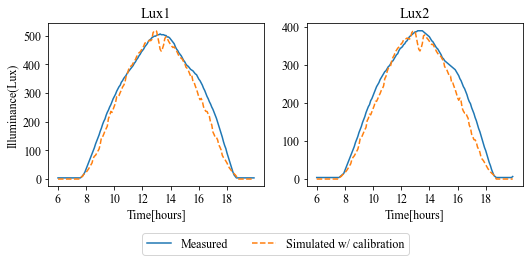

In [33]:
plt.figure(figsize=[8.5,3])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5*1.5)
plt.plot(np.arange(168),simu_result_1020_5M.iloc[:,0]*1.5,'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5*1.5)
plt.plot(np.arange(168),simu_result_1020_5M.iloc[:,1]*1.5,'--')

ax.set_xlabel('Time[hours]')
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.25))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\1020_5M_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')

In [31]:
print("=====CV_RMSE=======")

print("cv_rmse of sensr 1:",cv_rmse(simu_result_1020_5M.iloc[:,0]*2,dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5))
print("nmbe of sensr 1:",nmbe(simu_result_1020_5M.iloc[:,0],dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5))
print("r2 of sensr 1:",r2_score(simu_result_1020_5M.iloc[:,0],dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5))


print("cv_rmse of sensr 2:",cv_rmse(simu_result_1020_5M.iloc[:,1],dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5))
print("nmbe of sensr 2:",nmbe(simu_result_1020_5M.iloc[:,1],dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5))
print("r2 of sensr 2:",r2_score(simu_result_1020_5M.iloc[:,1],dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5))

print("cv_rmse of sensr 3:",cv_rmse(simu_result_1020_5M.iloc[:,2],dat_23_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,3]))
print("nmbe of sensr 3:",nmbe(simu_result_1020_5M.iloc[:,2],dat_23_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,3]))
print("r2 of sensor 3:",r2_score(simu_result_1020_5M.iloc[:,2],dat_23_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,3]))

print("cv_rmse of sensor 5:",cv_rmse(simu_result_1020_5M.iloc[:,4],dat_22_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,3]))
print("nmbe of sensor 5:",nmbe(simu_result_1020_5M.iloc[:,4],dat_22_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,3]))
print("r2 of sensr 5:",r2_score(simu_result_1020_5M.iloc[:,4],dat_22_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,3]))

=====CV_RMSE=======
cv_rmse of sensr 1: 1.1427159570219154
nmbe of sensr 1: -0.08210896869343935
r2 of sensr 1: 0.9718470210568154
cv_rmse of sensr 2: 0.1570413595965464
nmbe of sensr 2: -0.10568498299392658
r2 of sensr 2: 0.9567862969782958


NameError: name 'dat_23_5M_Case5' is not defined

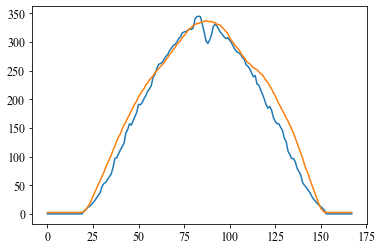

In [117]:
plt.plot(np.arange(168),simu_result_1020_5M.iloc[:,0])
plt.plot(np.arange(168),dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5)

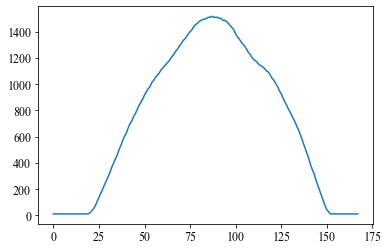

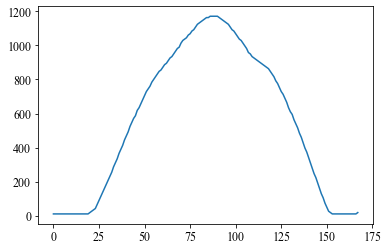

In [108]:
plt.plot(np.arange(168),dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])

[Text(0, 0, '6'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '12'),
 Text(0, 0, '14'),
 Text(0, 0, '16'),
 Text(0, 0, '18')]

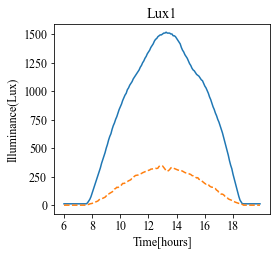

In [105]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1020_5M.iloc[:,0],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


[Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19')]

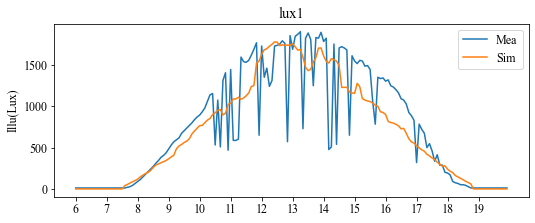

In [123]:
plt.figure(figsize=[8.5,3.5])
ax = plt.subplot(1,2,1)
plt.plot(np.arange(168),dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1020_5M.iloc[:,0],'--')

ax.set_xlabel('Time[hours]')
ax.set_ylabel('Illuminance(Lux)')
ax.set_title('Lux1')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])


ax = plt.subplot(1,2,2)
plt.plot(np.arange(168),dat_18_5M_Case3['2022-10-05 06:00:00':'2022-10-05 19:55:00'].iloc[:,-1])
plt.plot(np.arange(168),simu_result_1005_5M.iloc[:,1],'--')

ax.set_xlabel('Time[hours]')
ax.set_title('Lux2')
ax.set_xticks([i*12 for i in np.arange(0,14,2)])
ax.set_xticklabels(['{}'.format(i+6) for i in np.arange(0,14,2)])

ax.legend(['Measured','Simulated w/ calibration'], ncol = 2,bbox_to_anchor=(0.5, -0.25))
plt.savefig(r'D:\Users\fengf\Onedrive\Google Drive\Desktop\Lighting\Figure\1005_5M_sensor1&2.jpg',dpi=300,bbox_inches = 'tight')

### Uncertainty analysis

#### 09/22

In [33]:
res_Sensor1_0922 = (np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1) - np.array(simu_result_0922_5M.iloc[:,0]))/(np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]).sum()/168)
res_Sensor2_0922 = (np.array(dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1)-np.array(simu_result_0922_5M.iloc[:,1]))/(np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]).sum()/168)

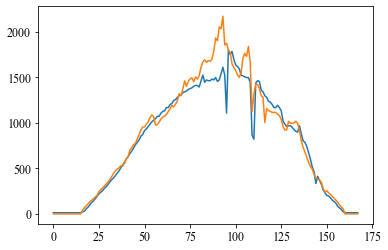

In [31]:
plt.plot(np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1)) 
plt.plot(np.array(simu_result_0922_5M.iloc[:,0]))

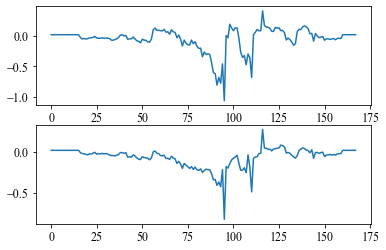

In [32]:

ax = plt.subplot(2,1,1)
plt.plot(res_Sensor1_0922)

ax = plt.subplot(2,1,2)
plt.plot(res_Sensor2_0922)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  0.,  7., 16.,  7.,
        27., 58., 42.,  3.,  0.,  0.,  1.]),
 array([-0.81847772, -0.76399615, -0.70951458, -0.65503301, -0.60055144,
        -0.54606987, -0.4915883 , -0.43710673, -0.38262516, -0.32814359,
        -0.27366201, -0.21918044, -0.16469887, -0.1102173 , -0.05573573,
        -0.00125416,  0.05322741,  0.10770898,  0.16219055,  0.21667212,
         0.27115369]),
 <a list of 20 Patch objects>)

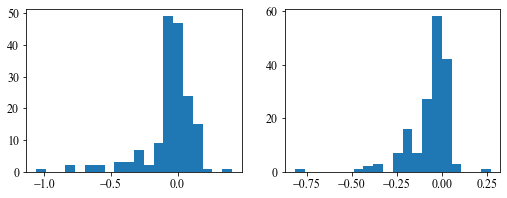

In [33]:
plt.figure(figsize = [8.5,3])
ax = plt.subplot(1,2,1)
plt.hist(res_Sensor1_0922,bins = 20)

ax = plt.subplot(1,2,2)
plt.hist(res_Sensor2_0922,bins = 20)

#### 09/23

In [61]:
res_Sensor1_0923 = (np.array(dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]) - np.array(simu_result_0923_5M.iloc[:,0]))/(np.array(dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]).sum()/168)
res_Sensor2_0923 = (np.array(dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3])-np.array(simu_result_0923_5M.iloc[:,1]))/(np.array(dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]).sum()/168)

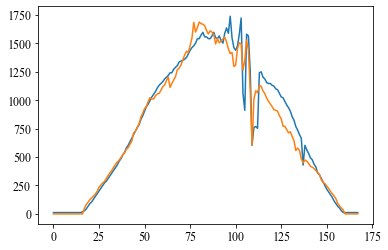

In [38]:
plt.plot(np.arange(168),dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3])
plt.plot(simu_result_0923_5M.iloc[:,0])

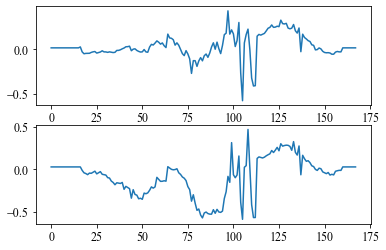

In [39]:
ax = plt.subplot(2,1,1)
plt.plot(res_Sensor1_0923)

ax = plt.subplot(2,1,2)
plt.plot(res_Sensor2_0923)

(array([ 5., 10.,  3.,  3.,  6.,  6.,  7.,  7., 12., 16., 22., 39.,  2.,
         7.,  8.,  4.,  8.,  2.,  0.,  1.]),
 array([-0.59091849, -0.53776653, -0.48461457, -0.4314626 , -0.37831064,
        -0.32515867, -0.27200671, -0.21885475, -0.16570278, -0.11255082,
        -0.05939886, -0.00624689,  0.04690507,  0.10005703,  0.153209  ,
         0.20636096,  0.25951292,  0.31266489,  0.36581685,  0.41896881,
         0.47212078]),
 <a list of 20 Patch objects>)

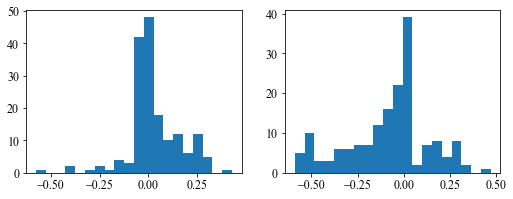

In [40]:
plt.figure(figsize = [8.5,3])
ax = plt.subplot(1,2,1)
plt.hist(res_Sensor1_0923,bins = 20)

ax = plt.subplot(1,2,2)
plt.hist(res_Sensor2_0923,bins = 20)

#### 09/27

In [63]:
res_Sensor1_0927 = (np.array(dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]-np.array(simu_result_0927_5M.iloc[:,0])))/(np.array(dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]).sum()/168)

res_Sensor2_0927 = (np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]-np.array(simu_result_0927_5M.iloc[:,1])))/(np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]).sum()/168)

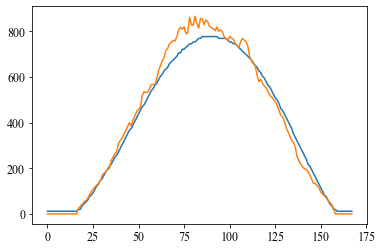

In [42]:
plt.plot(np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]))
plt.plot(np.array(simu_result_0927_5M.iloc[:,1]))

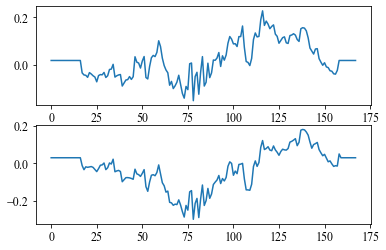

In [43]:
ax = plt.subplot(2,1,1)
plt.plot(res_Sensor1_0927)

ax = plt.subplot(2,1,2)
plt.plot(res_Sensor2_0927)

(array([ 3.,  1.,  1.,  9.,  5.,  1.,  9.,  6.,  8., 14., 11., 19., 15.,
        29.,  6., 12.,  6.,  8.,  1.,  4.]),
 array([-0.29664036, -0.27279898, -0.2489576 , -0.22511623, -0.20127485,
        -0.17743347, -0.1535921 , -0.12975072, -0.10590934, -0.08206796,
        -0.05822659, -0.03438521, -0.01054383,  0.01329754,  0.03713892,
         0.0609803 ,  0.08482168,  0.10866305,  0.13250443,  0.15634581,
         0.18018718]),
 <a list of 20 Patch objects>)

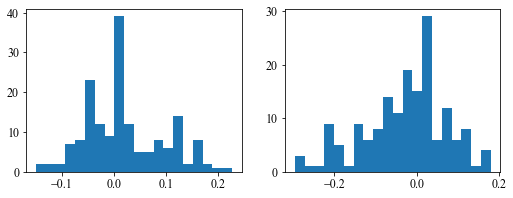

In [44]:
plt.figure(figsize = [8.5,3])
ax = plt.subplot(1,2,1)
plt.hist(res_Sensor1_0927,bins = 20)

ax = plt.subplot(1,2,2)
plt.hist(res_Sensor2_0927,bins = 20)

#### 10/03

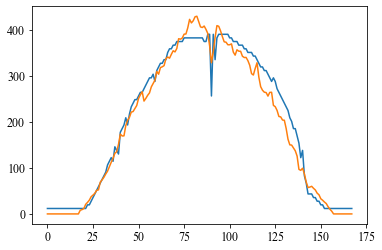

In [47]:
plt.plot(np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]))
plt.plot(np.array(simu_result_1003_5M.iloc[:,1]))

In [64]:
res_Sensor1_1003 = (np.array(dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]-np.array(simu_result_1003_5M.iloc[:,0])))/(np.array(dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]).sum()/168)

res_Sensor2_1003 = (np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]-np.array(simu_result_1003_5M.iloc[:,1])))/(np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]).sum()/168)

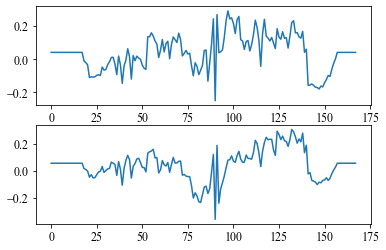

In [49]:
ax = plt.subplot(2,1,1)
plt.plot(res_Sensor1_1003)

ax = plt.subplot(2,1,2)
plt.plot(res_Sensor2_1003)

(array([ 1.,  0.,  0.,  3.,  1.,  4.,  2.,  5.,  9., 15., 13., 15., 46.,
        14., 10.,  6.,  5., 11.,  4.,  4.]),
 array([-0.35755424, -0.3242359 , -0.29091756, -0.25759922, -0.22428088,
        -0.19096254, -0.1576442 , -0.12432586, -0.09100752, -0.05768918,
        -0.02437084,  0.0089475 ,  0.04226584,  0.07558418,  0.10890252,
         0.14222086,  0.1755392 ,  0.20885753,  0.24217587,  0.27549421,
         0.30881255]),
 <a list of 20 Patch objects>)

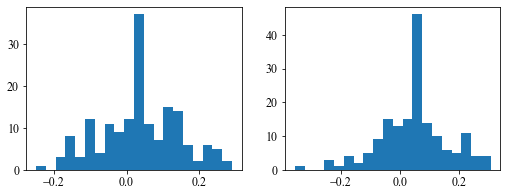

In [50]:
plt.figure(figsize = [8.5,3])
ax = plt.subplot(1,2,1)
plt.hist(res_Sensor1_1003,bins = 20)

ax = plt.subplot(1,2,2)
plt.hist(res_Sensor2_1003,bins = 20)

#### 10/06

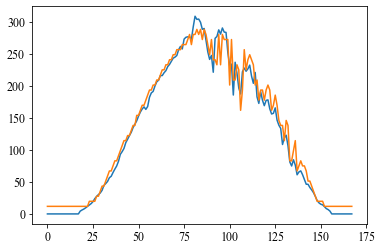

In [53]:
plt.plot(np.array(simu_result_1006_5M.iloc[:,1]))
plt.plot(np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]))

In [65]:
res_Sensor1_1006 = (np.array(dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]-np.array(simu_result_1006_5M.iloc[:,0])))/(np.array(dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]).sum()/168)

res_Sensor2_1006 = (np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]-np.array(simu_result_1006_5M.iloc[:,1])))/(np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]).sum()/168)

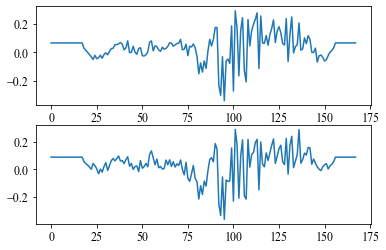

In [55]:
ax = plt.subplot(2,1,1)
plt.plot(res_Sensor1_1006)

ax = plt.subplot(2,1,2)
plt.plot(res_Sensor2_1006)

(array([ 2.,  0.,  0.,  1.,  4.,  2.,  1.,  2.,  6.,  4.,  8., 31., 27.,
        48., 11.,  6.,  5.,  6.,  2.,  2.]),
 array([-0.36374287, -0.3309761 , -0.29820933, -0.26544257, -0.2326758 ,
        -0.19990903, -0.16714227, -0.1343755 , -0.10160873, -0.06884197,
        -0.0360752 , -0.00330844,  0.02945833,  0.0622251 ,  0.09499186,
         0.12775863,  0.1605254 ,  0.19329216,  0.22605893,  0.2588257 ,
         0.29159246]),
 <a list of 20 Patch objects>)

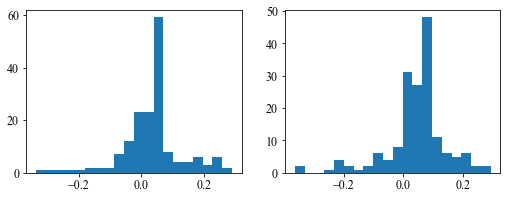

In [56]:
plt.figure(figsize = [8.5,3])
ax = plt.subplot(1,2,1)
plt.hist(res_Sensor1_1006,bins = 20)

ax = plt.subplot(1,2,2)
plt.hist(res_Sensor2_1006,bins = 20)

#### 10/20

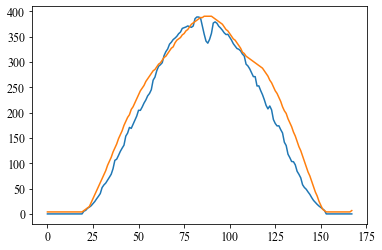

In [60]:
plt.plot(np.array(simu_result_1020_5M.iloc[:,1]*1.5))
plt.plot(np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5*1.5))

In [66]:
res_Sensor1_1020 = (np.array(dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5-np.array(simu_result_1020_5M.iloc[:,0])))/(np.array(dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5).sum()/168)

res_Sensor2_1020 = (np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5-np.array(simu_result_1020_5M.iloc[:,1])))/(np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1]/4.5).sum()/168)

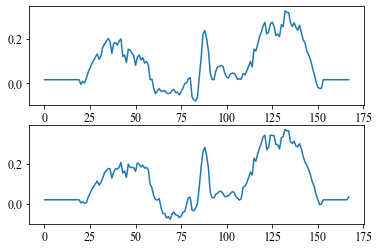

In [29]:
ax = plt.subplot(2,1,1)
plt.plot(res_Sensor1_1020)

ax = plt.subplot(2,1,2)
plt.plot(res_Sensor2_1020)

(array([ 7.,  7.,  3.,  8., 47., 12.,  6.,  8.,  4.,  6.,  7., 15.,  8.,
         2.,  2.,  5.,  9.,  2.,  7.,  3.]),
 array([-0.07675474, -0.05425329, -0.03175183, -0.00925037,  0.01325109,
         0.03575255,  0.05825401,  0.08075547,  0.10325693,  0.12575838,
         0.14825984,  0.1707613 ,  0.19326276,  0.21576422,  0.23826568,
         0.26076714,  0.2832686 ,  0.30577006,  0.32827151,  0.35077297,
         0.37327443]),
 <a list of 20 Patch objects>)

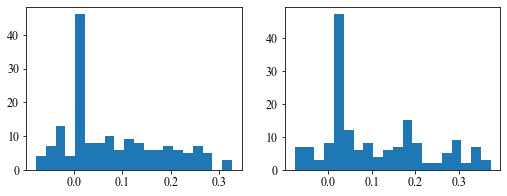

In [30]:
plt.figure(figsize = [8.5,3])
ax = plt.subplot(1,2,1)
plt.hist(res_Sensor1_1020,bins = 20)

ax = plt.subplot(1,2,2)
plt.hist(res_Sensor2_1020,bins = 20)

#### Sum

(array([ 7.,  7.,  3.,  8., 47., 12.,  6.,  8.,  4.,  6.,  7., 15.,  8.,
         2.,  2.,  5.,  9.,  2.,  7.,  3.]),
 array([-0.07675474, -0.05425329, -0.03175183, -0.00925037,  0.01325109,
         0.03575255,  0.05825401,  0.08075547,  0.10325693,  0.12575838,
         0.14825984,  0.1707613 ,  0.19326276,  0.21576422,  0.23826568,
         0.26076714,  0.2832686 ,  0.30577006,  0.32827151,  0.35077297,
         0.37327443]),
 <a list of 20 Patch objects>)

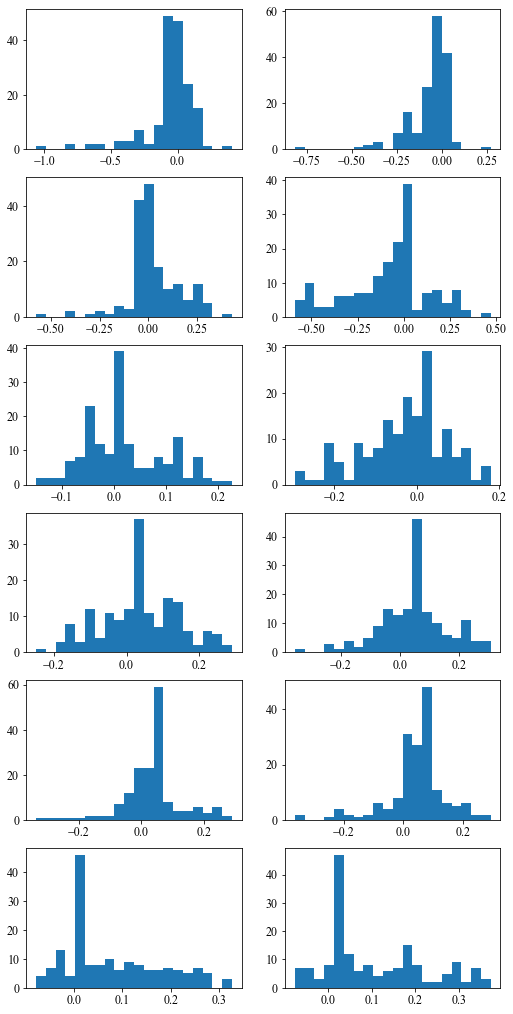

In [34]:
plt.figure(figsize = [8.5,3*6])
ax = plt.subplot(6,2,1)
plt.hist(res_Sensor1_0922,bins = 20)

ax = plt.subplot(6,2,2)
plt.hist(res_Sensor2_0922,bins = 20)


ax = plt.subplot(6,2,3)
plt.hist(res_Sensor1_0923,bins = 20)

ax = plt.subplot(6,2,4)
plt.hist(res_Sensor2_0923,bins = 20)

ax = plt.subplot(6,2,5)
plt.hist(res_Sensor1_0927,bins = 20)

ax = plt.subplot(6,2,6)
plt.hist(res_Sensor2_0927,bins = 20)


ax = plt.subplot(6,2,7)
plt.hist(res_Sensor1_1003,bins = 20)

ax = plt.subplot(6,2,8)
plt.hist(res_Sensor2_1003,bins = 20)

ax = plt.subplot(6,2,9)
plt.hist(res_Sensor1_1006,bins = 20)

ax = plt.subplot(6,2,10)
plt.hist(res_Sensor2_1006,bins = 20)

ax = plt.subplot(6,2,11)
plt.hist(res_Sensor1_1020,bins = 20)

ax = plt.subplot(6,2,12)
plt.hist(res_Sensor2_1020,bins = 20)

In [59]:
from scipy.stats import norm

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   2.,
          1.,   1.,   1.,   0.,   1.,   2.,   2.,   2.,   4.,   5.,   6.,
          3.,   6.,  21.,  32.,  52., 164., 213., 134., 110.,  82.,  57.,
         33.,  34.,  25.,   6.,   4.,   0.,   2.]),
 array([-1.06191349, -1.02462232, -0.98733115, -0.95003998, -0.91274881,
        -0.87545764, -0.83816647, -0.80087531, -0.76358414, -0.72629297,
        -0.6890018 , -0.65171063, -0.61441946, -0.57712829, -0.53983712,
        -0.50254595, -0.46525478, -0.42796361, -0.39067244, -0.35338127,
        -0.31609011, -0.27879894, -0.24150777, -0.2042166 , -0.16692543,
        -0.12963426, -0.09234309, -0.05505192, -0.01776075,  0.01953042,
         0.05682159,  0.09411276,  0.13140393,  0.16869509,  0.20598626,
         0.24327743,  0.2805686 ,  0.31785977,  0.35515094,  0.39244211,
         0.42973328]),
 <a list of 40 Patch objects>)

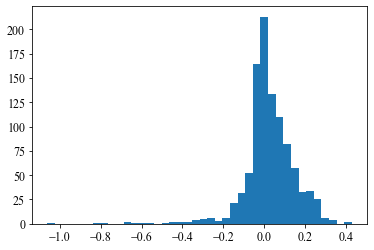

In [65]:
plt.hist(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]),bins=40)

Text(0.5, 1.0, 'Fit results: mu = 0.03,  std = 0.13')

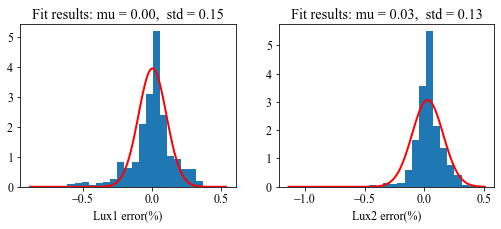

In [35]:
plt.figure(figsize=[8.5,3])


###########Sensor1##########
plt.subplot(1,2,1)

# Fit a normal distribution to the data:
mu, std = norm.fit(np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]))

# Plot the histogram.
plt.hist(np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]),bins=25,density=True)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std/1.5)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.xlabel('Lux1 error(%)')
plt.title(title)

###########Sensor2##########
plt.subplot(1,2,2)
# Fit a normal distribution to the data:
mu, std = norm.fit(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]))

# Plot the histogram.
plt.hist(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]),bins=25,density=True)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
plt.xlabel('Lux2 error(%)')
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

Text(0.5, 1.0, 'Fit results: mu = 0.03,  std = 0.13')

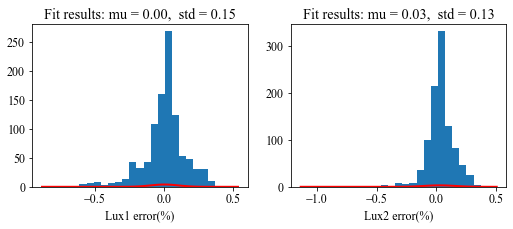

In [72]:
plt.figure(figsize=[8.5,3])


###########Sensor1##########
plt.subplot(1,2,1)

# Fit a normal distribution to the data:
mu, std = norm.fit(np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]))

# Plot the histogram.
plt.hist(np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]),bins=25)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std/1.5)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.xlabel('Lux1 error(%)')
plt.title(title)

###########Sensor2##########
plt.subplot(1,2,2)
# Fit a normal distribution to the data:
mu, std = norm.fit(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]))

# Plot the histogram.
plt.hist(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]),bins=25)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
plt.xlabel('Lux2 error(%)')
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

Text(0.5, 1.0, 'Fit results: mu = 0.13,  std = 0.15')

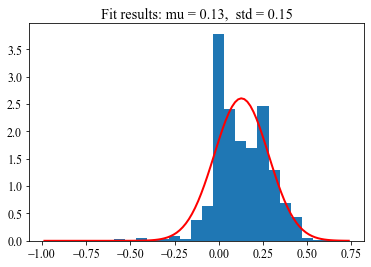

In [226]:
# Fit a normal distribution to the data:
mu, std = norm.fit(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]))

# Plot the histogram.
plt.hist(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]),bins=25,density=True)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

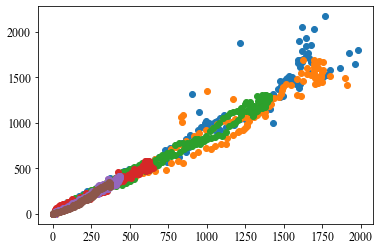

In [228]:
plt.scatter(np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1)*1.1,np.array(simu_result_0922_5M.iloc[:,0]))
plt.scatter(np.array(dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3])*1.1,np.array(simu_result_0923_5M.iloc[:,0]))
plt.scatter(np.array(dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1])*1.1,np.array(simu_result_0927_5M.iloc[:,0]))
plt.scatter(np.array(dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1])*1.1,np.array(simu_result_1003_5M.iloc[:,0]))
plt.scatter(np.array(dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1])*1.1,np.array(simu_result_1006_5M.iloc[:,0]))
plt.scatter(np.array(dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5*1.1,np.array(simu_result_1020_5M.iloc[:,0]))

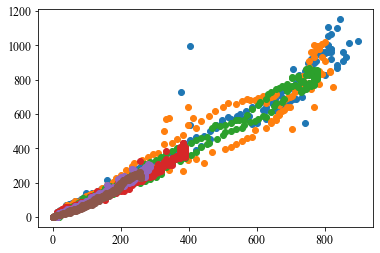

In [164]:
ax = plt.subplot()
plt.scatter(np.array(dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(simu_result_0922_5M.iloc[:,1]))
plt.scatter(np.array(dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]),np.array(simu_result_0923_5M.iloc[:,1]))
plt.scatter(np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(simu_result_0927_5M.iloc[:,1]))
plt.scatter(np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(simu_result_1003_5M.iloc[:,1]))
plt.scatter(np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(simu_result_1006_5M.iloc[:,1]))
plt.scatter(np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5,np.array(simu_result_1020_5M.iloc[:,1]))
#ax.set_xlim([0,1200])

In [16]:
from sklearn.linear_model import LinearRegression

Mea_Sensor1 = np.concatenate([np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]),np.array(dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5])
Sim_Sensor1 = np.concatenate([np.array(simu_result_0922_5M.iloc[:,0]),np.array(simu_result_0923_5M.iloc[:,0]),np.array(simu_result_0927_5M.iloc[:,0]),np.array(simu_result_1003_5M.iloc[:,0]),np.array(simu_result_1006_5M.iloc[:,0]),np.array(simu_result_1020_5M.iloc[:,0])])

reg = LinearRegression().fit(np.reshape(Mea_Sensor1,[-1,1]), Sim_Sensor1)
ax = plt.subplot()
#plt.scatter(Mea_Sensor1,Sim_Sensor1)
plt.scatter(np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(simu_result_0922_5M.iloc[:,0]))
#plt.scatter(np.array(dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(simu_result_0927_5M.iloc[:,0]))
#plt.scatter(np.array(dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(simu_result_1003_5M.iloc[:,0]))
#plt.scatter(np.array(dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(simu_result_1006_5M.iloc[:,0]))
#plt.scatter(np.array(dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5,np.array(simu_result_1020_5M.iloc[:,0]))


# Plot the Fitted curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = reg.predict(np.reshape(x,[-1,1]))

ax.legend(['Sep. 22$^{nd}$','Sep. 27$^{th}$','Oct. 03$^{rd}$','Oct. 06$^{th}$','Oct. 20$^{th}$','ete'])
plt.plot(x, p, 'k', linewidth=2)


plt.text(500,300,'$y={:.2f}x{:.2f}$'.format(reg.coef_[0],reg.intercept_))
plt.savefig('Figures/Res_Sensor1.jpg',dpi=300)

NameError: name 'simu_result_0923_5M' is not defined

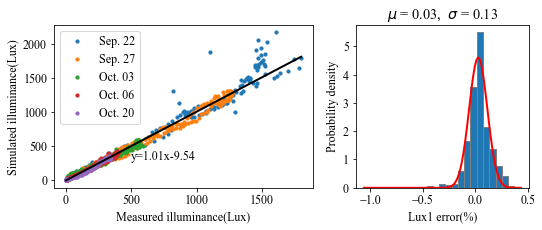

In [111]:
from sklearn.linear_model import LinearRegression

markerSize = 10

f = plt.figure(figsize=[8.5,3])
gs = gridspec.GridSpec(1, 2,width_ratios=[1.5,1])
              
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.scatter(np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(simu_result_0922_5M.iloc[:,0]),s = markerSize)
ax1.scatter(np.array(dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(simu_result_0927_5M.iloc[:,0]),s = markerSize)
ax1.scatter(np.array(dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(simu_result_1003_5M.iloc[:,0]),s = markerSize)
ax1.scatter(np.array(dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(simu_result_1006_5M.iloc[:,0]),s = markerSize)
ax1.scatter(np.array(dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5,np.array(simu_result_1020_5M.iloc[:,0]),s = markerSize)

Mea_Sensor1 = np.concatenate([np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(dat_17_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]),np.array(dat_17_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(dat_17_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(dat_17_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(dat_17_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5])
Sim_Sensor1 = np.concatenate([np.array(simu_result_0922_5M.iloc[:,0]),np.array(simu_result_0923_5M.iloc[:,0]),np.array(simu_result_0927_5M.iloc[:,0]),np.array(simu_result_1003_5M.iloc[:,0]),np.array(simu_result_1006_5M.iloc[:,0]),np.array(simu_result_1020_5M.iloc[:,0])])

reg = LinearRegression().fit(np.reshape(Mea_Sensor1,[-1,1]), Sim_Sensor1)

ax1.legend(['Sep. 22','Sep. 27','Oct. 03','Oct. 06','Oct. 20','ete'])

#ax1.legend(['Sep. 22$^{nd}$','Sep. 27$^{th}$','Oct. 03$^{rd}$','Oct. 06$^{th}$','Oct. 20$^{th}$','ete'])

# Plot the Fitted curve
xmin, xmax = Mea_Sensor1.min(),Mea_Sensor1.max()
x = np.linspace(xmin, xmax, 100)
p = reg.predict(np.reshape(x,[-1,1]))
ax1.plot(x, p, 'k', linewidth=2)

ax1.set_xlabel('Measured illuminance(Lux)')
ax1.set_ylabel('Simulated illuminance(Lux)')

ax1.text(500,300,'y={:.2f}x{:.2f}'.format(reg.coef_[0],reg.intercept_))


#################2nd plot#########################
# Fit a normal distribution to the data:
mu, std = norm.fit(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]))

# Plot the histogram.
ax2.hist(np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]),bins=25,density=True,edgecolor='gray')

# Plot the PDF.
xmin, xmax = np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]).min(),np.concatenate([res_Sensor1_0922,res_Sensor1_0923,res_Sensor1_0927,res_Sensor1_1003,res_Sensor1_1006,res_Sensor1_1020]).max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std/1.5)
ax2.plot(x, p, 'r', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
ax2.set_xlabel('Lux1 error(%)')
ax2.set_ylabel('Probability density')

title = "$\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std)
ax2.set_title(title)


plt.savefig('Figures/res_Sensor1.jpg',dpi=300,bbox_inches = 'tight')

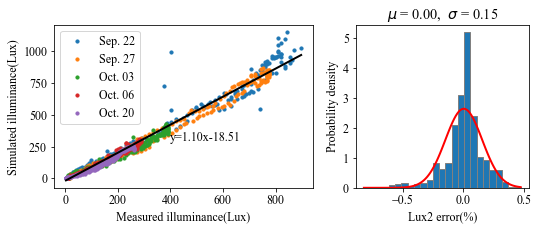

In [112]:
from sklearn.linear_model import LinearRegression

markerSize = 10

f = plt.figure(figsize=[8.5,3])
gs = gridspec.GridSpec(1, 2,width_ratios=[1.5,1])
              
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.scatter(np.array(dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(simu_result_0922_5M.iloc[:,1]),s=markerSize)
ax1.scatter(np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(simu_result_0927_5M.iloc[:,1]),s=markerSize)
ax1.scatter(np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(simu_result_1003_5M.iloc[:,1]),s=markerSize)
ax1.scatter(np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(simu_result_1006_5M.iloc[:,1]),s=markerSize)
ax1.scatter(np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5,np.array(simu_result_1020_5M.iloc[:,1]),s=markerSize)

Mea_Sensor2 = np.concatenate([np.array(dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]),np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5])
Sim_Sensor2 = np.concatenate([np.array(simu_result_0922_5M.iloc[:,1]),np.array(simu_result_0923_5M.iloc[:,1]),np.array(simu_result_0927_5M.iloc[:,1]),np.array(simu_result_1003_5M.iloc[:,1]),np.array(simu_result_1006_5M.iloc[:,1]),np.array(simu_result_1020_5M.iloc[:,1])])

reg = LinearRegression().fit(np.reshape(Mea_Sensor2,[-1,1]), Sim_Sensor2)
#ax1.legend(['Sep. 22$^{nd}$','Sep. 27$^{th}$','Oct. 03$^{rd}$','Oct. 06$^{th}$','Oct. 20$^{th}$','ete'])
ax1.legend(['Sep. 22','Sep. 27','Oct. 03','Oct. 06','Oct. 20','ete'])

# Plot the Fitted curve
xmin, xmax = Mea_Sensor2.min(),Mea_Sensor2.max()
x = np.linspace(xmin, xmax, 100)
p = reg.predict(np.reshape(x,[-1,1]))
ax1.plot(x, p, 'k', linewidth=2)

ax1.set_xlabel('Measured illuminance(Lux)')
ax1.set_ylabel('Simulated illuminance(Lux)')

ax1.text(400,300,'y={:.2f}x{:.2f}'.format(reg.coef_[0],reg.intercept_))


#################2nd plot#########################
# Fit a normal distribution to the data:
mu, std = norm.fit(np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]))

# Plot the histogram.
ax2.hist(np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]),bins=25,density=True, edgecolor='gray')


# Plot the PDF.
xmin, xmax = np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]).min(),np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]).max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax2.plot(x, p, 'r', linewidth=2)

title = "$\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std)
ax2.set_xlabel('Lux2 error(%)')
ax2.set_ylabel('Probability density')
ax2.set_title(title)


plt.savefig('Figures/Res_Sensor2.jpg',dpi=300,bbox_inches = 'tight')


In [74]:
np.concatenate([res_Sensor2_0922,res_Sensor2_0923,res_Sensor2_0927,res_Sensor2_1003,res_Sensor2_1006,res_Sensor2_1020]).max()

0.47212077599339264

NameError: name 'ax' is not defined

<Figure size 612x288 with 0 Axes>

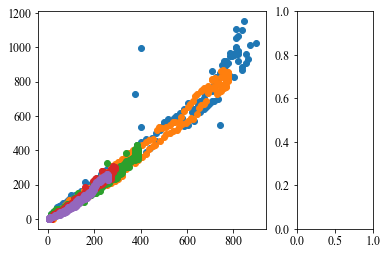

In [83]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize=[8.5,4])
Mea_Sensor2 = np.concatenate([np.array(dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]),np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5])
Sim_Sensor2 = np.concatenate([np.array(simu_result_0922_5M.iloc[:,1]),np.array(simu_result_0923_5M.iloc[:,1]),np.array(simu_result_0927_5M.iloc[:,1]),np.array(simu_result_1003_5M.iloc[:,1]),np.array(simu_result_1006_5M.iloc[:,1]),np.array(simu_result_1020_5M.iloc[:,1])])

reg = LinearRegression().fit(np.reshape(Mea_Sensor2,[-1,1]), Sim_Sensor2)
f,(a0,a1) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]})
#plt.scatter(Mea_Sensor2,Sim_Sensor2)

a0.scatter(np.array(dat_18_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(simu_result_0922_5M.iloc[:,1]))
#plt.scatter(np.array(dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]),np.array(simu_result_0923_5M.iloc[:,1]))
a0.scatter(np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(simu_result_0927_5M.iloc[:,1]))
a0.scatter(np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(simu_result_1003_5M.iloc[:,1]))
a0.scatter(np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(simu_result_1006_5M.iloc[:,1]))
a0.scatter(np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5,np.array(simu_result_1020_5M.iloc[:,1]))

# Plot the Fitted curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = reg.predict(np.reshape(x,[-1,1]))


ax.set_xlabel('Measured illuminance(Lux)')
ax.set_ylabel('Simulated illuminance(Lux)')

ax.legend(['Sep. 22$^{nd}$','Sep. 27$^{th}$','Oct. 03$^{rd}$','Oct. 06$^{th}$','Oct. 20$^{th}$','ete'])
a0.plot(x, p, 'k', linewidth=2)


plt.text(400,300,'$y={:.2f}x{:.2f}$'.format(reg.coef_[0],reg.intercept_))
plt.savefig('Figures/Res_Sensor2.jpg',dpi=300)

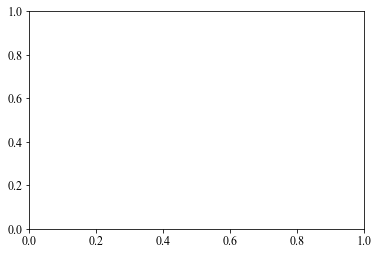

In [174]:
from sklearn.linear_model import LinearRegression

Mea_Sensor2 = np.concatenate([np.array(dat_17_5M_Case1['2022-09-22 06:00:00':'2022-09-22 19:55:00'].iloc[:,3]*1.1),np.array(dat_18_5M_Case1['2022-09-23 06:00:00':'2022-09-23 19:55:00'].iloc[:,3]),np.array(dat_18_5M_Case2['2022-09-27 06:00:00':'2022-09-27 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case2['2022-10-03 06:00:00':'2022-10-03 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case3['2022-10-06 06:00:00':'2022-10-06 19:55:00'].iloc[:,-1]),np.array(dat_18_5M_Case5['2022-10-20 06:00:00':'2022-10-20 19:55:00'].iloc[:,-1])/4.5])
Sim_Sensor2 = np.concatenate([np.array(simu_result_0922_5M.iloc[:,1]),np.array(simu_result_0923_5M.iloc[:,1]),np.array(simu_result_0927_5M.iloc[:,1]),np.array(simu_result_1003_5M.iloc[:,1]),np.array(simu_result_1006_5M.iloc[:,1]),np.array(simu_result_1020_5M.iloc[:,1])])

reg = LinearRegression().fit(np.reshape(Mea_Sensor2*1.1,[-1,1]), Sim_Sensor2)

plt.scatter(Mea_Sensor2*1.1,Sim_Sensor2)

# Plot the Fitted curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = reg.predict(np.reshape(x,[-1,1]))

plt.plot(x, p, 'r', linewidth=2)

plt.text(400,700,'y={:.2f}x{:.2f}'.format(reg.coef_[0],reg.intercept_))

<Figure size 612x216 with 0 Axes>

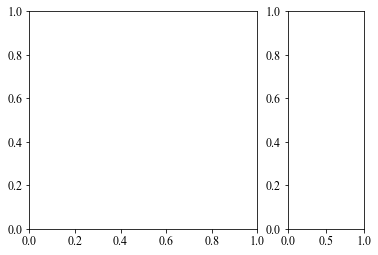

In [4]:
plt.figure(figsize=[8.5,3])
f,(a0,a1) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]})